# Setup

In [ ]:
%pip install torch-geometric
%pip install pynvml

In [1]:
import os
import math
import time
import copy
import psutil
import pynvml
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, random_split

import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(42)

using cpu


# Data Preprocessing

In [2]:
dataset_path = '/notebooks/dataset/'


def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
    num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            adj_matrix = graph_dataset[i, t, :, :]
            num_edges = np.sum(adj_matrix > 0)
            if num_edges == 0:
                is_valid = False
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

def convert_to_pyg_data(adj_matrices, inp_features):
    pyg_data_list = []
    
    num_graphs = adj_matrices.shape[0]
    num_timepoints = adj_matrices.shape[1]
    
    for i in range(num_graphs):
        for t in range(num_timepoints):
            adj_matrix = adj_matrices[i, t]
            features = inp_features[i, t]
            
            # Get edge indices
            edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
            
            # Get edge attributes
            edge_attr = torch.tensor(adj_matrix[adj_matrix.nonzero()], dtype=torch.float)
            
            # Node features
            x = torch.tensor(features, dtype=torch.float)
            
            # Label (timepoint)
            y = torch.tensor([t], dtype=torch.long)
            
            pyg_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

def get_dataset_info(pyg_data_list):
    num_features = pyg_data_list[0].x.shape[1]
    all_labels = torch.cat([data.y for data in pyg_data_list])
    num_classes = torch.unique(all_labels).numel()
    return num_features, num_classes


In [4]:
# Load dataset
mutag_dataset = TUDataset(root=f'/tmp/MUTAG', name='MUTAG', use_node_attr=True)
mutag_num_features = mutag_dataset.num_features
mutag_num_classes = mutag_dataset.num_classes
print(f"MUTAG Dataset, Num Features:{mutag_num_features} Num Classes: {mutag_num_classes}")

proteins_dataset = TUDataset(root=f'/tmp/PROTEINS', name='PROTEINS', use_node_attr=True)
proteins_num_features = proteins_dataset.num_features
proteins_num_classes = proteins_dataset.num_classes
print(f"PROTEINS Dataset, Num Features:{proteins_num_features} Num Classes: {proteins_num_classes}")

dd_dataset = TUDataset(root=f'/tmp/DD', name='DD', use_node_attr=True)
dnd_num_features = dd_dataset.num_features
dnd_num_classes = dd_dataset.num_classes
print(f"DD Dataset, Num Features:{dnd_num_features} Num Classes: {dnd_num_classes}")

enzymes_dataset = TUDataset(root=f'/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
enzymes_num_features = enzymes_dataset.num_features
enzymes_num_classes = enzymes_dataset.num_classes
print(f"ENZYMES Dataset, Num Features:{enzymes_num_features} Num Classes: {enzymes_num_classes}")


MUTAG Dataset, Num Features:7 Num Classes: 2
PROTEINS Dataset, Num Features:4 Num Classes: 2
DD Dataset, Num Features:89 Num Classes: 2
ENZYMES Dataset, Num Features:21 Num Classes: 6


# Models

In [37]:
## GCN Models
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)

        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)

        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN3Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN3Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.gcn3 = GCN(hidden_features*2, hidden_features)
        self.bn3 = nn.BatchNorm1d(hidden_features)

        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = F.relu(self.bn3(self.gcn3(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN4Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN4Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.gcn3 = GCN(hidden_features*2, hidden_features*3)
        self.bn3 = nn.BatchNorm1d(hidden_features*3)
        self.gcn4 = GCN(hidden_features*3, hidden_features*2)
        self.bn4 = nn.BatchNorm1d(hidden_features*2)
        
        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = F.relu(self.bn3(self.gcn3(x, adj)))
        x = F.relu(self.bn4(self.gcn4(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN5Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN5Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.gcn3 = GCN(hidden_features*2, hidden_features*3)
        self.bn3 = nn.BatchNorm1d(hidden_features*3)
        self.gcn4 = GCN(hidden_features*3, hidden_features*2)
        self.bn4 = nn.BatchNorm1d(hidden_features*2)
        self.gcn5 = GCN(hidden_features*2, hidden_features)
        self.bn5 = nn.BatchNorm1d(hidden_features)
        
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = F.relu(self.bn3(self.gcn3(x, adj)))
        x = F.relu(self.bn4(self.gcn4(x, adj)))
        x = F.relu(self.bn5(self.gcn5(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
        

## GAT Model
class GAT(nn.Module):
    def __init__(self, in_features, out_features, activation=F.relu):
        super(GAT, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.phi = nn.Parameter(torch.FloatTensor(2 * out_features, 1))
        self.activation = activation
        self.reset_parameters()
        self.drop = nn.Dropout(p=0.5)
 
    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
 
        stdv = 1. / np.sqrt(self.phi.size(1))
        self.phi.data.uniform_(-stdv, stdv)
 
    def forward(self, input, adj):
        h = torch.mm(input, self.weight.to(device)) + self.bias.to(device) 
 
        N = input.size(0) 
        h_expand = h.unsqueeze(1).expand(N, N, -1)
        h_t_expand = h.unsqueeze(0).expand(N, N, -1)
        
        concat_features = torch.cat([h_expand, h_t_expand], dim=-1)
        
        S = torch.matmul(concat_features, self.phi).squeeze(-1)
 
        mask = (adj + torch.eye(adj.size(0)).to(device)).bool()
        S_masked = torch.where(mask, S, torch.tensor(-9e15, dtype=S.dtype))
        attention_weights = F.softmax(S_masked, dim=1)
        h = torch.matmul(attention_weights, h)
        return self.activation(h) if self.activation else h
    
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GAT1Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT1Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)

        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gat1(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GAT2Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT2Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gat2 = GAT(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gat1(x, adj)))
        x = F.relu(self.bn2(self.gat2(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GAT3Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT3Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gat2 = GAT(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.gat3 = GAT(hidden_features*2, hidden_features)
        self.bn3 = nn.BatchNorm1d(hidden_features)
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gat1(x, adj)))
        x = F.relu(self.bn2(self.gat2(x, adj)))
        x = F.relu(self.bn3(self.gat3(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GAT4Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT4Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gat2 = GAT(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.gat3 = GAT(hidden_features*2, hidden_features*3)
        self.bn3 = nn.BatchNorm1d(hidden_features*3)
        self.gat4 = GAT(hidden_features*3, hidden_features*2)
        self.bn4 = nn.BatchNorm1d(hidden_features*2)
        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gat1(x, adj)))
        x = F.relu(self.bn2(self.gat2(x, adj)))
        x = F.relu(self.bn3(self.gat3(x, adj)))
        x = F.relu(self.bn4(self.gat4(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GAT5Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT5Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gat2 = GAT(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.gat3 = GAT(hidden_features*2, hidden_features*3)
        self.bn3 = nn.BatchNorm1d(hidden_features*3)
        self.gat4 = GAT(hidden_features*3, hidden_features*2)
        self.bn4 = nn.BatchNorm1d(hidden_features*2)
        self.gat5 = GAT(hidden_features*2, hidden_features)
        self.bn5 = nn.BatchNorm1d(hidden_features)
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gat1(x, adj)))
        x = F.relu(self.bn2(self.gat2(x, adj)))
        x = F.relu(self.bn3(self.gat3(x, adj)))
        x = F.relu(self.bn4(self.gat4(x, adj)))
        x = F.relu(self.bn5(self.gat5(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
   
## GCESN
class GCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(GCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)

        self.fc = nn.Linear(self.hidden_features, num_classes)

        # Initialize non-trainable weights with dummy tensors
        self.Win = nn.Parameter(torch.zeros((self.in_features, self.hidden_features)), requires_grad=False)
        self.W = nn.Parameter(torch.zeros((self.hidden_features, self.hidden_features)), requires_grad=False)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W))))
        h = F.relu(self.bn(self.fc1(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
        
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(GCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 2*hidden_features)
        self.bn = nn.BatchNorm1d(2*hidden_features)
        
        self.fc = nn.Linear(2*self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = F.relu(self.bn(self.fc2(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_3layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(GCESN_3layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)
        
        self.fc = nn.Linear(self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_3 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3 *= self.spectral_radius / rhoW_3

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = F.relu(self.bn(self.fc3(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_4layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(GCESN_4layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.leaky_rate4 = leaky_rate - 0.3
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 3*hidden_features)
        self.fc3 = nn.Linear(3*hidden_features, 2*hidden_features)
        self.fc4 = nn.Linear(2*hidden_features, 2*hidden_features)
        self.bn = nn.BatchNorm1d(2*hidden_features)
        
        self.fc = nn.Linear(2*self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_3 = nn.Parameter(torch.rand((3*self.hidden_features, 3*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_4 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3 *= self.spectral_radius / rhoW_3

        eigenvalues_4, _ = torch.linalg.eig(self.W_4)
        rhoW_4 = max(abs(eigenvalues_4))
        self.W_4 *= self.spectral_radius / rhoW_4

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = self.fc3(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate4)*h + self.leaky_rate4*(F.relu(torch.mm(adj, torch.mm(h, self.W_4))))
        h = F.relu(self.bn(self.fc4(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_5layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(GCESN_5layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.leaky_rate4 = leaky_rate - 0.3
        self.leaky_rate5 = leaky_rate - 0.4
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 3*hidden_features)
        self.fc3 = nn.Linear(3*hidden_features, 2*hidden_features)
        self.fc4 = nn.Linear(2*hidden_features, hidden_features)
        self.fc5 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)
        
        self.fc = nn.Linear(self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_3 = nn.Parameter(torch.rand((3*self.hidden_features, 3*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_4 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_5 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3 *= self.spectral_radius / rhoW_3

        eigenvalues_4, _ = torch.linalg.eig(self.W_4)
        rhoW_4 = max(abs(eigenvalues_4))
        self.W_4 *= self.spectral_radius / rhoW_4

        eigenvalues_5, _ = torch.linalg.eig(self.W_5)
        rhoW_5 = max(abs(eigenvalues_5))
        self.W_5 *= self.spectral_radius / rhoW_5

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = self.fc3(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate4)*h + self.leaky_rate4*(F.relu(torch.mm(adj, torch.mm(h, self.W_4))))
        h = self.fc4(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate5)*h + self.leaky_rate5*(F.relu(torch.mm(adj, torch.mm(h, self.W_5))))
        h = F.relu(self.bn(self.fc5(h)))
        

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


## TrainableGCESN Model
class SpectralRadiusOptimizerHook:
    def __init__(self, model):
        self.model = model

    def __call__(self):
        self.model.adjust_spectral_radius()

class TrainableGCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(TrainableGCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()
        
        self.fc1 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)

        self.fc = nn.Linear(self.hidden_features, num_classes)

    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W.data *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W))))
        h = F.relu(self.bn(self.fc1(h)))
        
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class TrainableGCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(TrainableGCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.Win_1 = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()

        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)

        self.fc = nn.Linear(self.hidden_features, num_classes)
    
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1.data *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2.data *= self.spectral_radius / rhoW_2

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win_1)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = F.relu(self.bn(self.fc2(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class TrainableGCESN_3layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(TrainableGCESN_3layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9

        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.W_3 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()

        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)

        self.fc = nn.Linear(self.hidden_features, num_classes)
    
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1.data *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2.data *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3.data *= self.spectral_radius / rhoW_3

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = F.relu(self.bn(self.fc3(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class TrainableGCESN_4layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(TrainableGCESN_4layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.leaky_rate4 = leaky_rate - 0.3
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.W_3 = nn.Parameter(torch.rand((3*self.hidden_features, 3*self.hidden_features)) * 2 - 1)
        self.W_4 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()

        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 3*hidden_features)
        self.fc3 = nn.Linear(3*hidden_features, 2*hidden_features)
        self.fc4 = nn.Linear(2*hidden_features, 2*hidden_features)
        self.bn = nn.BatchNorm1d(2*hidden_features)

        self.fc = nn.Linear(2*self.hidden_features, num_classes)
    
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1.data *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2.data *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3.data *= self.spectral_radius / rhoW_3

        eigenvalues_4, _ = torch.linalg.eig(self.W_4)
        rhoW_4 = max(abs(eigenvalues_4))
        self.W_4.data *= self.spectral_radius / rhoW_4

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = self.fc3(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate4)*h + self.leaky_rate4*(F.relu(torch.mm(adj, torch.mm(h, self.W_4))))
        h = F.relu(self.bn(self.fc4(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class TrainableGCESN_5layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(TrainableGCESN_5layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.leaky_rate4 = leaky_rate - 0.3
        self.leaky_rate5 = leaky_rate - 0.4
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.W_3 = nn.Parameter(torch.rand((3*self.hidden_features, 3*self.hidden_features)) * 2 - 1)
        self.W_4 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.W_5 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()

        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 3*hidden_features)
        self.fc3 = nn.Linear(3*hidden_features, 2*hidden_features)
        self.fc4 = nn.Linear(2*hidden_features, hidden_features)
        self.fc5 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)

        self.fc = nn.Linear(self.hidden_features, num_classes)
    
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1.data *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2.data *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3.data *= self.spectral_radius / rhoW_3

        eigenvalues_4, _ = torch.linalg.eig(self.W_4)
        rhoW_4 = max(abs(eigenvalues_4))
        self.W_4.data *= self.spectral_radius / rhoW_4

        eigenvalues_5, _ = torch.linalg.eig(self.W_5)
        rhoW_5 = max(abs(eigenvalues_5))
        self.W_5.data *= self.spectral_radius / rhoW_5

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = self.fc3(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate4)*h + self.leaky_rate4*(F.relu(torch.mm(adj, torch.mm(h, self.W_4))))
        h = self.fc4(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate5)*h + self.leaky_rate5*(F.relu(torch.mm(adj, torch.mm(h, self.W_5))))
        h = F.relu(self.bn(self.fc5(h)))
        

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


## Decoupled GCESN Model
class decoupledGCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=1, ridge_alpha=0.9):
        super(decoupledGCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations

        self.gcn1 = GCN(in_features, hidden_features)
        self.bn_gcn1 = nn.BatchNorm1d(hidden_features)
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.bn_r1 = nn.BatchNorm1d(hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.hidden_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.in_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW
        
    def forward(self, x, adj, batch):
        n_node, _ = x.shape
        state = x
        h = x

        h = F.relu(self.bn_gcn1(self.gcn1(h, adj)))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win) + torch.mm(state, self.W)))
        
        h = F.relu(self.bn_r1(self.fc1(state)))
        x = global_mean_pool(h, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class decoupledGCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=1, ridge_alpha=0.9):
        super(decoupledGCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations

        self.gcn1 = GCN(in_features, hidden_features)
        self.gcn2 = GCN(hidden_features, 2*hidden_features)
        self.ridge_layer = RidgeLayer(in_features, hidden_features, ridge_alpha)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win_1 = nn.Parameter(torch.rand((self.hidden_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.W_1   = nn.Parameter(torch.rand((self.in_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.Win_2 = nn.Parameter(torch.rand((2*self.hidden_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.W_2   = nn.Parameter(torch.rand((self.in_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2
        
    def forward(self, x, adj, batch):
        n_node, _ = x.shape
        state = x
        h = x

        h = F.relu(self.gcn1(h, adj))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win_1) + torch.mm(state, self.W_1)))

        h = F.relu(self.gcn2(h, adj))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win_2) + torch.mm(state, self.W_2)))
        
        h = self.ridge_layer(state)
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Trainings & Evaluations

In [6]:
## Single Functions
def single_train(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, 
                step_size=50, gamma=0.5, save_path='models/gcn_x.pth', 
                binary_classification=True, is_esn=False):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    if is_esn == True:
        spectral_hook = SpectralRadiusOptimizerHook(model)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    # Get the process object for the current process
    process = psutil.Process()

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for data in loader:
            x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            if is_esn==True:
                spectral_hook()

            epoch_loss += loss.item() * data.num_graphs
        
        scheduler.step()  # Step the learning rate scheduler

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        
        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch, y = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device), val_data.y.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, y).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                total_epoch = epoch + 1
                break

    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(save_path))

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_memory_usage = np.mean(memory_usage)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_gpu_usage_percent = np.mean(gpu_usage_percent)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_memory_usage = np.max(memory_usage)
    max_gpu_usage = np.max(gpu_usage)
    max_gpu_usage_percent = np.max(gpu_usage_percent)

    return total_epoch, total_training_time, avg_memory_usage, avg_gpu_usage, max_memory_usage, max_gpu_usage

def binary_evaluation(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    return accuracy, sensitivity, specificity

def multiclass_evaluation(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # print(f'Confusion Matrix:\n{cm}')

    # Calculate metrics
    accuracy = np.trace(cm) / np.sum(cm)
    sensitivity = np.zeros(cm.shape[0])
    specificity = np.zeros(cm.shape[0])
    
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

    avg_sensitivity = np.mean(sensitivity)
    avg_specificity = np.mean(specificity)

    return accuracy, avg_sensitivity, avg_specificity

def inference_performance(model, loader):
    model.eval()
    total_inference_time = 0
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []
    labels = []

    # Get the process object for the current process
    process = psutil.Process()

    for data in loader:
        x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
        adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
        
        # Measure CPU and GPU usage before inference
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        start_time = time.time()
        with torch.no_grad():
            output = model(x, adj_matrix, batch)
            labels.append(data.y.cpu().numpy())
        end_time = time.time()

        # Measure CPU and GPU usage after inference
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during inference
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        # Calculate inference time
        inference_time = end_time - start_time
        total_inference_time += inference_time

    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_memory_usage = np.mean(memory_usage)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_gpu_usage_percent = np.mean(gpu_usage_percent)
    total_inference_time = total_inference_time / len(loader)  # Average inference time per batch

    print(f'\nAverage Inference Time per Batch: {total_inference_time:.4f}s')
    print(f'Average CPU Usage: {avg_cpu_usage_percent:.2f}%')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'Average GPU Usage: {avg_gpu_usage:.2f}GB')
    print(f'Average GPU Utilization: {avg_gpu_usage_percent:.2f}%')

    return 


## Multiple Runs
def multi_train(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, 
                step_size=50, gamma=0.5, binary_classification=True):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    # Get the process object for the current process
    process = psutil.Process()

    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()
        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for data in loader:
            x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, y) ##+ model.ridge_loss() 
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs
        
        scheduler.step()  # Step the learning rate scheduler

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        
        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch, y = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device), val_data.y.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, y).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                total_epoch = epoch + 1
                break

    total_training_time = np.sum(epoch_time)
    avg_epoch_time = np.mean(epoch_time)

    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_memory_usage = np.mean(memory_usage)

    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_gpu_usage = np.max(gpu_usage)
    max_memory_usage = np.max(memory_usage)

    return training_loss[-1], total_epoch, total_training_time, avg_epoch_time, avg_cpu_usage_percent, avg_gpu_usage, avg_memory_usage, max_cpu_usage_percent, max_gpu_usage, max_memory_usage 
   
def multi_test(model, loader, binary_classification=True):
    set_seed(42)
    model.eval()
    y_true = []
    y_pred = []

    start_time = time.time()
    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())
    end_time = time.time()  # End the timer
    testing_time = end_time - start_time

    if binary_classification:
        accuracy, sensitivity, specificity = binary_evaluation(y_true, y_pred)
    else:
        accuracy, sensitivity, specificity = multiclass_evaluation(y_true, y_pred)

    return accuracy, sensitivity, specificity, testing_time


## Cross Validation
def single_train_test_cv(model, dataset, num_folds=3, lr=0.001, num_epochs=100, patience=10, step_size=50, gamma=0.5, 
                         save_path='models/gcn_x_cv.pth', binary_classification=True, is_esn=False):

    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_results = {
        "accuracy": [],
        "sensitivity": [],
        "specificity": [],
        "epochs": [],
        "training_times": [],
        "testing_times": [],
        "avg_memory_usage": [],
        "avg_gpu_usage": [],
        "max_memory_usage": [],
        "max_gpu_usage": []
    }

    for fold, (train_val_idx, test_idx) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold+1}/{num_folds}")
        
        set_seed(fold)
        # Create samplers
        train_val_sampler = SubsetRandomSampler(train_val_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        
        # Create data loaders with deterministic behavior
        train_val_loader = DataLoader(dataset, sampler=train_val_sampler, batch_size=32, num_workers=0)
        test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=32, num_workers=0)
        
        # Split train_val indices into train and validation indices
        train_size = int(0.9 * len(train_val_idx))
        val_size = len(train_val_idx) - train_size
        train_indices, val_indices = train_val_idx[:train_size], train_val_idx[train_size:]

        # Create subsets
        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=32, worker_init_fn=seed_worker, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=32, worker_init_fn=seed_worker, num_workers=0)
        
        # Initialize model
        model_copy = copy.deepcopy(model)
        
        # Train the model
        # set_seed(42)
        total_epoch, total_training_time, avg_memory_usage, avg_gpu_usage, max_memory_usage, max_gpu_usage = single_train(
            model_copy, train_loader, val_loader, lr=lr, num_epochs=num_epochs, patience=patience, 
            step_size=step_size, gamma=gamma, save_path=save_path, 
            binary_classification=binary_classification, is_esn=is_esn)
        
        # Test the model
        # set_seed(42)
        accuracy, sensitivity, specificity, testing_time = multi_test(model_copy.to(device), test_loader, binary_classification=binary_classification)

        # Collect metrics for the fold
        fold_results["accuracy"].append(accuracy)
        fold_results["sensitivity"].append(sensitivity)
        fold_results["specificity"].append(specificity)
        fold_results["epochs"].append(total_epoch)
        fold_results["training_times"].append(total_training_time)
        fold_results["testing_times"].append(testing_time)
        fold_results["avg_memory_usage"].append(avg_memory_usage)
        fold_results["avg_gpu_usage"].append(avg_gpu_usage)
        fold_results["max_memory_usage"].append(max_memory_usage)
        fold_results["max_gpu_usage"].append(max_gpu_usage)

        print(f"Fold {fold+1} Results:")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   Average Sensitivity (Recall): {sensitivity:.4f}")
        print(f"   Average Specificity: {specificity:.4f}")

    # Compute average metrics across all folds
    avg_metrics = {metric: np.mean(fold_results[metric]) for metric in fold_results}
    std_metrics = {metric: np.std(fold_results[metric]) for metric in fold_results}

    print("\nCross-Validation Results:")
    for metric in avg_metrics:
        avg_value = avg_metrics[metric]
        std_value = std_metrics[metric]
        print(f"{metric}: Mean = {avg_value:.4f} ± {std_value:.2f}")

    return avg_metrics

def multi_train_test_cv(model, dataset, num_runs=3, num_folds=3, lr=0.001, num_epochs=100, patience=10, step_size=50, gamma=0.1, 
                        binary_classification=True, best_model_path='models/best_model.pth'):
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    overall_results = {
        "accuracy": [],
        "sensitivity": [],
        "specificity": [],
        "training_time": [],
        "testing_time": [],
        "epoch_time": [],
        "num_epoch": [],
        "avg_gpu_usage": [],
        "avg_memory_usage": [],
        "max_gpu_usage": [],
        "max_memory_usage": []
    }

    for run in range(num_runs):
        print(f"\nRun {run+1}/{num_runs}")
        fold_results = {
            "accuracy": [],
            "sensitivity": [],
            "specificity": []
        }

        for fold, (train_val_idx, test_idx) in enumerate(kfold.split(dataset)):
            print(f"Fold {fold+1}/{num_folds}")

            # Set seed for each fold to ensure reproducibility
            set_seed(42 + run + fold)
            
            # Create samplers
            train_val_sampler = SubsetRandomSampler(train_val_idx)
            test_sampler = SubsetRandomSampler(test_idx)

            # Create data loaders
            train_val_loader = DataLoader(dataset, sampler=train_val_sampler, batch_size=32)
            test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=32)

            # Split train_val indices into train and validation indices
            train_size = int(0.9 * len(train_val_idx))
            val_size = len(train_val_idx) - train_size
            train_indices, val_indices = train_val_idx[:train_size], train_val_idx[train_size:]

            # Create subsets
            train_dataset = Subset(dataset, train_indices)
            val_dataset = Subset(dataset, val_indices)

            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=32)
            val_loader = DataLoader(val_dataset, batch_size=32)

            # Initialize model
            model_copy = copy.deepcopy(model)
            set_seed(42 + run + fold)  # Ensure reproducibility across models
            model_copy.initialize_weights()

            # Train the model
            loss, total_epoch, training_time, epoch_time, avg_cpu, avg_gpu, avg_memory, max_cpu, max_gpu, max_memory = multi_train(
                model_copy, train_loader, val_loader, lr=lr, num_epochs=num_epochs, patience=patience, 
                step_size=step_size, gamma=gamma)

            # Test the model
            accuracy, sensitivity, specificity, testing_time = multi_test(model_copy.to(device), test_loader, binary_classification=binary_classification)

            # Collect metrics for the fold
            fold_results["accuracy"].append(accuracy)
            fold_results["sensitivity"].append(sensitivity)
            fold_results["specificity"].append(specificity)

            # Collect runtime metrics
            overall_results["training_time"].append(training_time)
            overall_results["testing_time"].append(testing_time)
            overall_results["epoch_time"].append(epoch_time)
            overall_results["num_epoch"].append(total_epoch)
            overall_results["avg_gpu_usage"].append(avg_gpu)
            overall_results["avg_memory_usage"].append(avg_memory)
            overall_results["max_gpu_usage"].append(max_gpu)
            overall_results["max_memory_usage"].append(max_memory)

            print(f"Fold {fold+1} Results:")
            print(f"   Accuracy: {accuracy:.4f}")
            print(f"   Average Sensitivity (Recall): {sensitivity:.4f}")
            print(f"   Average Specificity: {specificity:.4f}")

        # Compute average metrics across all folds for the current run
        avg_metrics = {metric: np.mean(fold_results[metric]) for metric in fold_results}
        std_metrics = {metric: np.std(fold_results[metric]) for metric in fold_results}

        print(f"Run {run+1} Cross-Validation Results:")
        for metric in avg_metrics:
            avg_value = avg_metrics[metric]
            std_value = std_metrics[metric]
            print(f"{metric}: Mean = {avg_value:.4f}, Std = {std_value:.4f}")

        # Store results for each run
        overall_results["accuracy"].append(avg_metrics["accuracy"])
        overall_results["sensitivity"].append(avg_metrics["sensitivity"])
        overall_results["specificity"].append(avg_metrics["specificity"])

    # Compute average values across all runs
    final_avg_metrics = {metric: np.mean(overall_results[metric]) for metric in overall_results if "usage" not in metric}
    final_std_metrics = {metric: np.std(overall_results[metric]) for metric in overall_results if "usage" not in metric}
    max_metrics = {metric: np.max(overall_results[metric]) for metric in overall_results if "usage" not in metric}

    print("\nOverall Results:")
    for metric in final_avg_metrics:
        avg_value = final_avg_metrics[metric]
        std_value = final_std_metrics[metric]
        max_value = max_metrics[metric]
        print(f"{metric}: Mean = {avg_value:.4f} ± {std_value:.2f}, Max = {max_value:.4f}")

    return overall_results

# MUTAG

## GAT

GAT1Layer(
  (gat1): GAT (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 198


Fold 1/3


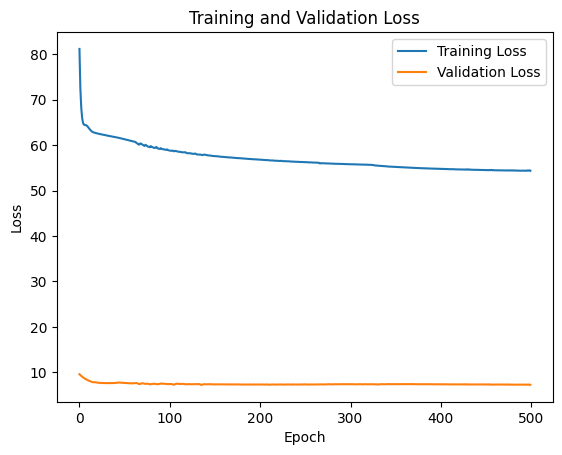

Fold 1 Results:
   Accuracy: 0.7937
   Average Sensitivity (Recall): 0.9024
   Average Specificity: 0.5909

Fold 2/3


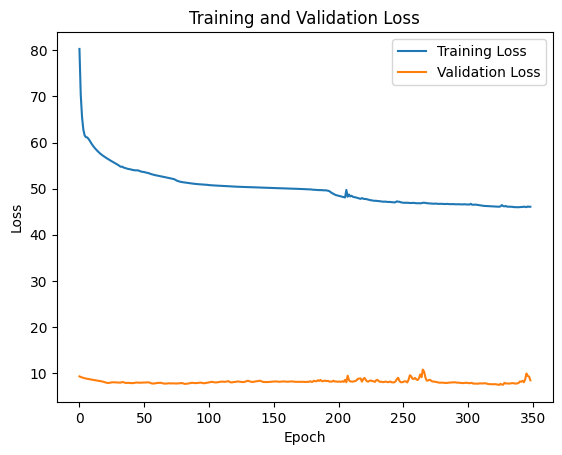

Fold 2 Results:
   Accuracy: 0.7143
   Average Sensitivity (Recall): 0.8333
   Average Specificity: 0.4762

Fold 3/3


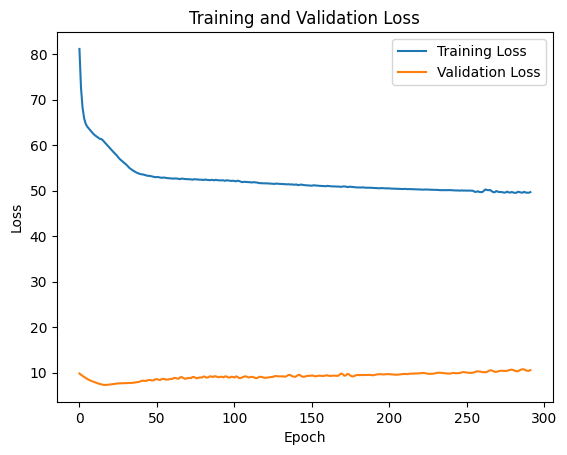

Fold 3 Results:
   Accuracy: 0.7258
   Average Sensitivity (Recall): 0.9048
   Average Specificity: 0.3500

Cross-Validation Results:
accuracy: Mean = 0.7446 ± 0.04
sensitivity: Mean = 0.8802 ± 0.03
specificity: Mean = 0.4724 ± 0.10
epochs: Mean = 378.3333 ± 85.03
training_times: Mean = 11.5170 ± 2.62
testing_times: Mean = 0.0109 ± 0.00
avg_memory_usage: Mean = 4.5775 ± 0.00
avg_gpu_usage: Mean = 0.2344 ± 0.00
max_memory_usage: Mean = 4.5775 ± 0.00
max_gpu_usage: Mean = 0.2344 ± 0.00


In [34]:
set_seed(42)
gat1_mutag = GAT1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes).to(device)
print(gat1_mutag)
print(f"Total number of trainable parameters: {(gat1_mutag.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat1_mutag, mutag_dataset, 
            lr=0.005, num_epochs=500, step_size=500,  
            save_path='models/gat_1l_mutag.pth')

GAT2Layer(
  (gat1): GAT (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GAT (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 758


Fold 1/3


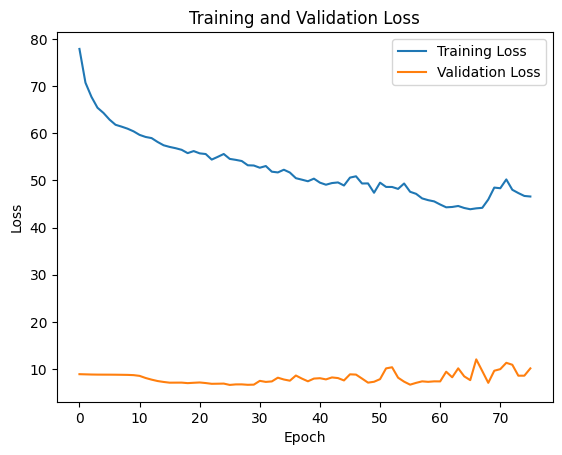

Fold 1 Results:
   Accuracy: 0.8254
   Average Sensitivity (Recall): 0.9512
   Average Specificity: 0.5909

Fold 2/3


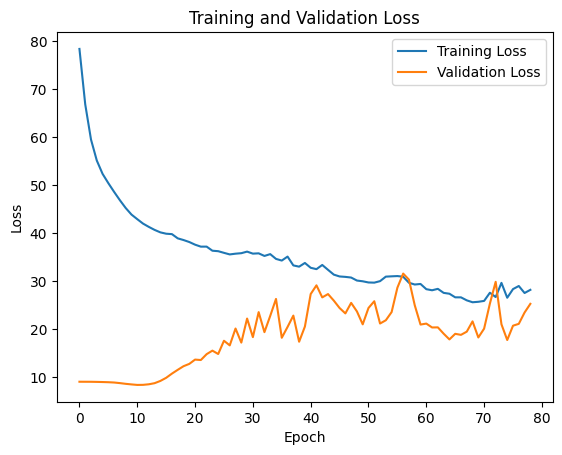

Fold 2 Results:
   Accuracy: 0.6667
   Average Sensitivity (Recall): 0.6905
   Average Specificity: 0.6190

Fold 3/3


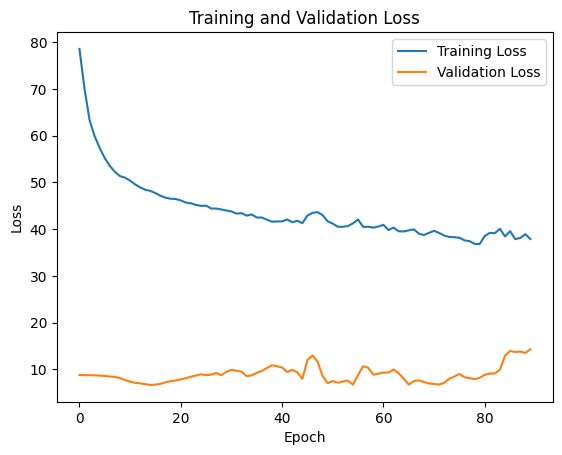

Fold 3 Results:
   Accuracy: 0.8226
   Average Sensitivity (Recall): 0.9286
   Average Specificity: 0.6000

Cross-Validation Results:
accuracy: Mean = 0.7715 ± 0.07
sensitivity: Mean = 0.8568 ± 0.12
specificity: Mean = 0.6033 ± 0.01
epochs: Mean = 81.6667 ± 6.02
training_times: Mean = 3.7896 ± 1.30
testing_times: Mean = 0.0174 ± 0.01
avg_memory_usage: Mean = 4.5775 ± 0.00
avg_gpu_usage: Mean = 0.2345 ± 0.00
max_memory_usage: Mean = 4.5775 ± 0.00
max_gpu_usage: Mean = 0.2345 ± 0.00


In [33]:
set_seed(42)
gat2_mutag = GAT2Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes).to(device)
print(gat2_mutag)
print(f"Total number of trainable parameters: {(gat2_mutag.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat2_mutag, mutag_dataset, 
            lr=0.005, num_epochs=500, step_size=500,  
            save_path='models/gat_2l_mutag.pth')

GAT3Layer(
  (gat1): GAT (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GAT (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat3): GAT (28 -> 14)
  (bn3): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 1192


Fold 1/3


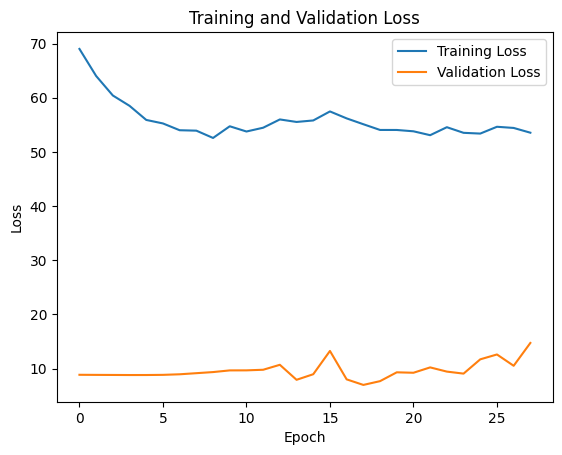

Fold 1 Results:
   Accuracy: 0.7778
   Average Sensitivity (Recall): 0.9024
   Average Specificity: 0.5455

Fold 2/3


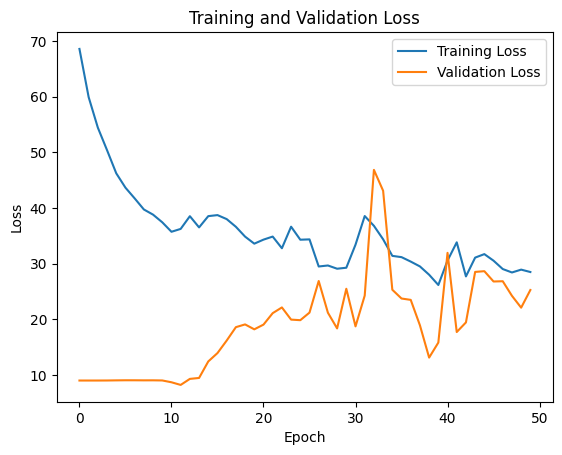

Fold 2 Results:
   Accuracy: 0.7302
   Average Sensitivity (Recall): 0.8333
   Average Specificity: 0.5238

Fold 3/3


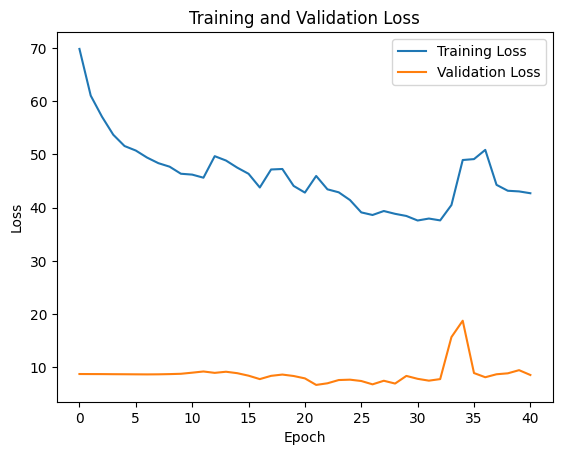

Fold 3 Results:
   Accuracy: 0.7903
   Average Sensitivity (Recall): 0.9286
   Average Specificity: 0.5000

Cross-Validation Results:
accuracy: Mean = 0.7661 ± 0.03
sensitivity: Mean = 0.8881 ± 0.04
specificity: Mean = 0.5231 ± 0.02
epochs: Mean = 39.6667 ± 9.03
training_times: Mean = 1.9958 ± 0.82
testing_times: Mean = 0.0244 ± 0.02
avg_memory_usage: Mean = 4.5809 ± 0.00
avg_gpu_usage: Mean = 0.0168 ± 0.00
max_memory_usage: Mean = 4.5809 ± 0.00
max_gpu_usage: Mean = 0.0168 ± 0.00


In [44]:
set_seed(42)
gat3_mutag = GAT3Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes).to(device)
print(gat3_mutag)
print(f"Total number of trainable parameters: {(gat3_mutag.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat3_mutag, mutag_dataset, 
            lr=0.01, num_epochs=500, step_size=100,  
            save_path='models/gat_3l_mutag.pth')

GAT4Layer(
  (gat1): GAT (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GAT (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat3): GAT (28 -> 42)
  (bn3): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat4): GAT (42 -> 28)
  (bn4): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 3460


Fold 1/3


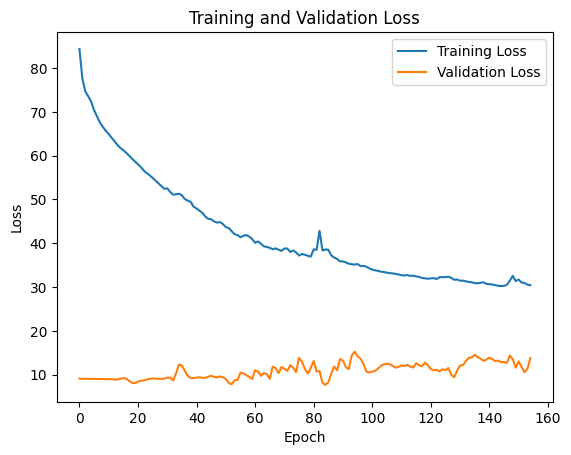

Fold 1 Results:
   Accuracy: 0.7619
   Average Sensitivity (Recall): 0.9512
   Average Specificity: 0.4091

Fold 2/3


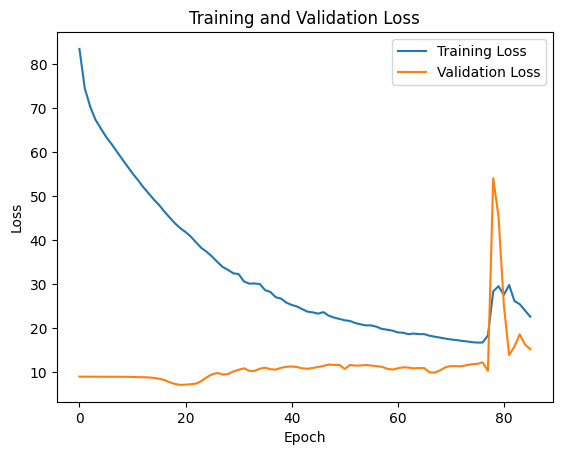

Fold 2 Results:
   Accuracy: 0.6984
   Average Sensitivity (Recall): 0.8333
   Average Specificity: 0.4286

Fold 3/3


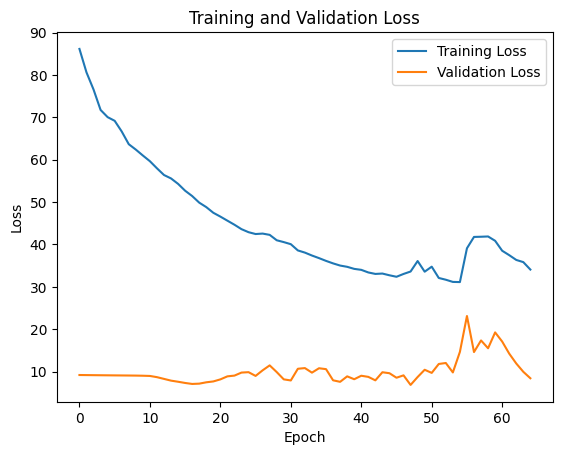

Fold 3 Results:
   Accuracy: 0.7903
   Average Sensitivity (Recall): 0.8810
   Average Specificity: 0.6000

Cross-Validation Results:
accuracy: Mean = 0.7502 ± 0.04
sensitivity: Mean = 0.8885 ± 0.05
specificity: Mean = 0.4792 ± 0.09
epochs: Mean = 102.0000 ± 38.44
training_times: Mean = 4.9305 ± 1.19
testing_times: Mean = 0.0127 ± 0.00
avg_memory_usage: Mean = 4.5809 ± 0.00
avg_gpu_usage: Mean = 0.0169 ± 0.00
max_memory_usage: Mean = 4.5809 ± 0.00
max_gpu_usage: Mean = 0.0169 ± 0.00


In [49]:
set_seed(42)
gat4_mutag = GAT4Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes).to(device)
print(gat4_mutag)
print(f"Total number of trainable parameters: {(gat4_mutag.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat4_mutag, mutag_dataset, 
            lr=0.001, num_epochs=500, step_size=100,  
            save_path='models/gat_4l_mutag.pth')

GAT5Layer(
  (gat1): GAT (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GAT (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat3): GAT (28 -> 42)
  (bn3): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat4): GAT (42 -> 28)
  (bn4): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat5): GAT (28 -> 14)
  (bn5): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 3894


Fold 1/3


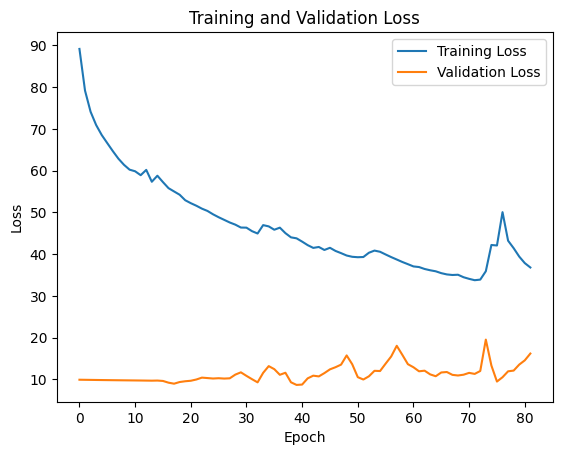

Fold 1 Results:
   Accuracy: 0.7937
   Average Sensitivity (Recall): 0.9756
   Average Specificity: 0.4545

Fold 2/3


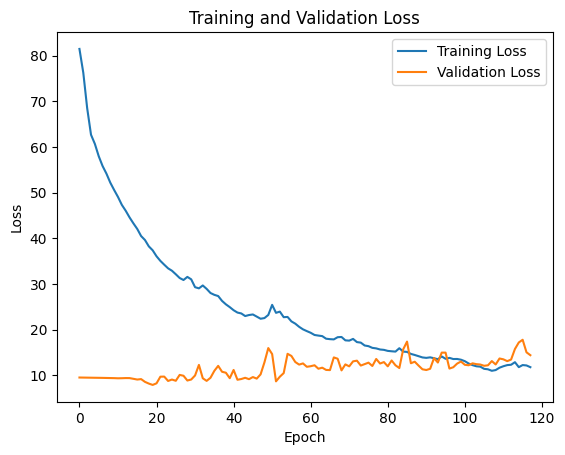

Fold 2 Results:
   Accuracy: 0.7302
   Average Sensitivity (Recall): 0.7857
   Average Specificity: 0.6190

Fold 3/3


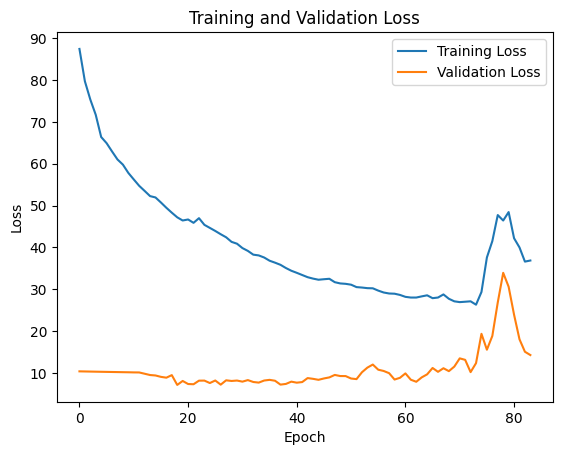

Fold 3 Results:
   Accuracy: 0.7581
   Average Sensitivity (Recall): 0.9048
   Average Specificity: 0.4500

Cross-Validation Results:
accuracy: Mean = 0.7606 ± 0.03
sensitivity: Mean = 0.8887 ± 0.08
specificity: Mean = 0.5079 ± 0.08
epochs: Mean = 94.6667 ± 16.52
training_times: Mean = 5.4805 ± 1.29
testing_times: Mean = 0.0146 ± 0.00
avg_memory_usage: Mean = 4.5809 ± 0.00
avg_gpu_usage: Mean = 0.0169 ± 0.00
max_memory_usage: Mean = 4.5809 ± 0.00
max_gpu_usage: Mean = 0.0169 ± 0.00


In [48]:
set_seed(42)
gat5_mutag = GAT5Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes).to(device)
print(gat5_mutag)
print(f"Total number of trainable parameters: {(gat5_mutag.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat5_mutag, mutag_dataset, 
            lr=0.001, num_epochs=500, step_size=100,  
            save_path='models/gat_5l_mutag.pth')

## GCN

GCN1Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 170


Fold 1/3


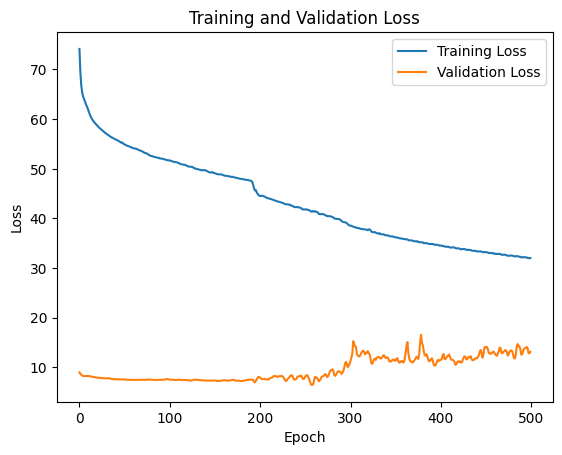

Fold 1 Results:
   Accuracy: 0.7619
   Average Sensitivity (Recall): 1.0000
   Average Specificity: 0.3182

Fold 2/3


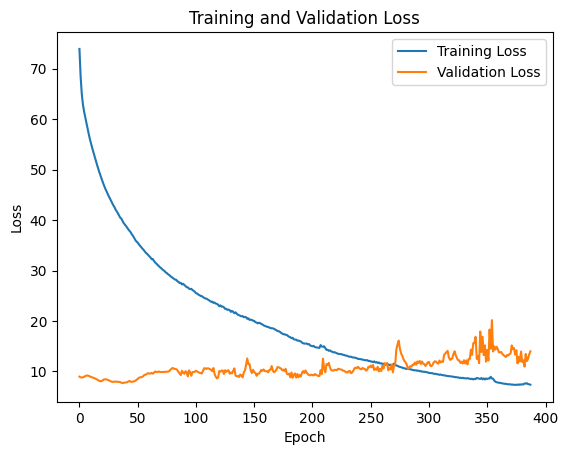

Fold 2 Results:
   Accuracy: 0.7302
   Average Sensitivity (Recall): 0.8571
   Average Specificity: 0.4762

Fold 3/3


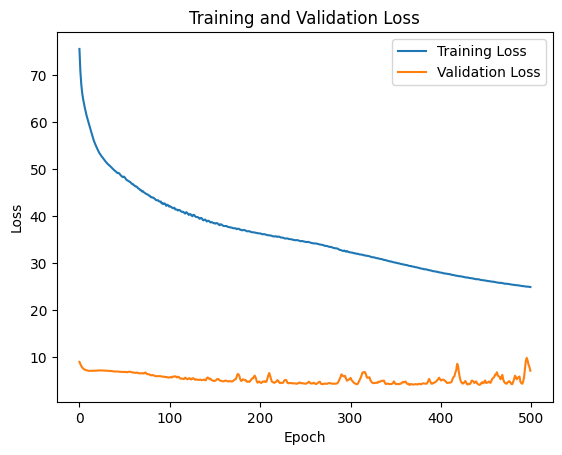

Fold 3 Results:
   Accuracy: 0.7581
   Average Sensitivity (Recall): 0.6667
   Average Specificity: 0.9500

Cross-Validation Results:
accuracy: Mean = 0.7500 ± 0.01
sensitivity: Mean = 0.8413 ± 0.14
specificity: Mean = 0.5815 ± 0.27
epochs: Mean = 462.0000 ± 52.33
training_times: Mean = 11.5699 ± 1.36
testing_times: Mean = 0.0117 ± 0.00
avg_memory_usage: Mean = 3.1265 ± 0.00
avg_gpu_usage: Mean = 0.0162 ± 0.00
max_memory_usage: Mean = 3.1266 ± 0.00
max_gpu_usage: Mean = 0.0162 ± 0.00


In [7]:
set_seed(42)
gcn1_mutag = GCN1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes).to(device)
print(gcn1_mutag)
print(f"Total number of trainable parameters: {(gcn1_mutag.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn1_mutag, mutag_dataset, 
            lr=0.005, num_epochs=500, step_size=500,  
            save_path='models/gcn_1l_mutag.pth')

GCN2Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 674


Fold 1/3


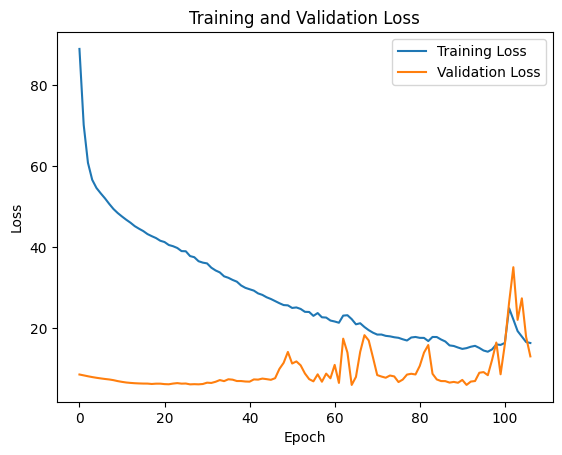

Fold 1 Results:
   Accuracy: 0.8254
   Average Sensitivity (Recall): 0.9512
   Average Specificity: 0.5909

Fold 2/3


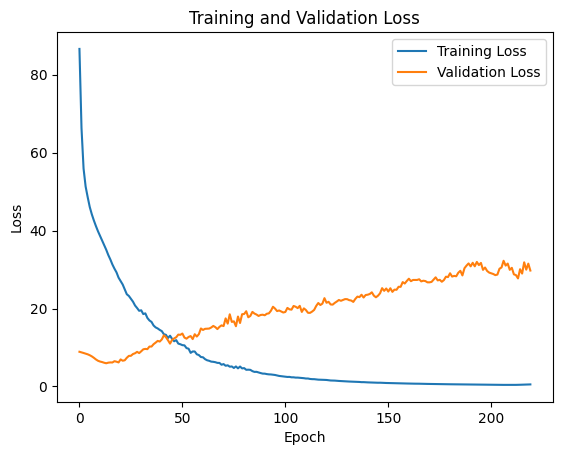

Fold 2 Results:
   Accuracy: 0.7778
   Average Sensitivity (Recall): 0.8095
   Average Specificity: 0.7143

Fold 3/3


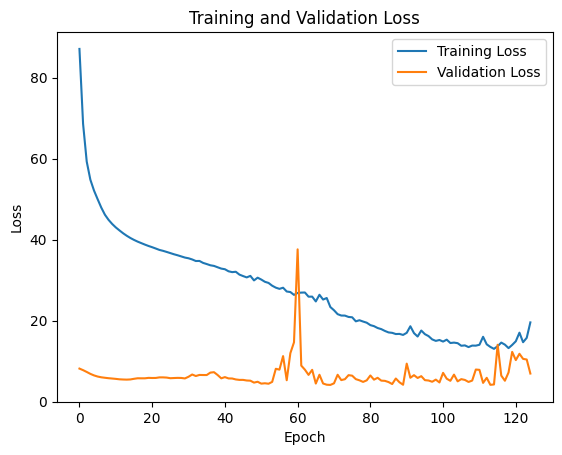

Fold 3 Results:
   Accuracy: 0.9032
   Average Sensitivity (Recall): 1.0000
   Average Specificity: 0.7000

Cross-Validation Results:
accuracy: Mean = 0.8355 ± 0.05
sensitivity: Mean = 0.9202 ± 0.08
specificity: Mean = 0.6684 ± 0.06
epochs: Mean = 150.6667 ± 49.57
training_times: Mean = 2.3746 ± 0.76
testing_times: Mean = 0.0070 ± 0.00
avg_memory_usage: Mean = 4.5833 ± 0.00
avg_gpu_usage: Mean = 0.0189 ± 0.00
max_memory_usage: Mean = 4.5833 ± 0.00
max_gpu_usage: Mean = 0.0189 ± 0.00


In [20]:
set_seed(42)
gcn2_mutag = GCN2Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn2_mutag)
print(f"Total number of trainable parameters: {(gcn2_mutag.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn2_mutag, mutag_dataset, 
            lr=0.005, num_epochs=500, step_size=500, 
            save_path='models/gcn_2l_mutag.pth')

In [18]:
set_seed(42)
gcn3_mutag = GCN3Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn3_mutag)
print(f"Total number of trainable parameters: {(gcn3_mutag.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn3_mutag, mutag_dataset, 
            lr=0.01, num_epochs=500, step_size=500, 
            save_path='models/gcn_3l_mutag.pth')

GCN3Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (28 -> 14)
  (bn3): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 1080


Fold 1/3
Fold 1 Results:
   Accuracy: 0.8413
   Average Sensitivity (Recall): 0.9512
   Average Specificity: 0.6364

Fold 2/3
Fold 2 Results:
   Accuracy: 0.8254
   Average Sensitivity (Recall): 0.8810
   Average Specificity: 0.7143

Fold 3/3
Fold 3 Results:
   Accuracy: 0.8226
   Average Sensitivity (Recall): 0.8095
   Average Specificity: 0.8500

Cross-Validation Results:
accuracy: Mean = 0.8297, Std = 0.01
sensitivity: Mean = 0.8806, Std = 0.06
specificity: Mean = 0.7335, Std = 0.09
epochs: Mean = 203.0000, Std = 210.50
training_times

In [19]:
set_seed(42)
gcn4_mutag = GCN4Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn4_mutag)
print(f"Total number of trainable parameters: {(gcn4_mutag.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn4_mutag, mutag_dataset, 
            lr=0.01, num_epochs=500, step_size=500, 
            save_path='models/gcn_4l_mutag.pth')

GCN4Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (28 -> 42)
  (bn3): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (42 -> 28)
  (bn4): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 3236


Fold 1/3
Fold 1 Results:
   Accuracy: 0.8413
   Average Sensitivity (Recall): 0.9756
   Average Specificity: 0.5909

Fold 2/3
Fold 2 Results:
   Accuracy: 0.7778
   Average Sensitivity (Recall): 0.8095
   Average Specificity: 0.7143

Fold 3/3
Fold 3 Results:
   Accuracy: 0.7742
   Average Sensitivity (Recall): 0.8333
   Average Specificity: 0.6500

Cross-Validation Results:
accuracy: Mean = 0.7977, Std = 0.03
sensitivity: Mea

In [20]:
set_seed(42)
gcn5_mutag = GCN5Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn5_mutag)
print(f"Total number of trainable parameters: {(gcn5_mutag.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn5_mutag, mutag_dataset, 
            lr=0.01, num_epochs=500, step_size=500, 
            save_path='models/gcn_5l_mutag.pth')

GCN5Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (28 -> 42)
  (bn3): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (42 -> 28)
  (bn4): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn5): GCN (28 -> 14)
  (bn5): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 3642


Fold 1/3
Fold 1 Results:
   Accuracy: 0.7778
   Average Sensitivity (Recall): 1.0000
   Average Specificity: 0.3636

Fold 2/3
Fold 2 Results:
   Accuracy: 0.7937
   Average Sensitivity (Recall): 0.7381
   Average Specificity: 0.9048

Fold 3/3
Fold 3 Results:
   Accuracy: 0.7903
   Average Sensitivity (Recall): 0.8

## GCESN

In [39]:
set_seed(42)
gcesn_mutag = GCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=2)
print(gcesn_mutag)
print(f"Total number of trainable parameters: {gcesn_mutag.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_mutag, mutag_dataset,
                lr=0.01, num_epochs=500, step_size=100, gamma=0.5, 
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_1l_mutag.pth')


GCESN_1layer(
  (fc1): Linear(in_features=14, out_features=14, bias=True)
  (bn): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 268


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.8730
   Average Sensitivity (Recall): 0.9512
   Average Specificity: 0.7273
Fold 2/3
Fold 2 Results:
   Accuracy: 0.8254
   Average Sensitivity (Recall): 0.8571
   Average Specificity: 0.7619
Fold 3/3
Fold 3 Results:
   Accuracy: 0.8387
   Average Sensitivity (Recall): 0.9048
   Average Specificity: 0.7000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.8457, Std = 0.0201
sensitivity: Mean = 0.9044, Std = 0.0384
specificity: Mean = 0.7297, Std = 0.0253

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.8095
   Average Sensitivity (Recall): 0.9512
   Average Specificity: 0.5455
Fold 2/3
Fold 2 Results:
   Accuracy: 0.8254
   Average Sensitivity (Recall): 0.8333
   Average Speci

In [47]:
gcesn_mutag_2 = GCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_mutag_2)
print(f"Total number of trainable parameters: {gcesn_mutag_2.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_mutag_2, mutag_dataset,
                lr=0.005, num_epochs=500, step_size=100, 
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_2l_mutag.pth')

GCESN_2layer(
  (fc1): Linear(in_features=14, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=28, bias=True)
  (bn): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 1346


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.8889
   Average Sensitivity (Recall): 0.9756
   Average Specificity: 0.7273
Fold 2/3
Fold 2 Results:
   Accuracy: 0.8095
   Average Sensitivity (Recall): 0.8095
   Average Specificity: 0.8095
Fold 3/3
Fold 3 Results:
   Accuracy: 0.8871
   Average Sensitivity (Recall): 0.8810
   Average Specificity: 0.9000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.8618, Std = 0.0370
sensitivity: Mean = 0.8887, Std = 0.0680
specificity: Mean = 0.8123, Std = 0.0705

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.8571
   Average Sensitivity (Recall): 0.9756
   Average Specificity: 0.6364
Fold 2/3
Fold 2 Results:
   Accuracy: 0.

In [41]:
gcesn_mutag_3 = GCESN_3layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_mutag_3)
print(f"Total number of trainable parameters: {gcesn_mutag_3.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_mutag_3, mutag_dataset,
                lr=0.005, num_epochs=500, step_size=100,  
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_3l_mutag.pth')

GCESN_3layer(
  (fc1): Linear(in_features=14, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=14, bias=True)
  (fc3): Linear(in_features=14, out_features=14, bias=True)
  (bn): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 1094


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.8254
   Average Sensitivity (Recall): 0.9756
   Average Specificity: 0.5455
Fold 2/3
Fold 2 Results:
   Accuracy: 0.7937
   Average Sensitivity (Recall): 0.7857
   Average Specificity: 0.8095
Fold 3/3
Fold 3 Results:
   Accuracy: 0.8387
   Average Sensitivity (Recall): 0.7857
   Average Specificity: 0.9500
Run 1 Cross-Validation Results:
accuracy: Mean = 0.8193, Std = 0.0189
sensitivity: Mean = 0.8490, Std = 0.0895
specificity: Mean = 0.7683, Std = 0.1677

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.8571
   Average Sensitivity (Recall): 0.9756
   Average 

In [45]:
gcesn_mutag_4 = GCESN_4layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_mutag_4)
print(f"Total number of trainable parameters: {gcesn_mutag_4.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_mutag_4, mutag_dataset,
                lr=0.005, num_epochs=500, step_size=100, 
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_4l_mutag.pth')

GCESN_4layer(
  (fc1): Linear(in_features=14, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=42, bias=True)
  (fc3): Linear(in_features=42, out_features=28, bias=True)
  (fc4): Linear(in_features=28, out_features=28, bias=True)
  (bn): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 3768


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.8095
   Average Sensitivity (Recall): 0.9756
   Average Specificity: 0.5000
Fold 2/3
Fold 2 Results:
   Accuracy: 0.8413
   Average Sensitivity (Recall): 0.8333
   Average Specificity: 0.8571
Fold 3/3
Fold 3 Results:
   Accuracy: 0.8065
   Average Sensitivity (Recall): 0.7381
   Average Specificity: 0.9500
Run 1 Cross-Validation Results:
accuracy: Mean = 0.8191, Std = 0.0157
sensitivity: Mean = 0.8490, Std = 0.0976
specificity: Mean = 0.7690, Std = 0.1940

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy

In [46]:
gcesn_mutag_5 = GCESN_5layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.8, num_iterations=1)
print(gcesn_mutag_5)
print(f"Total number of trainable parameters: {gcesn_mutag_5.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_mutag_5, mutag_dataset,
                lr=0.005, num_epochs=500, step_size=100,
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_5l_mutag.pth')

GCESN_5layer(
  (fc1): Linear(in_features=14, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=42, bias=True)
  (fc3): Linear(in_features=42, out_features=28, bias=True)
  (fc4): Linear(in_features=28, out_features=14, bias=True)
  (fc5): Linear(in_features=14, out_features=14, bias=True)
  (bn): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 3516


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.8413
   Average Sensitivity (Recall): 0.9512
   Average Specificity: 0.6364
Fold 2/3
Fold 2 Results:
   Accuracy: 0.7778
   Average Sensitivity (Recall): 0.8571
   Average Specificity: 0.6190
Fold 3/3
Fold 3 Results:
   Accuracy: 0.8226
   Average Sensitivity (Recall): 0.7619
   Average Specificity: 0.9500
Run 1 Cross-Validation Results:
accuracy: Mean = 0.8139, Std = 0.0266
sensitivity: Mean = 0.8568, Std = 0.0773
specificity: Mean = 0.7351

## TGCESN

In [48]:
set_seed(42)
trainable_gcesn_mutag = TrainableGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, 
                        leaky_rate=0.9, num_iterations=2)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_mutag, mutag_dataset,
                lr=0.001, num_epochs=500, step_size=500,
                save_path='models/trainable_gcesn_1l_mutag.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 562


Fold 1/3
Fold 1 Results:
   Accuracy: 0.9206
   Average Sensitivity (Recall): 0.9756
   Average Specificity: 0.8182

Fold 2/3
Fold 2 Results:
   Accuracy: 0.7937
   Average Sensitivity (Recall): 0.8333
   Average Specificity: 0.7143

Fold 3/3
Fold 3 Results:
   Accuracy: 0.8548
   Average Sensitivity (Recall): 0.9524
   Average Specificity: 0.6500

Cross-Validation Results:
accuracy: Mean = 0.8564, Std = 0.05
sensitivity: Mean = 0.9204, Std = 0.06
specificity: Mean = 0.7275, Std = 0.07
epochs: Mean = 492.0000, Std = 9.20
training_times: Mean = 21.1765, Std = 0.66
testing_times: Mean = 0.0122, Std = 0.00
avg_memory_usage: Mean = 4.1959, Std = 0.00
avg_gpu_usage: Mean = 0.0176, Std = 0.00
max_memory_usage: Mean = 4.1959, Std = 0.00
max_gpu_usage: Mean = 0.0176, Std = 0.00


In [62]:
set_seed(42)
trainable_gcesn_mutag_2 = TrainableGCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes,
                        leaky_rate=0.9, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag_2.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_mutag_2, mutag_dataset,
                lr=0.005, num_epochs=500, step_size=500,  
                save_path='models/trainable_gcesn_2l_mutag.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 1962


Fold 1/3
Fold 1 Results:
   Accuracy: 0.8730
   Average Sensitivity (Recall): 0.9268
   Average Specificity: 0.7727

Fold 2/3
Fold 2 Results:
   Accuracy: 0.7302
   Average Sensitivity (Recall): 0.9524
   Average Specificity: 0.2857

Fold 3/3
Fold 3 Results:
   Accuracy: 0.9355
   Average Sensitivity (Recall): 0.9762
   Average Specificity: 0.8500

Cross-Validation Results:
accuracy: Mean = 0.8462, Std = 0.09
sensitivity: Mean = 0.9518, Std = 0.02
specificity: Mean = 0.6361, Std = 0.25
epochs: Mean = 101.0000, Std = 13.95
training_times: Mean = 5.3856, Std = 0.88
testing_times: Mean = 0.0120, Std = 0.00
avg_memory_usage: Mean = 4.1964, Std = 0.00
avg_gpu_usage: Mean = 0.0176, Std = 0.00
max_memory_usage: Mean = 4.1964, Std = 0.00
max_gpu_usage: Mean = 0.0176, Std = 0.00


In [52]:
set_seed(42)
trainable_gcesn_mutag_3 = TrainableGCESN_3layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, 
                leaky_rate=0.9, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag_3.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_mutag_3, mutag_dataset,
                lr=0.01, num_epochs=500, step_size=500,  
                save_path='models/trainable_gcesn_2l_mutag.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 2368


Fold 1/3
Fold 1 Results:
   Accuracy: 0.7778
   Average Sensitivity (Recall): 1.0000
   Average Specificity: 0.3636

Fold 2/3
Fold 2 Results:
   Accuracy: 0.8413
   Average Sensitivity (Recall): 0.8333
   Average Specificity: 0.8571

Fold 3/3
Fold 3 Results:
   Accuracy: 0.9194
   Average Sensitivity (Recall): 0.9286
   Average Specificity: 0.9000

Cross-Validation Results:
accuracy: Mean = 0.8461, Std = 0.06
sensitivity: Mean = 0.9206, Std = 0.07
specificity: Mean = 0.7069, Std = 0.24
epochs: Mean = 98.6667, Std = 16.13
training_times: Mean = 6.0703, Std = 0.96
testing_times: Mean = 0.0116, Std = 0.00
avg_memory_usage: Mean = 4.1959, Std = 0.00
avg_gpu_usage: Mean = 0.0176, Std = 0.00
max_memory_usage: Mean = 4.1959, Std = 0.00
max_gpu_usage: Mean = 0.0176, Std = 0.00


In [59]:
set_seed(42)
trainable_gcesn_mutag_4 = TrainableGCESN_4layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, 
                        leaky_rate=0.9, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag_4.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_mutag_4, mutag_dataset,
                lr=0.001, num_epochs=500, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_4l_mutag.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 7394


Fold 1/3
Fold 1 Results:
   Accuracy: 0.8571
   Average Sensitivity (Recall): 1.0000
   Average Specificity: 0.5909

Fold 2/3
Fold 2 Results:
   Accuracy: 0.8095
   Average Sensitivity (Recall): 0.7857
   Average Specificity: 0.8571

Fold 3/3
Fold 3 Results:
   Accuracy: 0.8548
   Average Sensitivity (Recall): 0.8810
   Average Specificity: 0.8000

Cross-Validation Results:
accuracy: Mean = 0.8405, Std = 0.02
sensitivity: Mean = 0.8889, Std = 0.09
specificity: Mean = 0.7494, Std = 0.11
epochs: Mean = 127.0000, Std = 34.07
training_times: Mean = 11.3961, Std = 4.26
testing_times: Mean = 0.0101, Std = 0.00
avg_memory_usage: Mean = 4.1959, Std = 0.00
avg_gpu_usage: Mean = 0.0177, Std = 0.00
max_memory_usage: Mean = 4.1959, Std = 0.00
max_gpu_usage: Mean = 0.0177, Std = 0.00


In [61]:
set_seed(42)
trainable_gcesn_mutag_5 = TrainableGCESN_5layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, 
                        leaky_rate=0.8, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag_5.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_mutag_5, mutag_dataset,
                lr=0.0005, num_epochs=500, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_5l_mutag.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 7338


Fold 1/3
Fold 1 Results:
   Accuracy: 0.9048
   Average Sensitivity (Recall): 0.9512
   Average Specificity: 0.8182

Fold 2/3
Fold 2 Results:
   Accuracy: 0.7619
   Average Sensitivity (Recall): 0.8095
   Average Specificity: 0.6667

Fold 3/3
Fold 3 Results:
   Accuracy: 0.8226
   Average Sensitivity (Recall): 0.8095
   Average Specificity: 0.8500

Cross-Validation Results:
accuracy: Mean = 0.8297, Std = 0.06
sensitivity: Mean = 0.8568, Std = 0.07
specificity: Mean = 0.7783, Std = 0.08
epochs: Mean = 386.3333, Std = 160.75
training_times: Mean = 43.7128, Std = 18.12
testing_times: Mean = 0.0114, Std = 0.00
avg_memory_usage: Mean = 4.1964, Std = 0.00
avg_gpu_usage: Mean = 0.0177, Std = 0.00
max_memory_usage: Mean = 4.1964, Std = 0.00
max_gpu_usage: Mean = 0.0177, Std = 0.00


# PROTEINS

## GAT

GAT1Layer(
  (gat1): GAT (4 -> 24)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=24, out_features=2, bias=True)
)
Total number of trainable parameters: 266


Fold 1/3


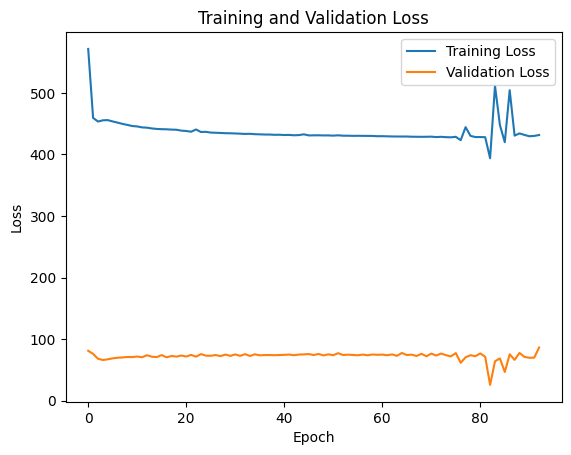

Fold 1 Results:
   Accuracy: 0.3747
   Average Sensitivity (Recall): 0.8623
   Average Specificity: 0.0858

Fold 2/3


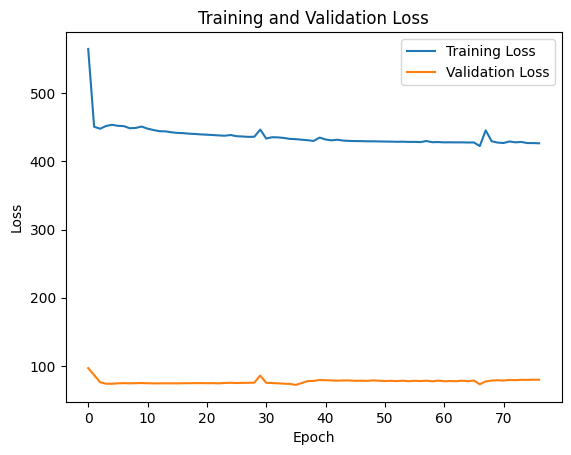

Fold 2 Results:
   Accuracy: 0.6388
   Average Sensitivity (Recall): 0.1429
   Average Specificity: 0.9643

Fold 3/3


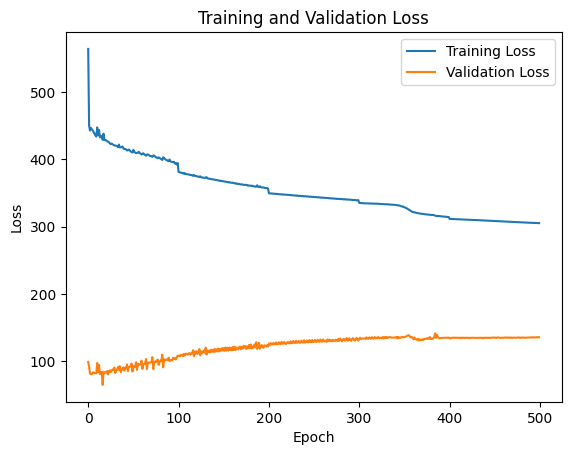

Fold 3 Results:
   Accuracy: 0.5553
   Average Sensitivity (Recall): 0.0061
   Average Specificity: 0.9951

Cross-Validation Results:
accuracy: Mean = 0.5229 ± 0.11
sensitivity: Mean = 0.3371 ± 0.38
specificity: Mean = 0.6818 ± 0.42
epochs: Mean = 223.3333 ± 195.74
training_times: Mean = 53.6931 ± 46.09
testing_times: Mean = 0.0788 ± 0.02
avg_memory_usage: Mean = 4.5902 ± 0.00
avg_gpu_usage: Mean = 0.0173 ± 0.00
max_memory_usage: Mean = 4.5902 ± 0.00
max_gpu_usage: Mean = 0.0173 ± 0.00


In [50]:
set_seed(42)
gat1_proteins = GAT1Layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes).to(device)
print(gat1_proteins)
print(f"Total number of trainable parameters: {(gat1_proteins.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat1_proteins, proteins_dataset, 
            lr=0.005, num_epochs=500, step_size=100,  
            save_path='models/gat_1l_proteins.pth')

GAT2Layer(
  (gat1): GAT (4 -> 24)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GAT (24 -> 48)
  (bn2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=48, out_features=2, bias=True)
)
Total number of trainable parameters: 1706


Fold 1/3


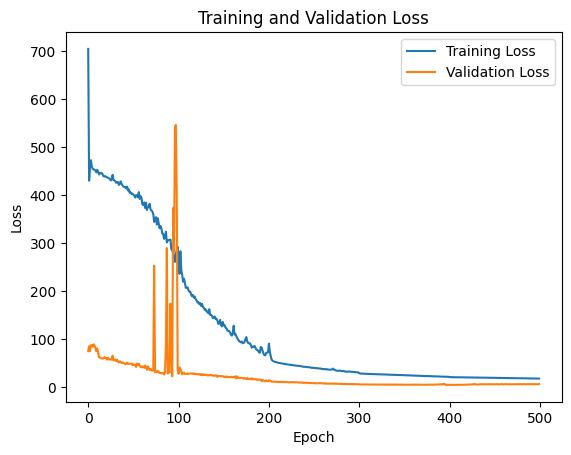

Fold 1 Results:
   Accuracy: 0.3774
   Average Sensitivity (Recall): 0.9928
   Average Specificity: 0.0129

Fold 2/3


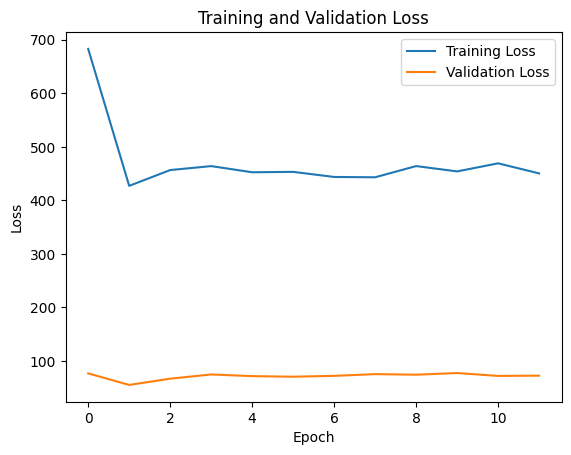

Fold 2 Results:
   Accuracy: 0.5687
   Average Sensitivity (Recall): 0.2313
   Average Specificity: 0.7902

Fold 3/3


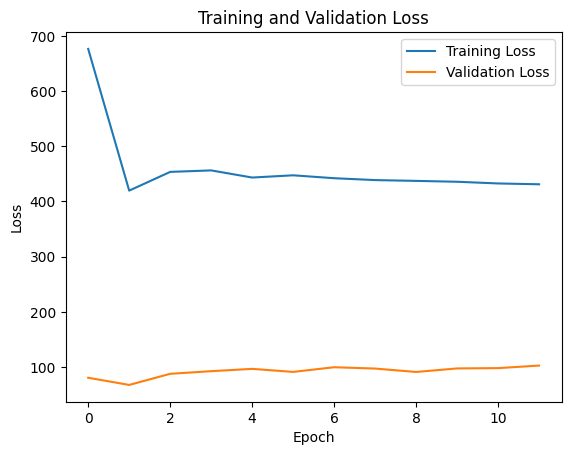

Fold 3 Results:
   Accuracy: 0.5553
   Average Sensitivity (Recall): 0.0061
   Average Specificity: 0.9951

Cross-Validation Results:
accuracy: Mean = 0.5004 ± 0.09
sensitivity: Mean = 0.4100 ± 0.42
specificity: Mean = 0.5994 ± 0.42
epochs: Mean = 174.3333 ± 229.57
training_times: Mean = 89.4733 ± 117.21
testing_times: Mean = 0.1681 ± 0.05
avg_memory_usage: Mean = 4.5909 ± 0.00
avg_gpu_usage: Mean = 0.0174 ± 0.00
max_memory_usage: Mean = 4.5910 ± 0.00
max_gpu_usage: Mean = 0.0174 ± 0.00


In [51]:
set_seed(42)
gat2_proteins = GAT2Layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes).to(device)
print(gat2_proteins)
print(f"Total number of trainable parameters: {(gat2_proteins.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat2_proteins, proteins_dataset, 
            lr=0.005, num_epochs=500, step_size=100,  
            save_path='models/gat_2l_proteins.pth')

GAT3Layer(
  (gat1): GAT (4 -> 24)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GAT (24 -> 48)
  (bn2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat3): GAT (48 -> 24)
  (bn3): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=24, out_features=2, bias=True)
)
Total number of trainable parameters: 2930


Fold 1/3


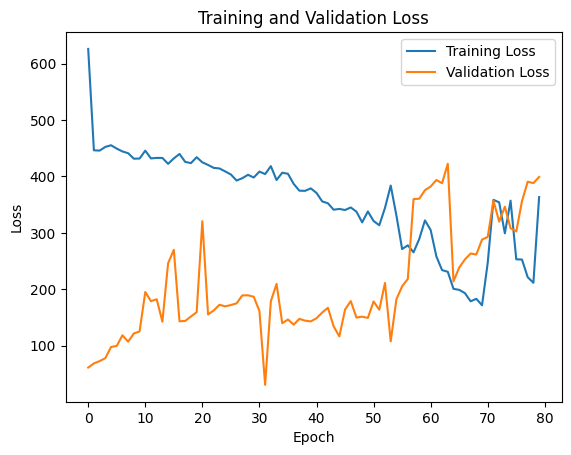

Fold 1 Results:
   Accuracy: 0.3908
   Average Sensitivity (Recall): 0.8551
   Average Specificity: 0.1159

Fold 2/3


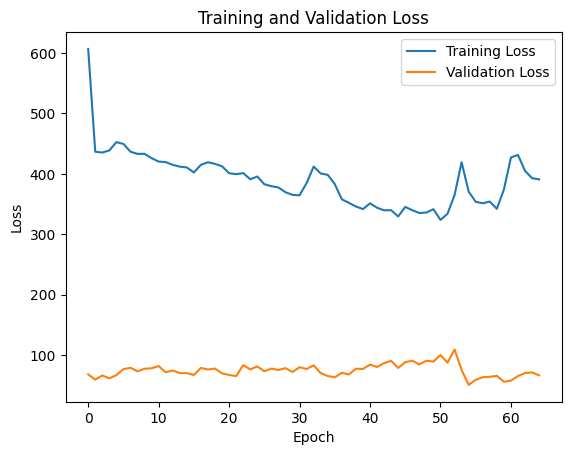

Fold 2 Results:
   Accuracy: 0.6226
   Average Sensitivity (Recall): 0.2517
   Average Specificity: 0.8661

Fold 3/3


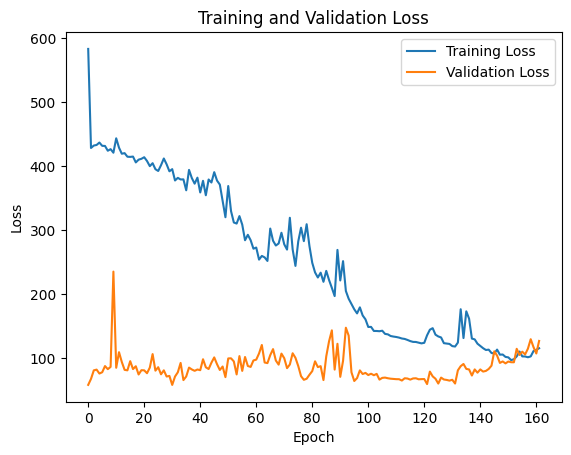

Fold 3 Results:
   Accuracy: 0.4582
   Average Sensitivity (Recall): 0.7879
   Average Specificity: 0.1942

Cross-Validation Results:
accuracy: Mean = 0.4906 ± 0.10
sensitivity: Mean = 0.6316 ± 0.27
specificity: Mean = 0.3920 ± 0.34
epochs: Mean = 102.3333 ± 42.63
training_times: Mean = 69.8459 ± 28.10
testing_times: Mean = 0.1897 ± 0.05
avg_memory_usage: Mean = 4.5918 ± 0.00
avg_gpu_usage: Mean = 0.0174 ± 0.00
max_memory_usage: Mean = 4.5918 ± 0.00
max_gpu_usage: Mean = 0.0174 ± 0.00


In [52]:
set_seed(42)
gat3_proteins = GAT3Layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes).to(device)
print(gat3_proteins)
print(f"Total number of trainable parameters: {(gat3_proteins.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat3_proteins, proteins_dataset, 
            lr=0.005, num_epochs=500, step_size=100,  
            save_path='models/gat_3l_proteins.pth')

GAT4Layer(
  (gat1): GAT (4 -> 24)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GAT (24 -> 48)
  (bn2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat3): GAT (48 -> 72)
  (bn3): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat4): GAT (72 -> 48)
  (bn4): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=48, out_features=2, bias=True)
)
Total number of trainable parameters: 9218


Fold 1/3


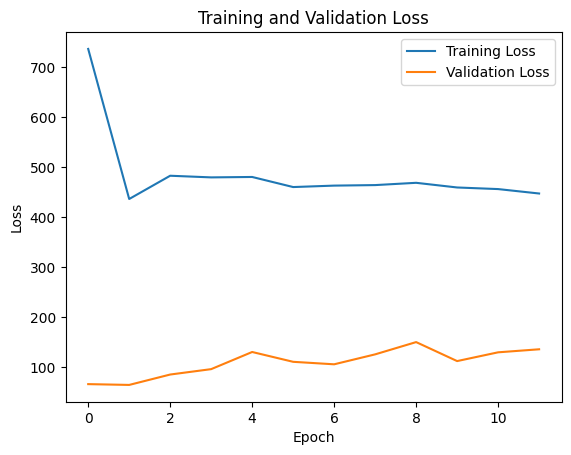

Fold 1 Results:
   Accuracy: 0.6199
   Average Sensitivity (Recall): 0.2391
   Average Specificity: 0.8455

Fold 2/3


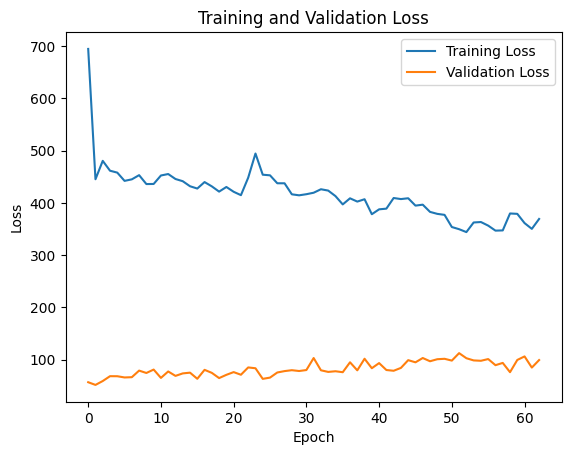

Fold 2 Results:
   Accuracy: 0.6307
   Average Sensitivity (Recall): 0.0884
   Average Specificity: 0.9866

Fold 3/3


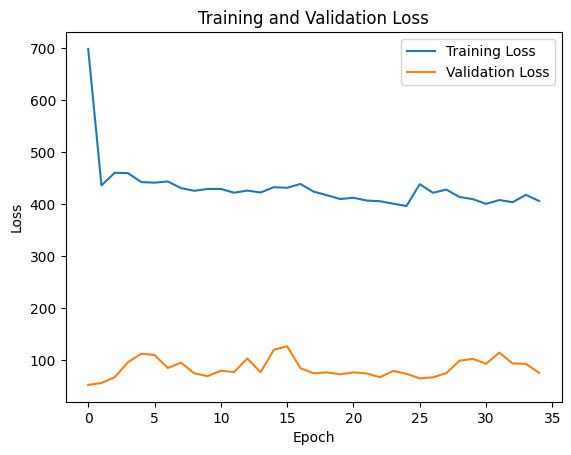

Fold 3 Results:
   Accuracy: 0.5741
   Average Sensitivity (Recall): 0.0727
   Average Specificity: 0.9757

Cross-Validation Results:
accuracy: Mean = 0.6083 ± 0.02
sensitivity: Mean = 0.1334 ± 0.08
specificity: Mean = 0.9359 ± 0.06
epochs: Mean = 36.6667 ± 20.85
training_times: Mean = 43.4689 ± 24.78
testing_times: Mean = 0.2719 ± 0.02
avg_memory_usage: Mean = 4.5925 ± 0.00
avg_gpu_usage: Mean = 0.0176 ± 0.00
max_memory_usage: Mean = 4.5925 ± 0.00
max_gpu_usage: Mean = 0.0176 ± 0.00


In [53]:
set_seed(42)
gat4_proteins = GAT4Layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes).to(device)
print(gat4_proteins)
print(f"Total number of trainable parameters: {(gat4_proteins.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat4_proteins, proteins_dataset, 
            lr=0.005, num_epochs=500, step_size=100,  
            save_path='models/gat_4l_proteins.pth')

GAT5Layer(
  (gat1): GAT (4 -> 24)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GAT (24 -> 48)
  (bn2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat3): GAT (48 -> 72)
  (bn3): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat4): GAT (72 -> 48)
  (bn4): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat5): GAT (48 -> 24)
  (bn5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=24, out_features=2, bias=True)
)
Total number of trainable parameters: 10442


Fold 1/3


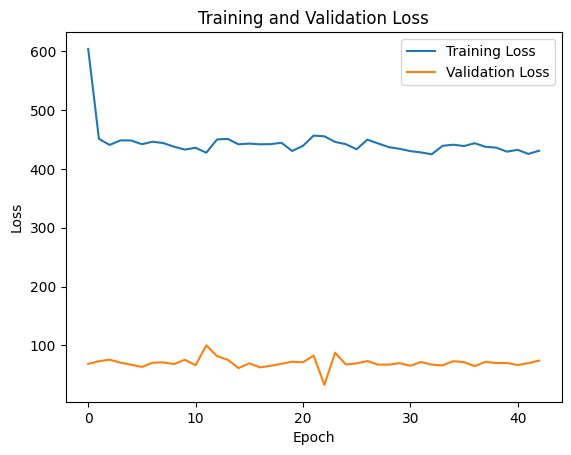

Fold 1 Results:
   Accuracy: 0.6119
   Average Sensitivity (Recall): 0.0652
   Average Specificity: 0.9356

Fold 2/3


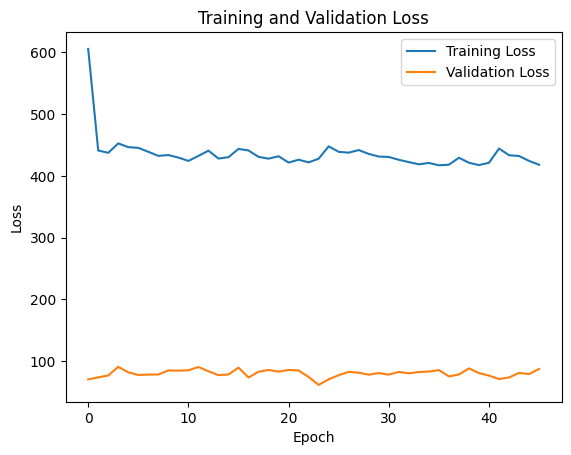

Fold 2 Results:
   Accuracy: 0.6065
   Average Sensitivity (Recall): 0.0408
   Average Specificity: 0.9777

Fold 3/3


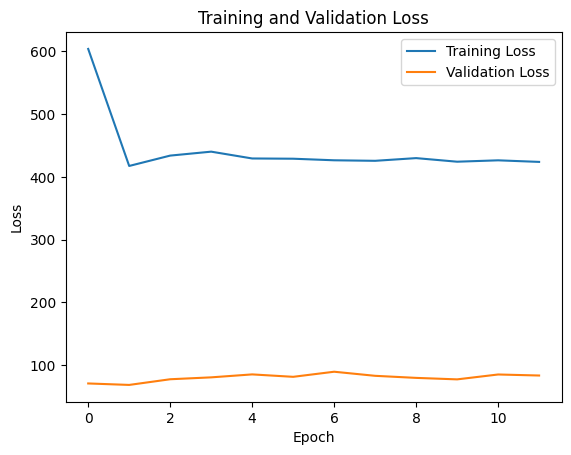

Fold 3 Results:
   Accuracy: 0.5660
   Average Sensitivity (Recall): 0.0364
   Average Specificity: 0.9903

Cross-Validation Results:
accuracy: Mean = 0.5948 ± 0.02
sensitivity: Mean = 0.0475 ± 0.01
specificity: Mean = 0.9679 ± 0.02
epochs: Mean = 33.6667 ± 15.37
training_times: Mean = 44.4725 ± 20.06
testing_times: Mean = 0.2876 ± 0.02
avg_memory_usage: Mean = 4.5931 ± 0.00
avg_gpu_usage: Mean = 0.0176 ± 0.00
max_memory_usage: Mean = 4.5931 ± 0.00
max_gpu_usage: Mean = 0.0176 ± 0.00


In [54]:
set_seed(42)
gat5_proteins = GAT5Layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes).to(device)
print(gat5_proteins)
print(f"Total number of trainable parameters: {(gat5_proteins.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat5_proteins, proteins_dataset, 
            lr=0.005, num_epochs=500, step_size=100,  
            save_path='models/gat_5l_proteins.pth')

## GCN

GCN1Layer(
  (gcn1): GCN (4 -> 24)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=24, out_features=2, bias=True)
)
Total number of trainable parameters: 218


Fold 1/3


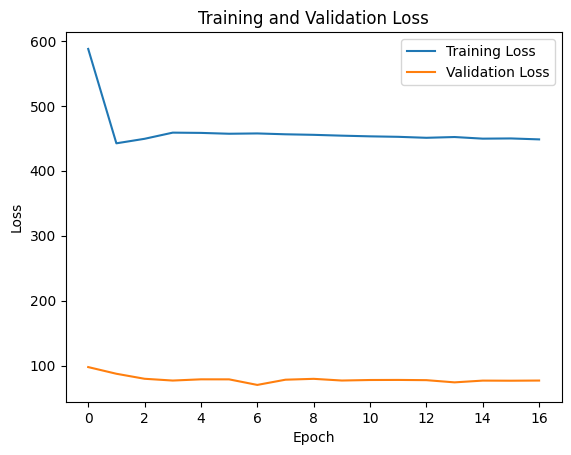

Fold 1 Results:
   Accuracy: 0.6361
   Average Sensitivity (Recall): 0.0652
   Average Specificity: 0.9742

Fold 2/3


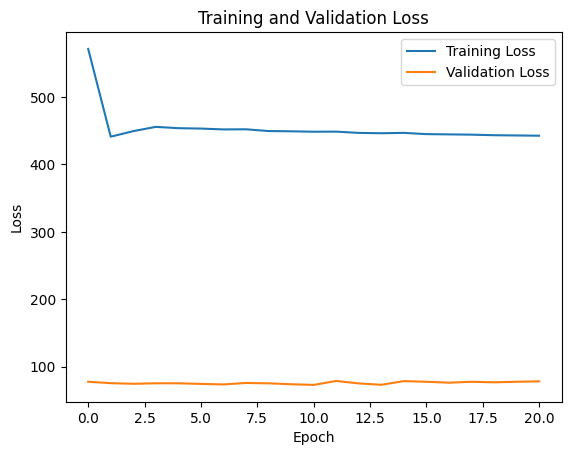

Fold 2 Results:
   Accuracy: 0.6146
   Average Sensitivity (Recall): 0.0272
   Average Specificity: 1.0000

Fold 3/3


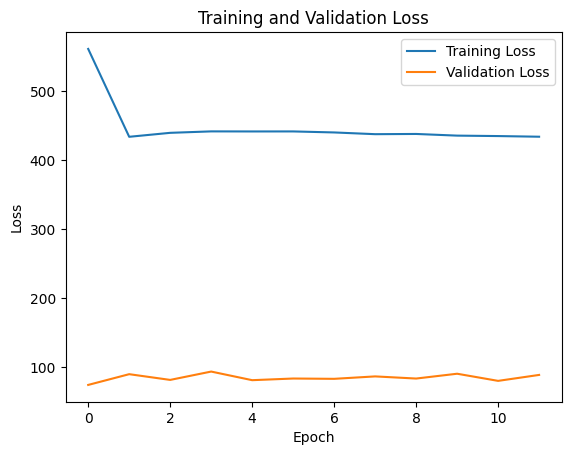

Fold 3 Results:
   Accuracy: 0.5553
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000

Cross-Validation Results:
accuracy: Mean = 0.6020 ± 0.03
sensitivity: Mean = 0.0308 ± 0.03
specificity: Mean = 0.9914 ± 0.01
epochs: Mean = 16.6667 ± 3.68
training_times: Mean = 1.1028 ± 0.24
testing_times: Mean = 0.0284 ± 0.00
avg_memory_usage: Mean = 4.8588 ± 0.00
avg_gpu_usage: Mean = 0.0208 ± 0.00
max_memory_usage: Mean = 4.8588 ± 0.00
max_gpu_usage: Mean = 0.0208 ± 0.00


In [10]:
set_seed(42)
gcn1_proteins = GCN1Layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes)
print(gcn1_proteins)
print(f"Total number of trainable parameters: {(gcn1_proteins.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn1_proteins, proteins_dataset, lr=0.005, 
            num_epochs=500, step_size=500, save_path='models/gcn_1l_proteins.pth')

GCN2Layer(
  (gcn1): GCN (4 -> 24)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (24 -> 48)
  (bn2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=48, out_features=2, bias=True)
)
Total number of trainable parameters: 1562


Fold 1/3


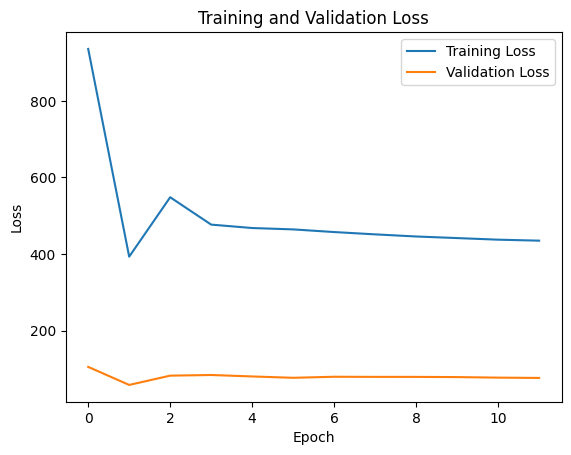

Fold 1 Results:
   Accuracy: 0.5957
   Average Sensitivity (Recall): 0.3116
   Average Specificity: 0.7639

Fold 2/3


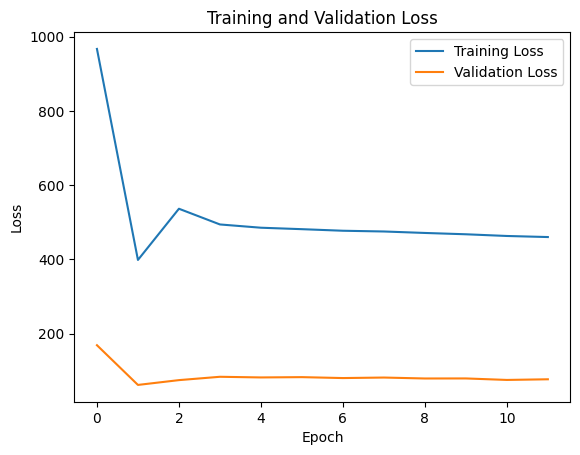

Fold 2 Results:
   Accuracy: 0.6253
   Average Sensitivity (Recall): 0.0544
   Average Specificity: 1.0000

Fold 3/3


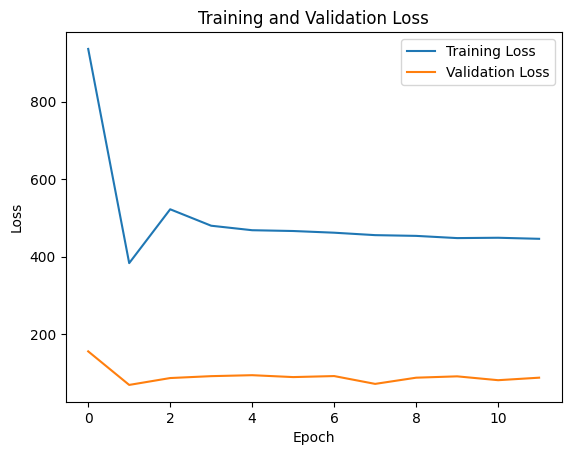

Fold 3 Results:
   Accuracy: 0.5957
   Average Sensitivity (Recall): 0.1030
   Average Specificity: 0.9903

Cross-Validation Results:
accuracy: Mean = 0.6056 ± 0.01
sensitivity: Mean = 0.1563 ± 0.11
specificity: Mean = 0.9181 ± 0.11
epochs: Mean = 12.0000 ± 0.00
training_times: Mean = 0.8886 ± 0.01
testing_times: Mean = 0.0835 ± 0.08
avg_memory_usage: Mean = 4.8959 ± 0.00
avg_gpu_usage: Mean = 0.0208 ± 0.00
max_memory_usage: Mean = 4.8959 ± 0.00
max_gpu_usage: Mean = 0.0208 ± 0.00


In [25]:
set_seed(42)
gcn2_proteins = GCN2Layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes)
print(gcn2_proteins)
print(f"Total number of trainable parameters: {(gcn2_proteins.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn2_proteins, proteins_dataset, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_2l_proteins.pth')

GCN3Layer(
  (gcn1): GCN (4 -> 24)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (24 -> 48)
  (bn2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (48 -> 24)
  (bn3): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=24, out_features=2, bias=True)
)
Total number of trainable parameters: 2738


Fold 1/3


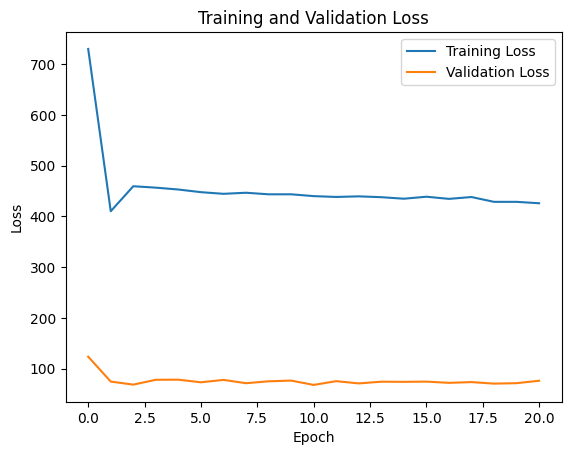

Fold 1 Results:
   Accuracy: 0.6253
   Average Sensitivity (Recall): 0.2174
   Average Specificity: 0.8670

Fold 2/3


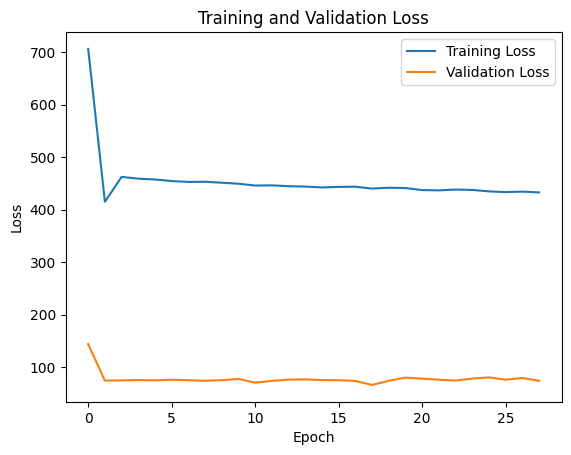

Fold 2 Results:
   Accuracy: 0.6065
   Average Sensitivity (Recall): 0.1633
   Average Specificity: 0.8973

Fold 3/3


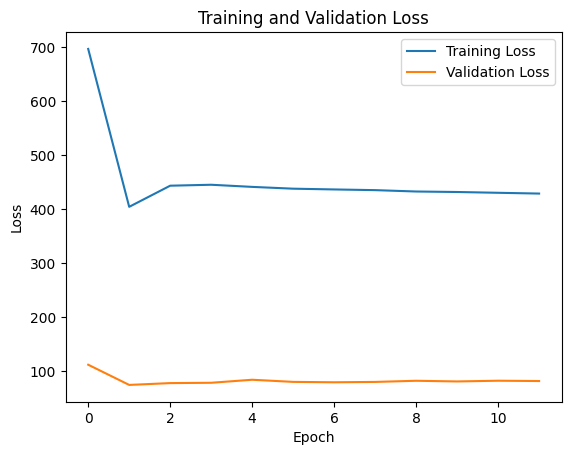

Fold 3 Results:
   Accuracy: 0.5687
   Average Sensitivity (Recall): 0.0303
   Average Specificity: 1.0000

Cross-Validation Results:
accuracy: Mean = 0.6002 ± 0.02
sensitivity: Mean = 0.1370 ± 0.08
specificity: Mean = 0.9214 ± 0.06
epochs: Mean = 20.3333 ± 6.55
training_times: Mean = 1.6125 ± 0.52
testing_times: Mean = 0.0312 ± 0.00
avg_memory_usage: Mean = 4.8684 ± 0.00
avg_gpu_usage: Mean = 0.0208 ± 0.00
max_memory_usage: Mean = 4.8684 ± 0.00
max_gpu_usage: Mean = 0.0208 ± 0.00


In [14]:
set_seed(42)
gcn3_proteins = GCN3Layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes)
print(gcn3_proteins)
print(f"Total number of trainable parameters: {(gcn3_proteins.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn3_proteins, proteins_dataset, lr=0.01, 
            num_epochs=500, step_size=100, save_path='models/gcn_3l_proteins.pth')

GCN4Layer(
  (gcn1): GCN (4 -> 24)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (24 -> 48)
  (bn2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (48 -> 72)
  (bn3): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (72 -> 48)
  (bn4): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=48, out_features=2, bias=True)
)
Total number of trainable parameters: 8834


Fold 1/3


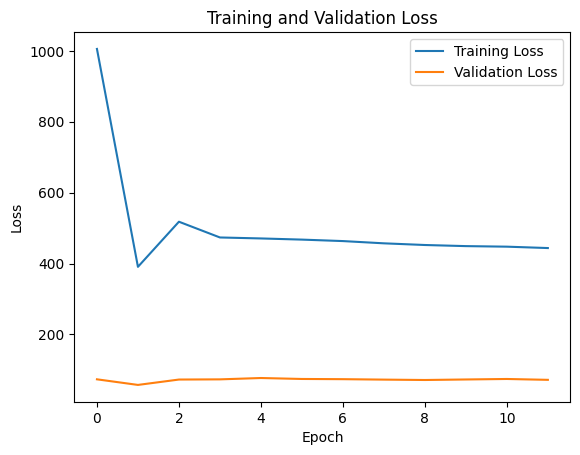

Fold 1 Results:
   Accuracy: 0.6226
   Average Sensitivity (Recall): 0.2174
   Average Specificity: 0.8627

Fold 2/3


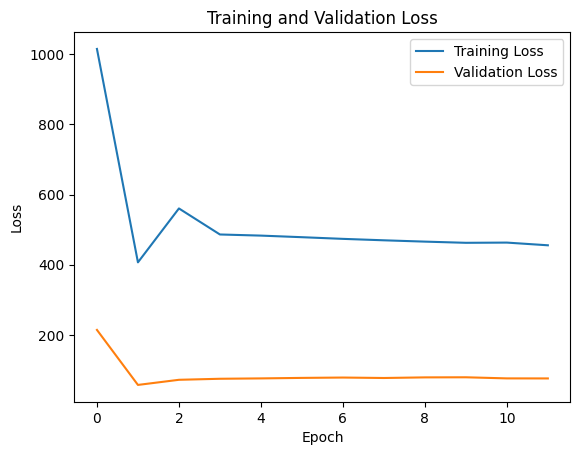

Fold 2 Results:
   Accuracy: 0.5876
   Average Sensitivity (Recall): 0.1769
   Average Specificity: 0.8571

Fold 3/3


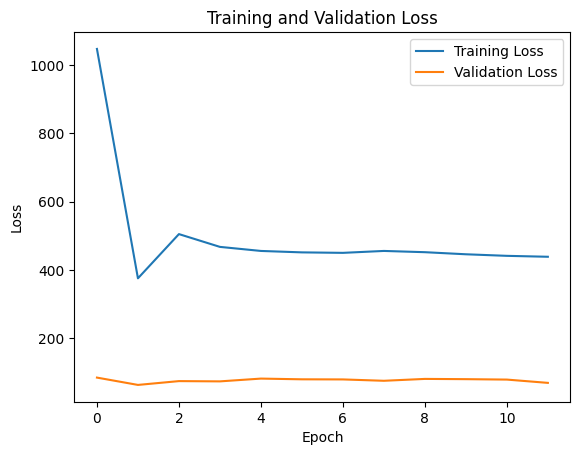

Fold 3 Results:
   Accuracy: 0.5984
   Average Sensitivity (Recall): 0.2545
   Average Specificity: 0.8738

Cross-Validation Results:
accuracy: Mean = 0.6029 ± 0.01
sensitivity: Mean = 0.2163 ± 0.03
specificity: Mean = 0.8645 ± 0.01
epochs: Mean = 12.0000 ± 0.00
training_times: Mean = 1.0681 ± 0.03
testing_times: Mean = 0.0347 ± 0.00
avg_memory_usage: Mean = 4.8734 ± 0.00
avg_gpu_usage: Mean = 0.0209 ± 0.00
max_memory_usage: Mean = 4.8734 ± 0.00
max_gpu_usage: Mean = 0.0209 ± 0.00


In [15]:
set_seed(42)
gcn4_proteins = GCN4Layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes)
print(gcn4_proteins)
print(f"Total number of trainable parameters: {(gcn4_proteins.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn4_proteins, proteins_dataset, lr=0.01, 
            num_epochs=500, step_size=100, save_path='models/gcn_4l_proteins.pth')

GCN5Layer(
  (gcn1): GCN (4 -> 24)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (24 -> 48)
  (bn2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (48 -> 72)
  (bn3): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (72 -> 48)
  (bn4): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn5): GCN (48 -> 24)
  (bn5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=24, out_features=2, bias=True)
)
Total number of trainable parameters: 10010


Fold 1/3


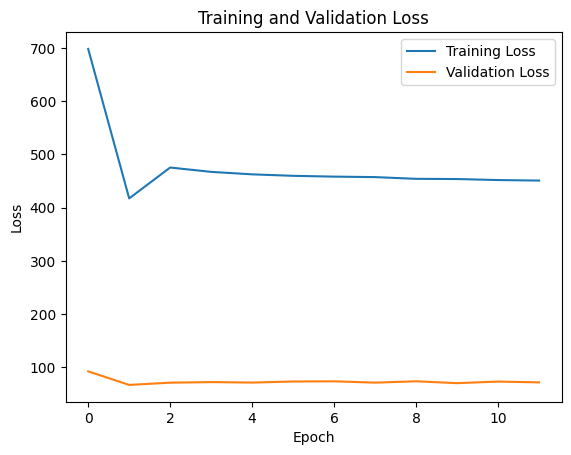

Fold 1 Results:
   Accuracy: 0.5526
   Average Sensitivity (Recall): 0.2101
   Average Specificity: 0.7554

Fold 2/3


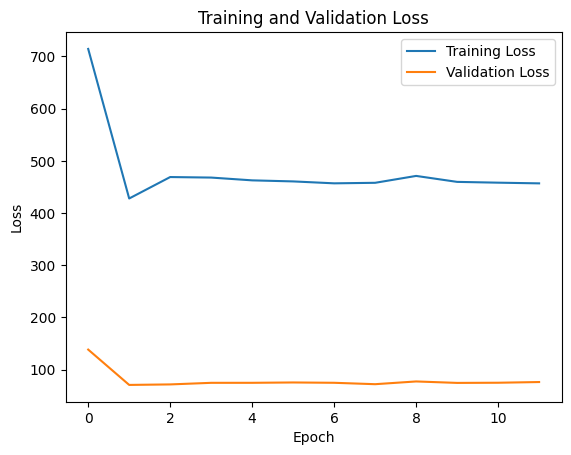

Fold 2 Results:
   Accuracy: 0.6038
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000

Fold 3/3


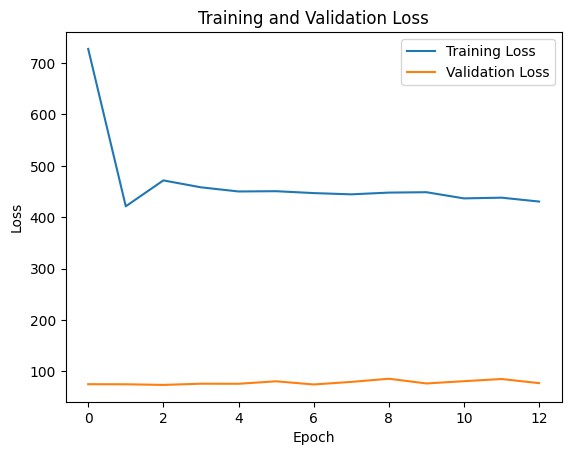

Fold 3 Results:
   Accuracy: 0.5714
   Average Sensitivity (Recall): 0.0364
   Average Specificity: 1.0000

Cross-Validation Results:
accuracy: Mean = 0.5759 ± 0.02
sensitivity: Mean = 0.0822 ± 0.09
specificity: Mean = 0.9185 ± 0.12
epochs: Mean = 12.3333 ± 0.47
training_times: Mean = 1.1606 ± 0.06
testing_times: Mean = 0.0323 ± 0.00
avg_memory_usage: Mean = 4.8771 ± 0.00
avg_gpu_usage: Mean = 0.0209 ± 0.00
max_memory_usage: Mean = 4.8771 ± 0.00
max_gpu_usage: Mean = 0.0209 ± 0.00


In [16]:
set_seed(42)
gcn5_proteins = GCN5Layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes)
print(gcn5_proteins)
print(f"Total number of trainable parameters: {(gcn5_proteins.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn5_proteins, proteins_dataset, lr=0.01, 
            num_epochs=500, step_size=100, save_path='models/gcn_5l_proteins.pth')

## GCESN

In [20]:
gcesn_proteins = GCESN_1layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes, 
            leaky_rate=0.9, num_iterations=2)
print(gcesn_proteins)
print(f"Total number of trainable parameters: {gcesn_proteins.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_proteins, proteins_dataset,
                lr=0.01, num_epochs=500, step_size=100, num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_1l_proteins.pth')


GCESN_1layer(
  (fc1): Linear(in_features=24, out_features=24, bias=True)
  (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=24, out_features=2, bias=True)
)
Total number of trainable parameters: 698


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6334
   Average Sensitivity (Recall): 0.0145
   Average Specificity: 1.0000
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6038
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5580
   Average Sensitivity (Recall): 0.0061
   Average Specificity: 1.0000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.5984, Std = 0.0310
sensitivity: Mean = 0.0069, Std = 0.0059
specificity: Mean = 1.0000, Std = 0.0000

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6712
   Average Sensitivity (Recall): 0.2029
   Average Specificity: 0.9485
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6119
   Average Sensitivity (Recall): 0.0204
   Average Speci

In [27]:
gcesn_proteins_2 = GCESN_2layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes, 
                leaky_rate=0.9, num_iterations=1)
print(gcesn_proteins_2)
print(f"Total number of trainable parameters: {gcesn_proteins_2.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_proteins_2, proteins_dataset,
                lr=0.005, num_epochs=500, step_size=100, 
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_2l_proteins.pth')


GCESN_2layer(
  (fc1): Linear(in_features=24, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=48, bias=True)
  (bn): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=48, out_features=2, bias=True)
)
Total number of trainable parameters: 3746


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6523
   Average Sensitivity (Recall): 0.3986
   Average Specificity: 0.8026
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6065
   Average Sensitivity (Recall): 0.0068
   Average Specificity: 1.0000
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5580
   Average Sensitivity (Recall): 0.0061
   Average Specificity: 1.0000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.6056, Std = 0.0385
sensitivity: Mean = 0.1371, Std = 0.1848
specificity: Mean = 0.9342, Std = 0.0931

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6469
   Average Sensitivity (Recall): 0.0580
   Average Specificity: 0.9957
Fold 2/3
Fold 2 Results:
   Accuracy: 0.

In [47]:
gcesn_proteins_3 = GCESN_3layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes, 
                leaky_rate=0.9, num_iterations=1)
print(gcesn_proteins_3)
print(f"Total number of trainable parameters: {gcesn_proteins_3.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_proteins_3, proteins_dataset,
                lr=0.01, num_epochs=500, step_size=500,
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_3l_proteins.pth')


GCESN_3layer(
  (fc1): Linear(in_features=24, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=24, bias=True)
  (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=24, out_features=2, bias=True)
)
Total number of trainable parameters: 3074


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6712
   Average Sensitivity (Recall): 0.1304
   Average Specificity: 0.9914
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6038
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5633
   Average Sensitivity (Recall): 0.0182
   Average Specificity: 1.0000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.6128, Std = 0.0445
sensitivity: Mean = 0.0495, Std = 0.0577
specificity: Mean = 0.9971, Std = 0.0040

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6388
   Average Sensitivity (Recall): 0.0290
   Average 

In [62]:
gcesn_proteins_4 = GCESN_4layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes, 
                leaky_rate=0.8, num_iterations=1)
print(gcesn_proteins_4)
print(f"Total number of trainable parameters: {gcesn_proteins_4.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_proteins_4, proteins_dataset,
                lr=0.01, num_epochs=500, step_size=100,
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_4l_proteins.pth')


GCESN_4layer(
  (fc1): Linear(in_features=24, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=72, bias=True)
  (fc3): Linear(in_features=72, out_features=48, bias=True)
  (fc4): Linear(in_features=48, out_features=48, bias=True)
  (bn): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=48, out_features=2, bias=True)
)
Total number of trainable parameters: 10778


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6280
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6038
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5687
   Average Sensitivity (Recall): 0.0303
   Average Specificity: 1.0000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.6002, Std = 0.0243
sensitivity: Mean = 0.0101, Std = 0.0143
specificity: Mean = 1.0000, Std = 0.0000

Run 2/3
Fold 1/3
Fold 1 Results:
   Accurac

In [67]:
gcesn_proteins_5 = GCESN_5layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes, 
                leaky_rate=0.8, num_iterations=1)
print(gcesn_proteins_5)
print(f"Total number of trainable parameters: {gcesn_proteins_5.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_proteins_5, proteins_dataset,
                lr=0.01, num_epochs=500, step_size=100, 
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_5l_proteins.pth')


GCESN_5layer(
  (fc1): Linear(in_features=24, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=72, bias=True)
  (fc3): Linear(in_features=72, out_features=48, bias=True)
  (fc4): Linear(in_features=48, out_features=24, bias=True)
  (fc5): Linear(in_features=24, out_features=24, bias=True)
  (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=24, out_features=2, bias=True)
)
Total number of trainable parameters: 10106


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6280
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6038
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5553
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.5957, Std = 0.0303
sensitivity: Mean = 0.0000, Std = 0.0000
specificity: Mean = 1.000

## TGCESN

Total number of trainable parameters: 1370


Fold 1/3


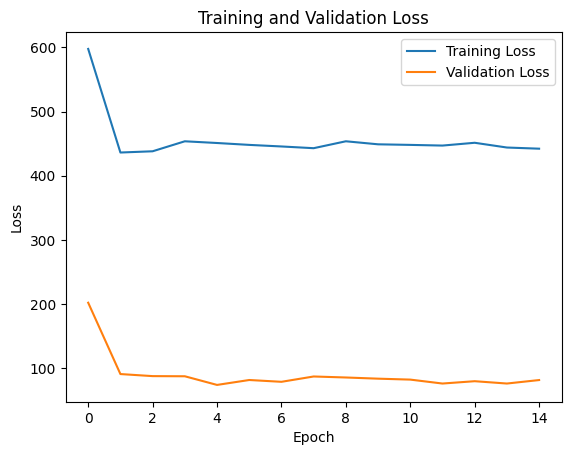

Fold 1 Results:
   Accuracy: 0.4259
   Average Sensitivity (Recall): 0.4710
   Average Specificity: 0.3991

Fold 2/3


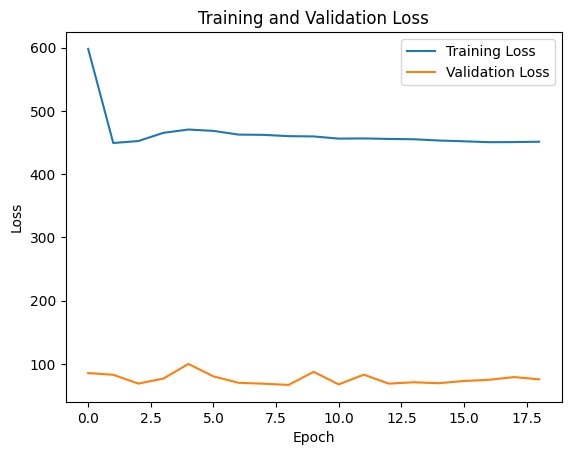

Fold 2 Results:
   Accuracy: 0.6173
   Average Sensitivity (Recall): 0.1769
   Average Specificity: 0.9062

Fold 3/3


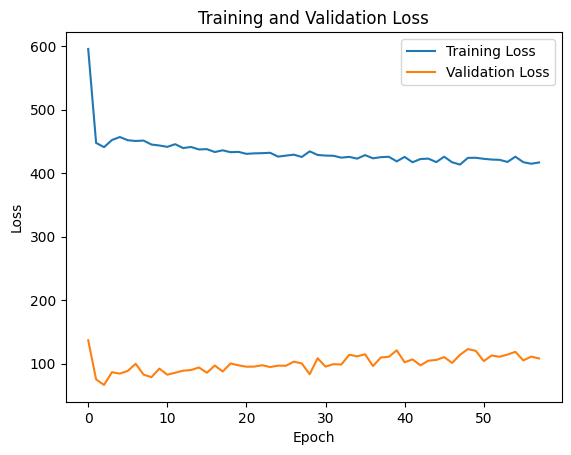

Fold 3 Results:
   Accuracy: 0.5580
   Average Sensitivity (Recall): 0.0061
   Average Specificity: 1.0000

Cross-Validation Results:
accuracy: Mean = 0.5337 ± 0.08
sensitivity: Mean = 0.2180 ± 0.19
specificity: Mean = 0.7685 ± 0.26
epochs: Mean = 30.6667 ± 19.40
training_times: Mean = 2.9066 ± 1.79
testing_times: Mean = 0.0309 ± 0.00
avg_memory_usage: Mean = 4.9313 ± 0.00
avg_gpu_usage: Mean = 0.0383 ± 0.00
max_memory_usage: Mean = 4.9313 ± 0.00
max_gpu_usage: Mean = 0.0383 ± 0.00


In [73]:
set_seed(42)
trainable_gcesn_proteins = TrainableGCESN_1layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes, 
                        leaky_rate=0.9, num_iterations=2)
print(f"Total number of trainable parameters: {trainable_gcesn_proteins.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_proteins, proteins_dataset,
                lr=0.005, num_epochs=500, step_size=100, 
                save_path='models/trainable_gcesn_1l_proteins.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 5450


Fold 1/3


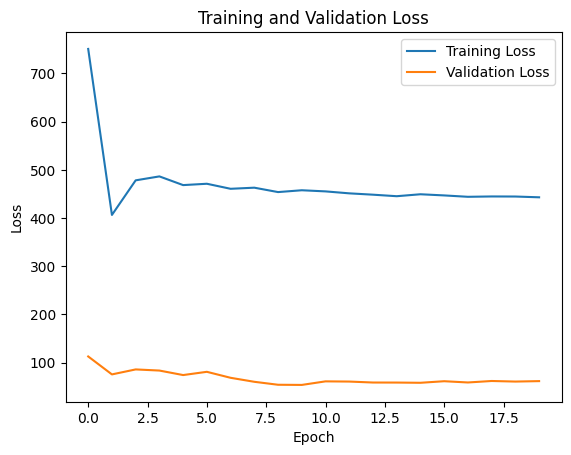

Fold 1 Results:
   Accuracy: 0.6280
   Average Sensitivity (Recall): 0.0217
   Average Specificity: 0.9871

Fold 2/3


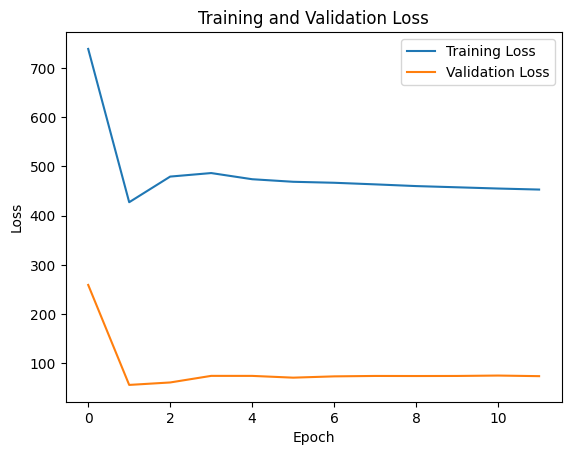

Fold 2 Results:
   Accuracy: 0.4960
   Average Sensitivity (Recall): 0.5238
   Average Specificity: 0.4777

Fold 3/3


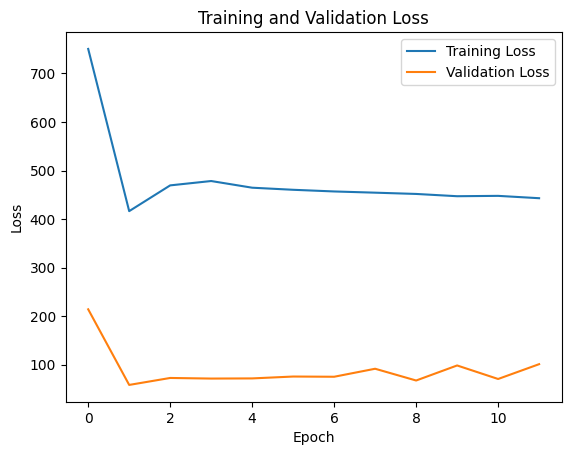

Fold 3 Results:
   Accuracy: 0.5553
   Average Sensitivity (Recall): 0.2364
   Average Specificity: 0.8107

Cross-Validation Results:
accuracy: Mean = 0.5597 ± 0.05
sensitivity: Mean = 0.2606 ± 0.21
specificity: Mean = 0.7585 ± 0.21
epochs: Mean = 14.6667 ± 3.77
training_times: Mean = 3.5172 ± 1.67
testing_times: Mean = 0.0305 ± 0.00
avg_memory_usage: Mean = 4.9317 ± 0.00
avg_gpu_usage: Mean = 0.0277 ± 0.00
max_memory_usage: Mean = 4.9317 ± 0.00
max_gpu_usage: Mean = 0.0277 ± 0.00


In [75]:
set_seed(42)
trainable_gcesn_proteins_2 = TrainableGCESN_2layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes, 
                        leaky_rate=0.9, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_proteins_2.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_proteins_2, proteins_dataset,
                lr=0.01, num_epochs=500, step_size=100, 
                save_path='models/trainable_gcesn_2l_proteins.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 6626


Fold 1/3


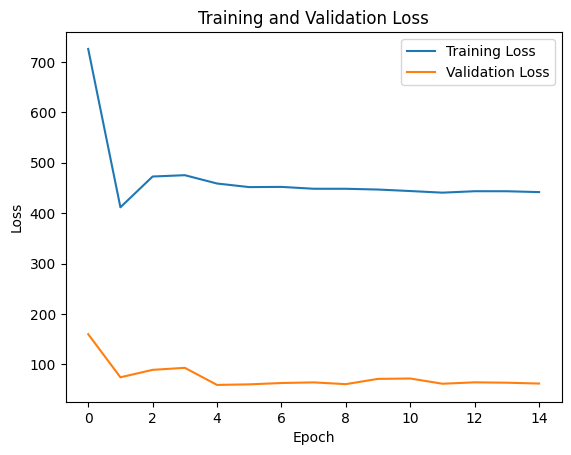

Fold 1 Results:
   Accuracy: 0.6280
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000

Fold 2/3


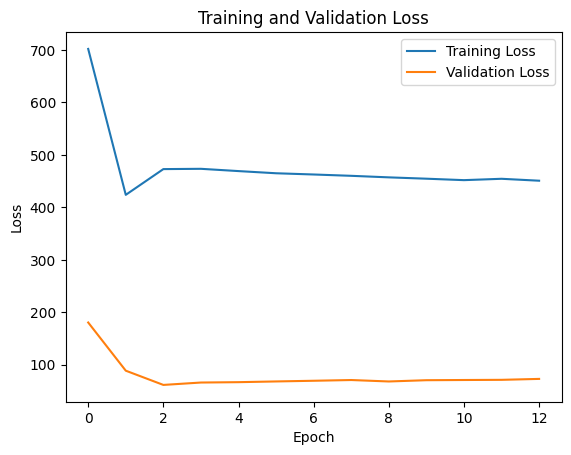

Fold 2 Results:
   Accuracy: 0.6038
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000

Fold 3/3


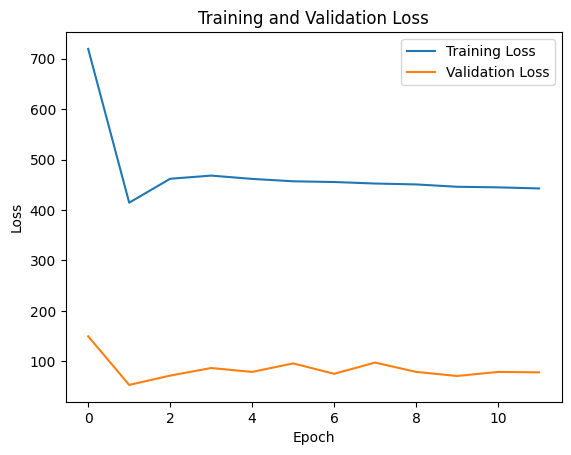

Fold 3 Results:
   Accuracy: 0.4663
   Average Sensitivity (Recall): 0.5879
   Average Specificity: 0.3689

Cross-Validation Results:
accuracy: Mean = 0.5660 ± 0.07
sensitivity: Mean = 0.1960 ± 0.28
specificity: Mean = 0.7896 ± 0.30
epochs: Mean = 13.3333 ± 1.25
training_times: Mean = 5.9025 ± 0.90
testing_times: Mean = 0.0339 ± 0.00
avg_memory_usage: Mean = 4.9330 ± 0.00
avg_gpu_usage: Mean = 0.0298 ± 0.00
max_memory_usage: Mean = 4.9330 ± 0.00
max_gpu_usage: Mean = 0.0298 ± 0.00


In [78]:
set_seed(42)
trainable_gcesn_proteins_3 = TrainableGCESN_3layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes, 
                        leaky_rate=0.8, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_proteins_3.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_proteins_3, proteins_dataset,
                lr=0.01, num_epochs=500, step_size=100, 
                save_path='models/trainable_gcesn_3l_proteins.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 21242


Fold 1/3


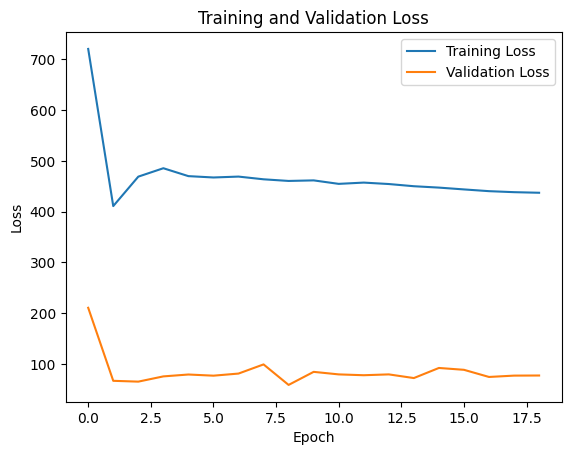

Fold 1 Results:
   Accuracy: 0.6199
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 0.9871

Fold 2/3


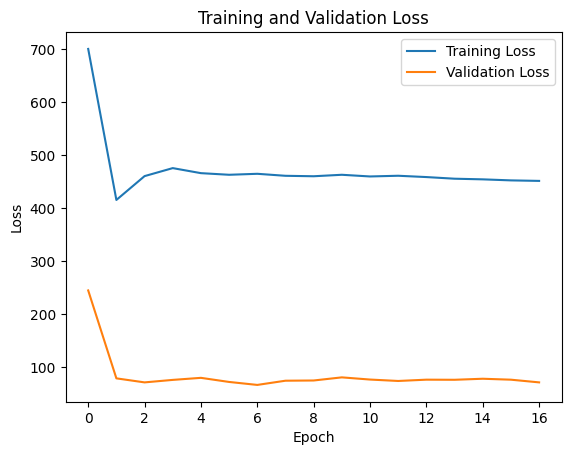

Fold 2 Results:
   Accuracy: 0.5822
   Average Sensitivity (Recall): 0.1156
   Average Specificity: 0.8884

Fold 3/3


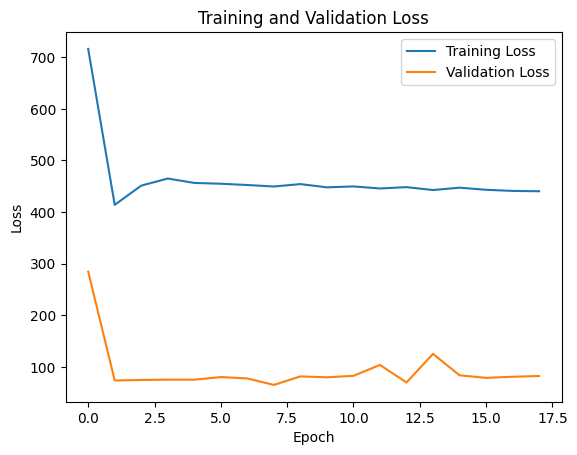

Fold 3 Results:
   Accuracy: 0.5283
   Average Sensitivity (Recall): 0.1879
   Average Specificity: 0.8010

Cross-Validation Results:
accuracy: Mean = 0.5768 ± 0.04
sensitivity: Mean = 0.1012 ± 0.08
specificity: Mean = 0.8922 ± 0.08
epochs: Mean = 18.0000 ± 0.82
training_times: Mean = 6.1646 ± 1.42
testing_times: Mean = 0.0339 ± 0.00
avg_memory_usage: Mean = 4.9333 ± 0.00
avg_gpu_usage: Mean = 0.0300 ± 0.00
max_memory_usage: Mean = 4.9333 ± 0.00
max_gpu_usage: Mean = 0.0301 ± 0.00


In [80]:
set_seed(42)
trainable_gcesn_proteins_4 = TrainableGCESN_4layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes, 
                    leaky_rate=0.8, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_proteins_4.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_proteins_4, proteins_dataset,
                lr=0.005, num_epochs=500, step_size=100,  
                save_path='models/trainable_gcesn_4l_proteins.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 2442


Fold 1/3


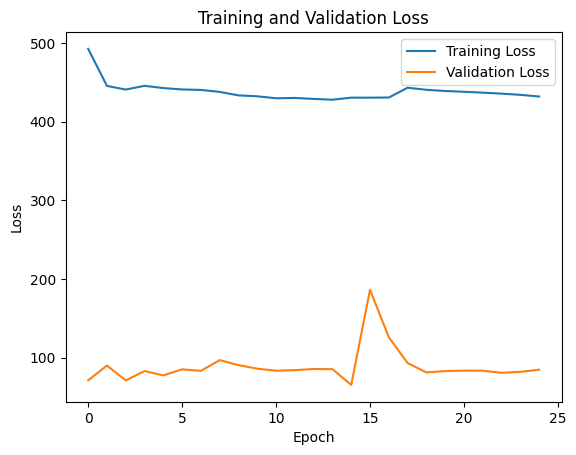

Fold 1 Results:
   Accuracy: 0.6280
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000

Fold 2/3


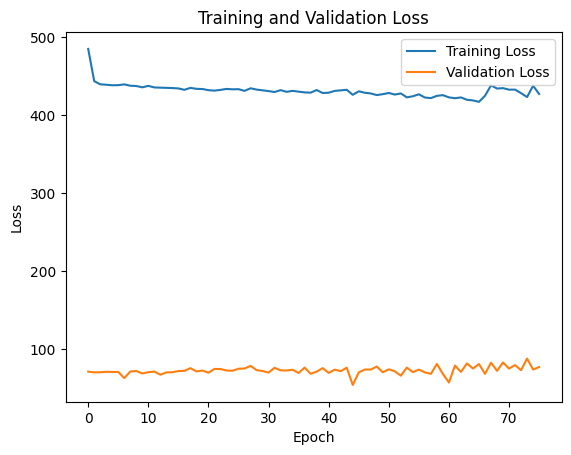

Fold 2 Results:
   Accuracy: 0.5849
   Average Sensitivity (Recall): 0.0136
   Average Specificity: 0.9598

Fold 3/3


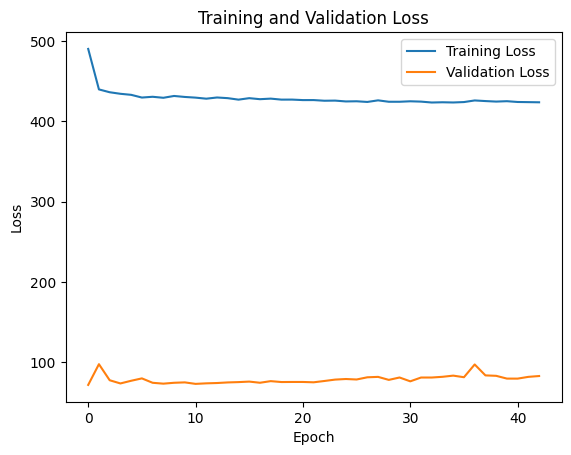

Fold 3 Results:
   Accuracy: 0.5553
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000

Cross-Validation Results:
accuracy: Mean = 0.5894 ± 0.03
sensitivity: Mean = 0.0045 ± 0.01
specificity: Mean = 0.9866 ± 0.02
epochs: Mean = 48.0000 ± 21.12
training_times: Mean = 7.7108 ± 3.44
testing_times: Mean = 0.0335 ± 0.00
avg_memory_usage: Mean = 4.9386 ± 0.00
avg_gpu_usage: Mean = 0.0322 ± 0.00
max_memory_usage: Mean = 4.9387 ± 0.00
max_gpu_usage: Mean = 0.0322 ± 0.00


In [ ]:
set_seed(42)
trainable_gcesn_proteins_5 = TrainableGCESN_5layer(proteins_num_features, 6*proteins_num_features, proteins_num_classes, 
                        leaky_rate=0.8, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_proteins_5.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_proteins_5, proteins_dataset,
                lr=0.005, num_epochs=500, step_size=100,  
                save_path='models/trainable_gcesn_5l_proteins.pth',
                binary_classification=True, is_esn=True)

# DND

## GAT

In [55]:
set_seed(42)
gat1_dnd = GAT1Layer(dnd_num_features, 32, dnd_num_classes).to(device)
print(gat1_dnd)
print(f"Total number of trainable parameters: {(gat1_dnd.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat1_dnd, dd_dataset, 
            lr=0.005, num_epochs=500, step_size=100,  
            save_path='models/gat_1l_dnd.pth')

GAT1Layer(
  (gat1): GAT (89 -> 32)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 3074


Fold 1/3


OutOfMemoryError: CUDA out of memory. Tried to allocate 94.37 GiB. GPU 0 has a total capacty of 15.73 GiB of which 12.55 GiB is free. Process 3819597 has 3.17 GiB memory in use. Of the allocated memory 1.50 GiB is allocated by PyTorch, and 605.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
set_seed(42)
gat2_dnd = GAT2Layer(dnd_num_features, 32, dnd_num_classes).to(device)
print(gat2_dnd)
print(f"Total number of trainable parameters: {(gat2_dnd.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat2_dnd, dd_dataset, 
            lr=0.005, num_epochs=500, step_size=100,  
            save_path='models/gat_2l_dnd.pth')

In [ ]:
set_seed(42)
gat3_dnd = GAT3Layer(dnd_num_features, 32, dnd_num_classes).to(device)
print(gat3_dnd)
print(f"Total number of trainable parameters: {(gat3_dnd.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat3_dnd, dnd_dataset, 
            lr=0.005, num_epochs=500, step_size=100,  
            save_path='models/gat_3l_dnd.pth')

In [ ]:
set_seed(42)
gat4_dnd = GAT4Layer(dnd_num_features, 32, dnd_num_classes).to(device)
print(gat4_dnd)
print(f"Total number of trainable parameters: {(gat4_dnd.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat4_dnd, dnd_dataset, 
            lr=0.005, num_epochs=500, step_size=100,  
            save_path='models/gat_4l_dnd.pth')

In [ ]:
set_seed(42)
gat5_dnd = GAT5Layer(dnd_num_features, 32, dnd_num_classes).to(device)
print(gat5_dnd)
print(f"Total number of trainable parameters: {(gat5_dnd.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat5_dnd, dnd_dataset, 
            lr=0.005, num_epochs=500, step_size=100,  
            save_path='models/gat_5l_dnd.pth')

## GCN

GCN1Layer(
  (gcn1): GCN (89 -> 32)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 3010


Fold 1/3


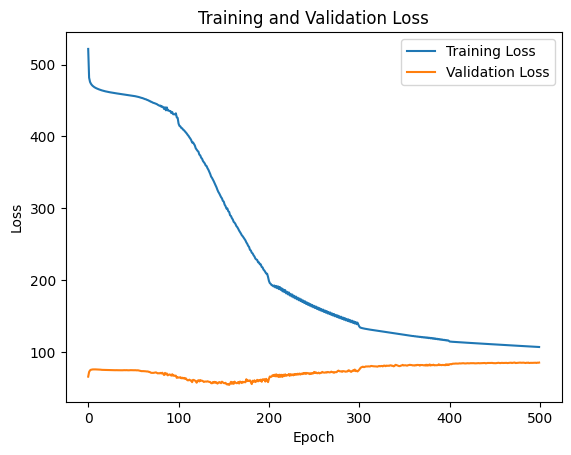

Fold 1 Results:
   Accuracy: 0.6107
   Average Sensitivity (Recall): 0.0446
   Average Specificity: 0.9873

Fold 2/3


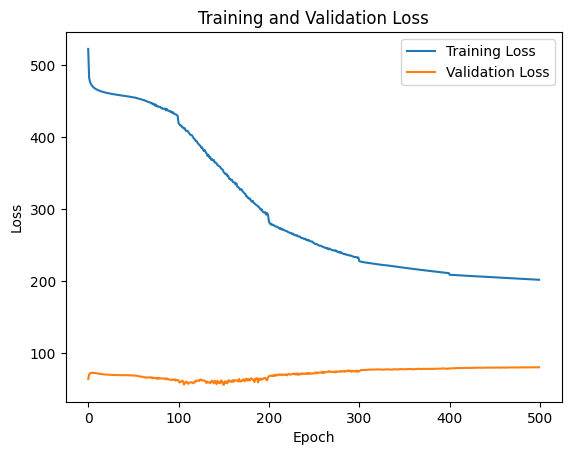

Fold 2 Results:
   Accuracy: 0.6616
   Average Sensitivity (Recall): 0.2368
   Average Specificity: 0.9295

Fold 3/3


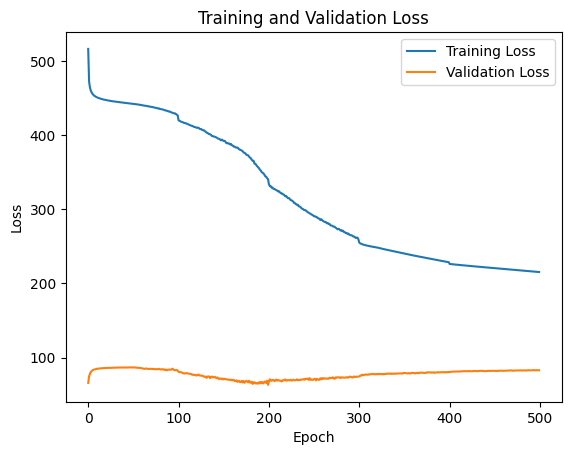

Fold 3 Results:
   Accuracy: 0.5434
   Average Sensitivity (Recall): 0.0562
   Average Specificity: 0.9486

Cross-Validation Results:
accuracy: Mean = 0.6052 ± 0.05
sensitivity: Mean = 0.1125 ± 0.09
specificity: Mean = 0.9551 ± 0.02
epochs: Mean = 500.0000 ± 0.00
training_times: Mean = 130.1594 ± 19.94
testing_times: Mean = 0.0730 ± 0.01
avg_memory_usage: Mean = 4.9980 ± 0.00
avg_gpu_usage: Mean = 2.2915 ± 0.00
max_memory_usage: Mean = 4.9980 ± 0.00
max_gpu_usage: Mean = 2.2915 ± 0.00


In [141]:
set_seed(42)
gcn1_dnd = GCN1Layer(dnd_num_features, 32, dnd_num_classes)
print(gcn1_dnd)
print(f"Total number of trainable parameters: {(gcn1_dnd.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn1_dnd, dd_dataset, lr=0.001, 
            num_epochs=500, step_size=100, save_path='models/gcn_1l_dnd.pth')

GCN2Layer(
  (gcn1): GCN (89 -> 32)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (32 -> 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 5314


Fold 1/3


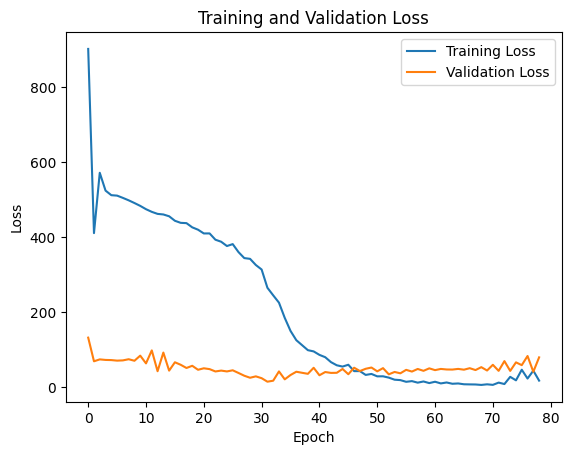

Fold 1 Results:
   Accuracy: 0.5598
   Average Sensitivity (Recall): 0.5924
   Average Specificity: 0.5381

Fold 2/3


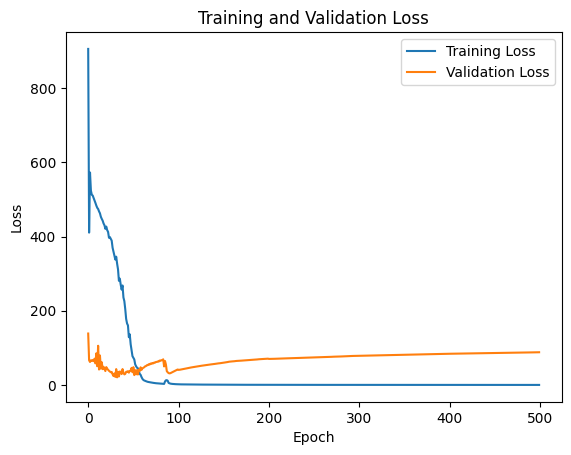

Fold 2 Results:
   Accuracy: 0.6056
   Average Sensitivity (Recall): 0.0132
   Average Specificity: 0.9793

Fold 3/3


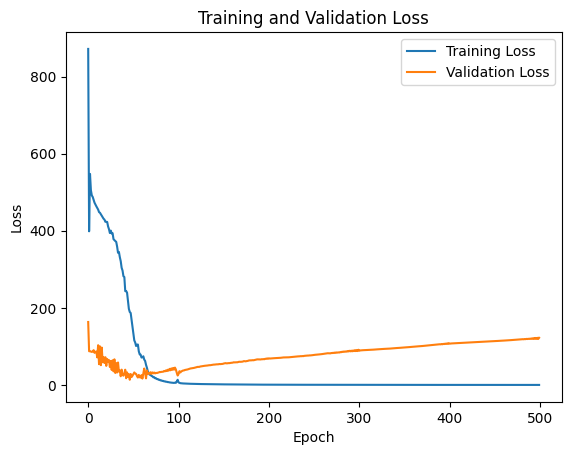

Fold 3 Results:
   Accuracy: 0.5153
   Average Sensitivity (Recall): 0.0337
   Average Specificity: 0.9159

Cross-Validation Results:
accuracy: Mean = 0.5602 ± 0.04
sensitivity: Mean = 0.2131 ± 0.27
specificity: Mean = 0.8111 ± 0.19
epochs: Mean = 359.3333 ± 198.23
training_times: Mean = 150.1240 ± 81.40
testing_times: Mean = 0.2684 ± 0.17
avg_memory_usage: Mean = 4.6095 ± 0.00
avg_gpu_usage: Mean = 0.4647 ± 0.00
max_memory_usage: Mean = 4.6095 ± 0.00
max_gpu_usage: Mean = 0.4647 ± 0.00


In [27]:
set_seed(42)
gcn2_dnd = GCN2Layer(dnd_num_features, 32, dnd_num_classes)
print(gcn2_dnd)
print(f"Total number of trainable parameters: {(gcn2_dnd.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn2_dnd, dd_dataset, lr=0.005, 
            num_epochs=500, step_size=100, save_path='models/gcn_2l_dnd.pth')

GCN3Layer(
  (gcn1): GCN (89 -> 32)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (32 -> 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (64 -> 32)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 7394


Fold 1/3


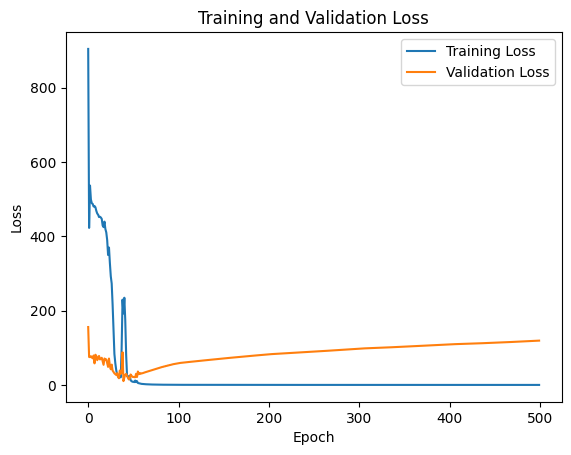

Fold 1 Results:
   Accuracy: 0.6132
   Average Sensitivity (Recall): 0.0828
   Average Specificity: 0.9661

Fold 2/3


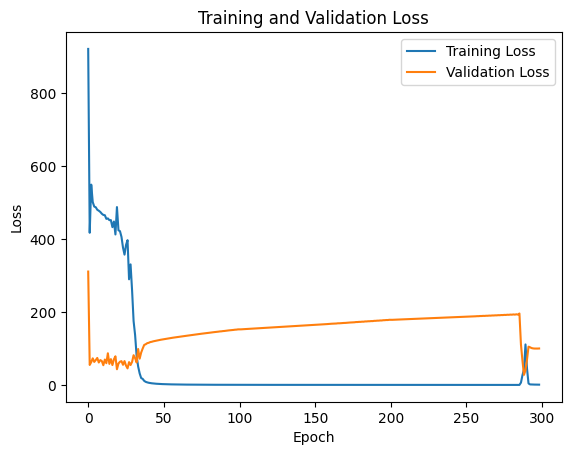

Fold 2 Results:
   Accuracy: 0.3969
   Average Sensitivity (Recall): 0.9605
   Average Specificity: 0.0415

Fold 3/3


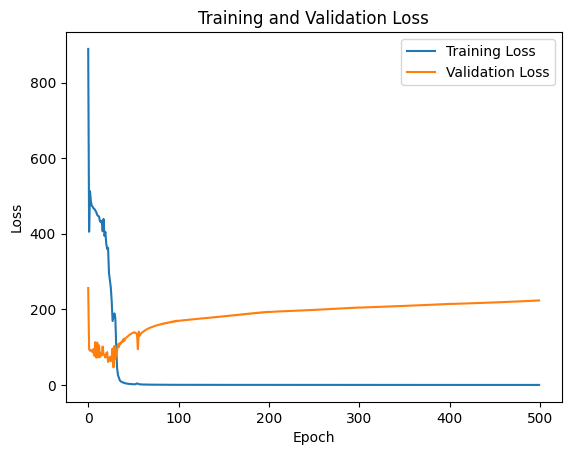

Fold 3 Results:
   Accuracy: 0.5306
   Average Sensitivity (Recall): 0.0225
   Average Specificity: 0.9533

Cross-Validation Results:
accuracy: Mean = 0.5136 ± 0.09
sensitivity: Mean = 0.3553 ± 0.43
specificity: Mean = 0.6536 ± 0.43
epochs: Mean = 433.0000 ± 94.75
training_times: Mean = 359.4179 ± 86.60
testing_times: Mean = 0.3287 ± 0.15
avg_memory_usage: Mean = 3.1586 ± 0.00
avg_gpu_usage: Mean = 0.0263 ± 0.00
max_memory_usage: Mean = 3.1586 ± 0.00
max_gpu_usage: Mean = 0.0264 ± 0.00


In [9]:
set_seed(42)
gcn3_dnd = GCN3Layer(dnd_num_features, 32, dnd_num_classes)
print(gcn3_dnd)
print(f"Total number of trainable parameters: {(gcn3_dnd.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn3_dnd, dd_dataset, lr=0.01, 
            num_epochs=500, step_size=100, save_path='models/gcn_3l_dnd.pth')

GCN4Layer(
  (gcn1): GCN (89 -> 32)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (32 -> 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (64 -> 96)
  (bn3): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (96 -> 64)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 18082


Fold 1/3


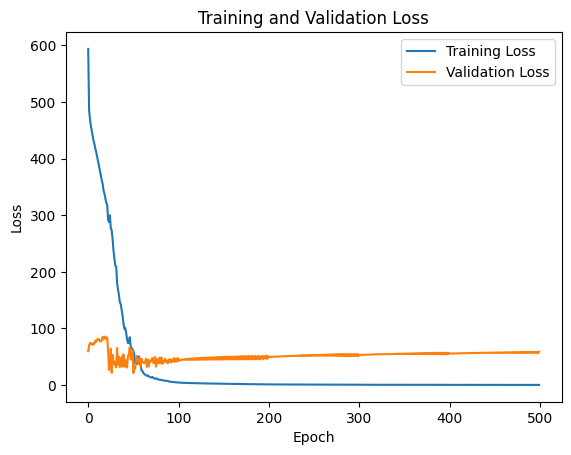

Fold 1 Results:
   Accuracy: 0.5852
   Average Sensitivity (Recall): 0.3758
   Average Specificity: 0.7246

Fold 2/3


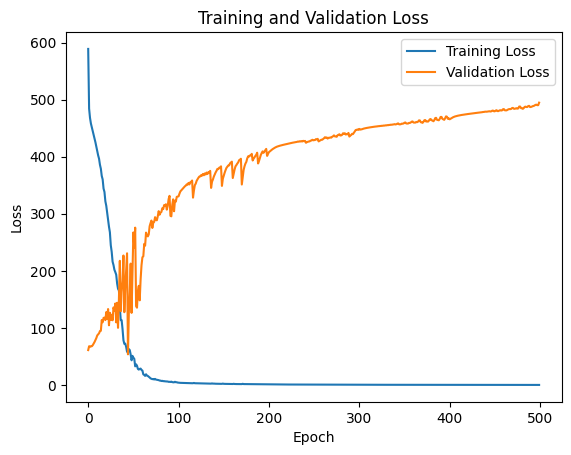

Fold 2 Results:
   Accuracy: 0.5064
   Average Sensitivity (Recall): 0.4934
   Average Specificity: 0.5145

Fold 3/3


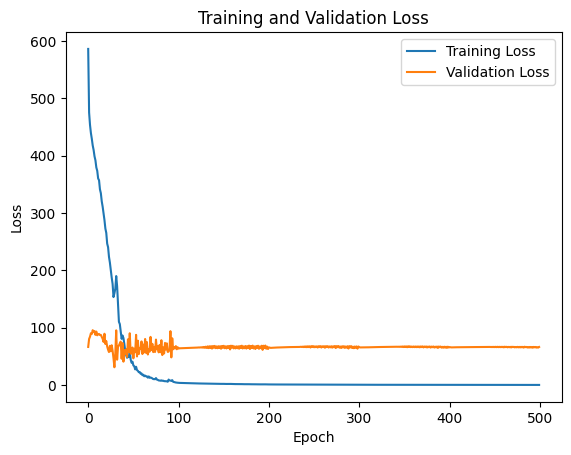

Fold 3 Results:
   Accuracy: 0.4847
   Average Sensitivity (Recall): 0.2303
   Average Specificity: 0.6963

Cross-Validation Results:
accuracy: Mean = 0.5254 ± 0.04
sensitivity: Mean = 0.3665 ± 0.11
specificity: Mean = 0.6451 ± 0.09
epochs: Mean = 499.6667 ± 0.47
training_times: Mean = 277.1067 ± 13.45
testing_times: Mean = 0.1465 ± 0.01
avg_memory_usage: Mean = 5.0016 ± 0.00
avg_gpu_usage: Mean = 2.2917 ± 0.00
max_memory_usage: Mean = 5.0020 ± 0.00
max_gpu_usage: Mean = 2.2918 ± 0.00


In [144]:
set_seed(42)
gcn4_dnd = GCN4Layer(dnd_num_features, 32, dnd_num_classes)
print(gcn4_dnd)
print(f"Total number of trainable parameters: {(gcn4_dnd.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn4_dnd, dd_dataset, lr=0.001, 
            num_epochs=500, step_size=100, save_path='models/gcn_4l_dnd.pth')

GCN5Layer(
  (gcn1): GCN (89 -> 32)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (32 -> 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (64 -> 96)
  (bn3): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (96 -> 64)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn5): GCN (64 -> 32)
  (bn5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 20162


Fold 1/3


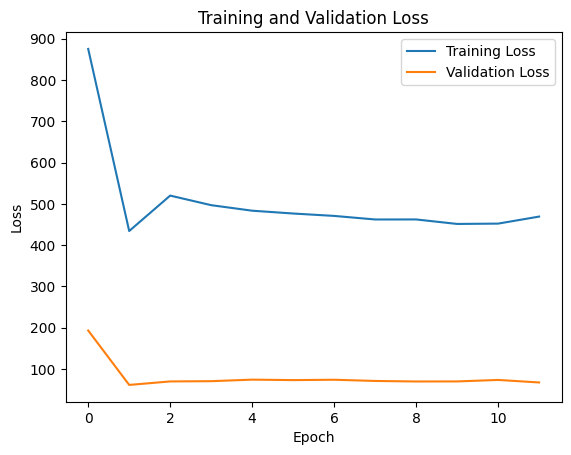

Fold 1 Results:
   Accuracy: 0.5293
   Average Sensitivity (Recall): 0.2229
   Average Specificity: 0.7331

Fold 2/3


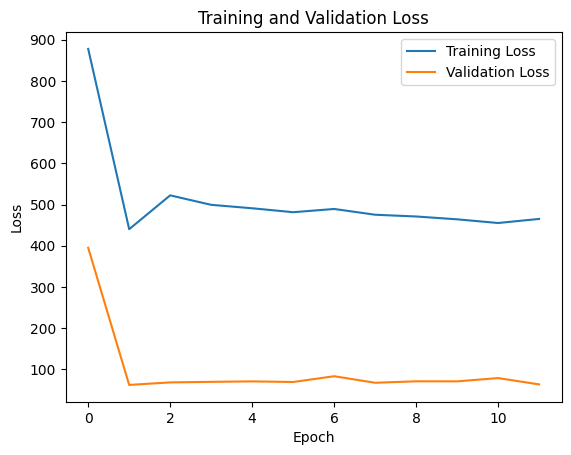

Fold 2 Results:
   Accuracy: 0.5369
   Average Sensitivity (Recall): 0.0921
   Average Specificity: 0.8174

Fold 3/3


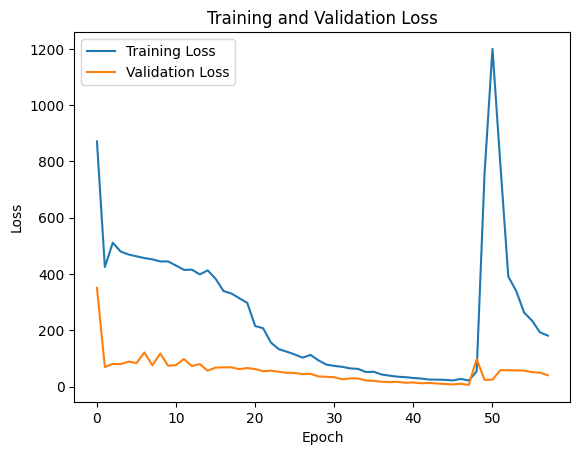

Fold 3 Results:
   Accuracy: 0.4541
   Average Sensitivity (Recall): 1.0000
   Average Specificity: 0.0000

Cross-Validation Results:
accuracy: Mean = 0.5067 ± 0.04
sensitivity: Mean = 0.4383 ± 0.40
specificity: Mean = 0.5168 ± 0.37
epochs: Mean = 27.3333 ± 21.68
training_times: Mean = 17.2869 ± 13.77
testing_times: Mean = 0.3830 ± 0.19
avg_memory_usage: Mean = 4.5900 ± 0.00
avg_gpu_usage: Mean = 0.4014 ± 0.00
max_memory_usage: Mean = 4.5906 ± 0.00
max_gpu_usage: Mean = 0.4019 ± 0.00


In [23]:
set_seed(42)
gcn5_dnd = GCN5Layer(dnd_num_features, 32, dnd_num_classes)
print(gcn5_dnd)
print(f"Total number of trainable parameters: {(gcn5_dnd.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn5_dnd, dd_dataset, lr=0.01, 
            num_epochs=500, step_size=100, save_path='models/gcn_5l_dnd.pth')

## GCESN

In [28]:
gcesn_dnd = GCESN_1layer(dnd_num_features, 32, dnd_num_classes, 
            leaky_rate=0.9, num_iterations=3)
print(gcesn_dnd)
print(f"Total number of trainable parameters: {gcesn_dnd.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_dnd, dd_dataset,
                lr=0.005, num_epochs=500, step_size=100,
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_1l_dnd.pth')


GCESN_1layer(
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 1186


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6107
   Average Sensitivity (Recall): 0.0955
   Average Specificity: 0.9534
Fold 2/3
Fold 2 Results:
   Accuracy: 0.5293
   Average Sensitivity (Recall): 0.2171
   Average Specificity: 0.7261
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5536
   Average Sensitivity (Recall): 0.0281
   Average Specificity: 0.9907
Run 1 Cross-Validation Results:
accuracy: Mean = 0.5645, Std = 0.0341
sensitivity: Mean = 0.1136, Std = 0.0782
specificity: Mean = 0.8901, Std = 0.1169

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6107
   Average Sensitivity (Recall): 0.1656
   Average Specificity: 0.9068
Fold 2/3
Fold 2 Results:
   Accuracy: 0.5191
   Average Sensitivity (Recall): 0.2763
   Average Spec

In [29]:
gcesn_dnd_2 = GCESN_2layer(dnd_num_features, 32, dnd_num_classes, leaky_rate=0.9, num_iterations=2)
print(gcesn_dnd_2)
print(f"Total number of trainable parameters: {gcesn_dnd_2.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_dnd_2, dd_dataset,
                lr=0.005, num_epochs=500, step_size=100, 
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_2l_dnd.pth')


GCESN_2layer(
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 6530


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.5471
   Average Sensitivity (Recall): 0.1274
   Average Specificity: 0.8263
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6234
   Average Sensitivity (Recall): 0.0263
   Average Specificity: 1.0000
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5485
   Average Sensitivity (Recall): 0.0169
   Average Specificity: 0.9907
Run 1 Cross-Validation Results:
accuracy: Mean = 0.5730, Std = 0.0357
sensitivity: Mean = 0.0569, Std = 0.0500
specificity: Mean = 0.9390, Std = 0.0798

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6056
   Average Sensitivity (Recall): 0.0127
   Average Specificity: 1.0000
Fold 2/3
Fold 2 Results:
   Accuracy: 0.

In [30]:
gcesn_dnd_3 = GCESN_3layer(dnd_num_features, 32, dnd_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_dnd_3)
print(f"Total number of trainable parameters: {gcesn_dnd_3.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_dnd_3, dd_dataset,
                lr=0.005, num_epochs=500, step_size=100,  
                num_runs=3, binary_classification=True,
                best_model_path='models/best_gcesn_3l_dnd.pth')


GCESN_3layer(
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 5378


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6107
   Average Sensitivity (Recall): 0.0255
   Average Specificity: 1.0000
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6234
   Average Sensitivity (Recall): 0.0526
   Average Specificity: 0.9834
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5485
   Average Sensitivity (Recall): 0.0393
   Average Specificity: 0.9720
Run 1 Cross-Validation Results:
accuracy: Mean = 0.5942, Std = 0.0327
sensitivity: Mean = 0.0391, Std = 0.0111
specificity: Mean = 0.9851, Std = 0.0115

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6183
   Average Sensitivity (Recall): 0.0510
   Average 

In [31]:
gcesn_dnd_4 = GCESN_4layer(dnd_num_features, 32, dnd_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_dnd_4)
print(f"Total number of trainable parameters: {gcesn_dnd_4.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_dnd_4, dd_dataset,
                lr=0.005, num_epochs=500, step_size=100, 
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_4l_dnd.pth')


GCESN_4layer(
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=96, bias=True)
  (fc3): Linear(in_features=96, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 18978


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.5954
   Average Sensitivity (Recall): 0.0510
   Average Specificity: 0.9576
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6361
   Average Sensitivity (Recall): 0.0658
   Average Specificity: 0.9959
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5459
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.5925, Std = 0.0369
sensitivity: Mean = 0.0389, Std = 0.0282
specificity: Mean = 0.9845, Std = 0.0191

Run 2/3
Fold 1/3
Fold 1 Results:
   Accurac

In [32]:
gcesn_dnd_5 = GCESN_5layer(dnd_num_features, 32, dnd_num_classes, leaky_rate=0.8, num_iterations=1)
print(gcesn_dnd_5)
print(f"Total number of trainable parameters: {gcesn_dnd_5.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_dnd_5, dd_dataset,
                lr=0.005, num_epochs=500, step_size=100,
                num_runs=3, binary_classification=True, 
                best_model_path='models/best_gcesn_5l_dnd.pth')


GCESN_5layer(
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=96, bias=True)
  (fc3): Linear(in_features=96, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 17826


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6031
   Average Sensitivity (Recall): 0.0127
   Average Specificity: 0.9958
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6209
   Average Sensitivity (Recall): 0.0197
   Average Specificity: 1.0000
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5459
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.5899, Std = 0.0320
sensitivity: Mean = 0.0108, Std = 0.0082
specificity: Mean = 0.998

## TGCESN

Total number of trainable parameters: 5058


Fold 1/3


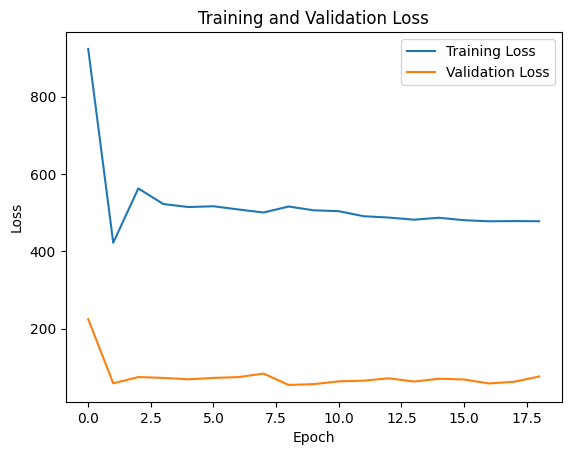

Fold 1 Results:
   Accuracy: 0.5776
   Average Sensitivity (Recall): 0.3694
   Average Specificity: 0.7161

Fold 2/3


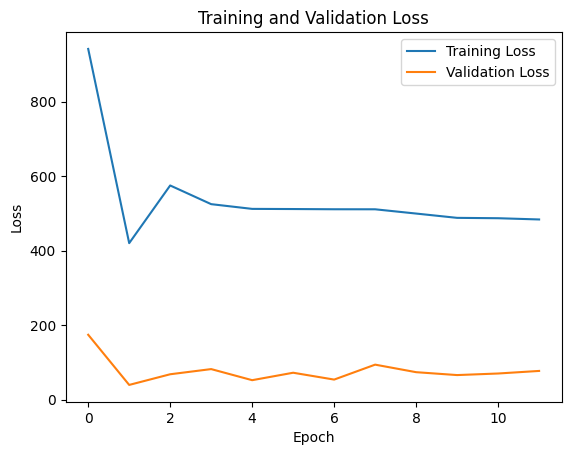

Fold 2 Results:
   Accuracy: 0.3817
   Average Sensitivity (Recall): 0.9276
   Average Specificity: 0.0373

Fold 3/3


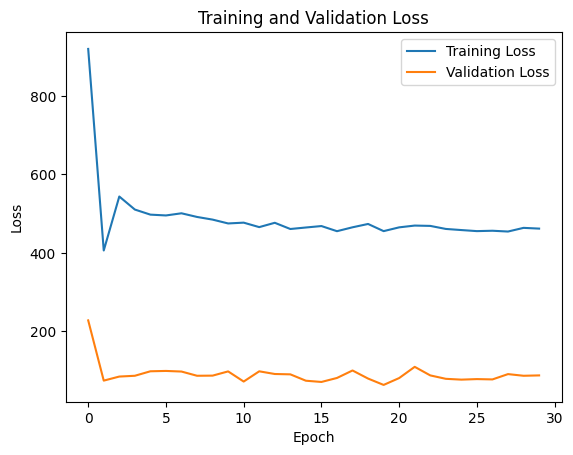

Fold 3 Results:
   Accuracy: 0.4490
   Average Sensitivity (Recall): 0.2416
   Average Specificity: 0.6215

Cross-Validation Results:
accuracy: Mean = 0.4694 ± 0.08
sensitivity: Mean = 0.5129 ± 0.30
specificity: Mean = 0.4583 ± 0.30
epochs: Mean = 20.3333 ± 7.41
training_times: Mean = 19.1408 ± 8.86
testing_times: Mean = 0.3859 ± 0.15
avg_memory_usage: Mean = 3.2290 ± 0.00
avg_gpu_usage: Mean = 0.8126 ± 0.00
max_memory_usage: Mean = 3.2292 ± 0.00
max_gpu_usage: Mean = 0.8131 ± 0.00


In [18]:
set_seed(42)
trainable_gcesn_dnd = TrainableGCESN_1layer(dnd_num_features, 32, dnd_num_classes, leaky_rate=0.9, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_dnd.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_dnd, dd_dataset,
                lr=0.01, num_epochs=500, step_size=100,  
                save_path='models/trainable_gcesn_1l_dnd.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 12290


Fold 1/3


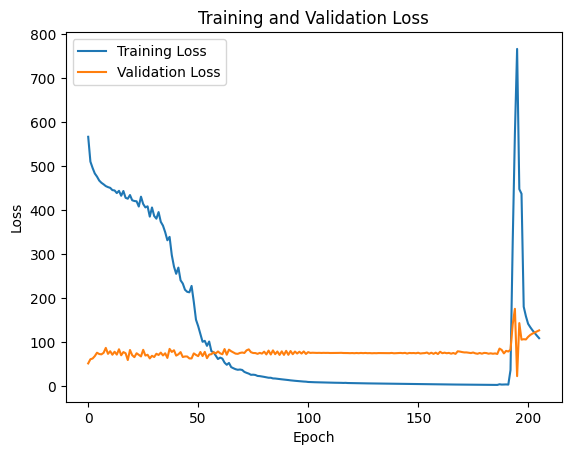

Fold 1 Results:
   Accuracy: 0.3969
   Average Sensitivity (Recall): 0.9809
   Average Specificity: 0.0085

Fold 2/3


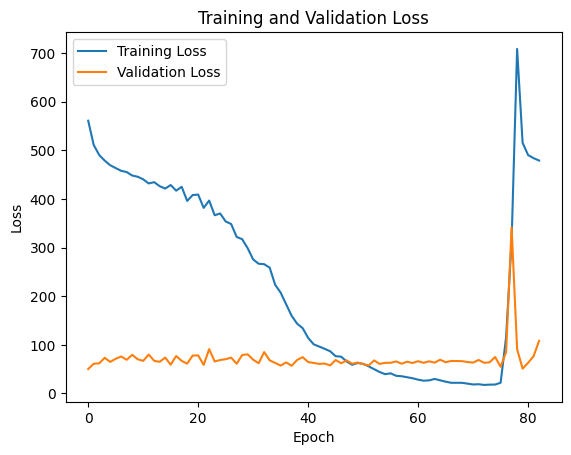

Fold 2 Results:
   Accuracy: 0.5802
   Average Sensitivity (Recall): 0.0395
   Average Specificity: 0.9212

Fold 3/3


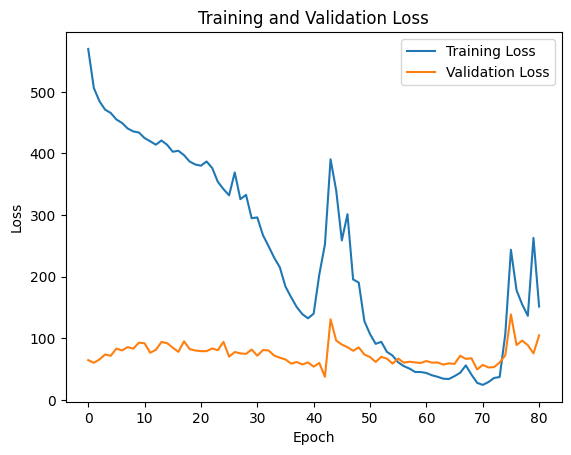

Fold 3 Results:
   Accuracy: 0.5230
   Average Sensitivity (Recall): 0.2191
   Average Specificity: 0.7757

Cross-Validation Results:
accuracy: Mean = 0.5000 ± 0.08
sensitivity: Mean = 0.4132 ± 0.41
specificity: Mean = 0.5684 ± 0.40
epochs: Mean = 123.3333 ± 58.46
training_times: Mean = 93.3317 ± 44.09
testing_times: Mean = 0.1513 ± 0.01
avg_memory_usage: Mean = 4.5869 ± 0.00
avg_gpu_usage: Mean = 0.4221 ± 0.00
max_memory_usage: Mean = 4.5869 ± 0.00
max_gpu_usage: Mean = 0.4222 ± 0.00


In [14]:
set_seed(42)
trainable_gcesn_dnd_2 = TrainableGCESN_2layer(dnd_num_features, 32, dnd_num_classes, leaky_rate=0.9, num_iterations=2)
print(f"Total number of trainable parameters: {trainable_gcesn_dnd_2.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_dnd_2, dd_dataset,
                lr=0.001, num_epochs=500, step_size=100,  
                save_path='models/trainable_gcesn_2l_dnd.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 14370


Fold 1/3


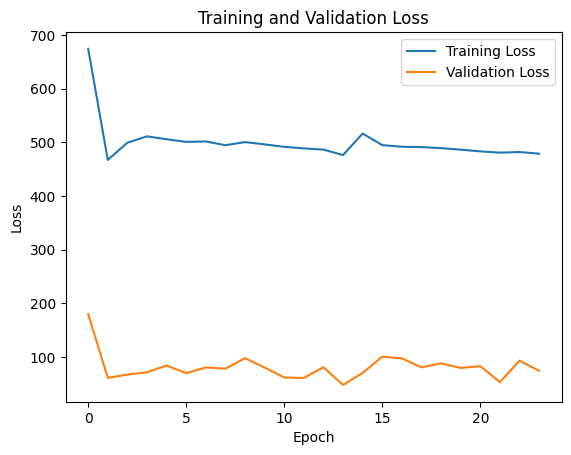

Fold 1 Results:
   Accuracy: 0.3842
   Average Sensitivity (Recall): 0.7070
   Average Specificity: 0.1695

Fold 2/3


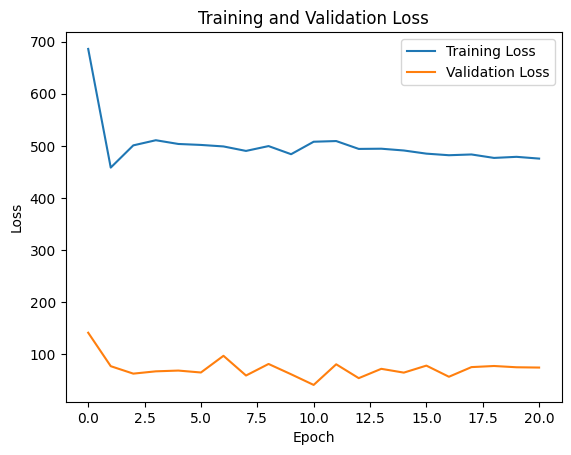

Fold 2 Results:
   Accuracy: 0.4046
   Average Sensitivity (Recall): 0.7566
   Average Specificity: 0.1826

Fold 3/3


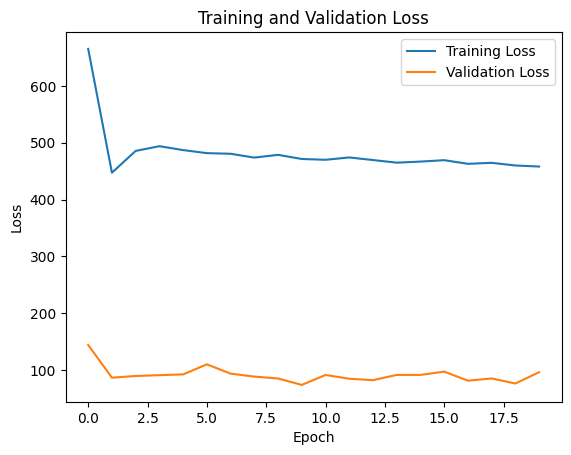

Fold 3 Results:
   Accuracy: 0.5485
   Average Sensitivity (Recall): 0.0674
   Average Specificity: 0.9486

Cross-Validation Results:
accuracy: Mean = 0.4458 ± 0.07
sensitivity: Mean = 0.5103 ± 0.31
specificity: Mean = 0.4336 ± 0.36
epochs: Mean = 21.6667 ± 1.70
training_times: Mean = 27.6214 ± 3.85
testing_times: Mean = 0.3523 ± 0.16
avg_memory_usage: Mean = 3.2123 ± 0.00
avg_gpu_usage: Mean = 0.0260 ± 0.00
max_memory_usage: Mean = 3.2123 ± 0.00
max_gpu_usage: Mean = 0.0265 ± 0.00


In [15]:
set_seed(42)
trainable_gcesn_dnd_3 = TrainableGCESN_3layer(dnd_num_features, 32, dnd_num_classes, leaky_rate=0.9, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_dnd_3.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_dnd_3, dd_dataset,
                lr=0.005, num_epochs=500, step_size=100, 
                save_path='models/trainable_gcesn_3l_dnd.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 40258


Fold 1/3


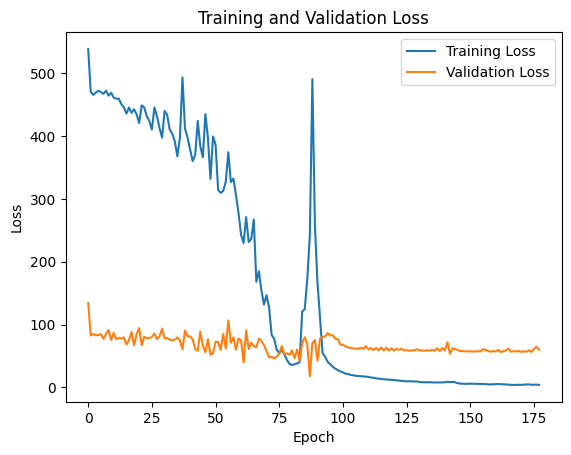

Fold 1 Results:
   Accuracy: 0.6260
   Average Sensitivity (Recall): 0.2293
   Average Specificity: 0.8898

Fold 2/3


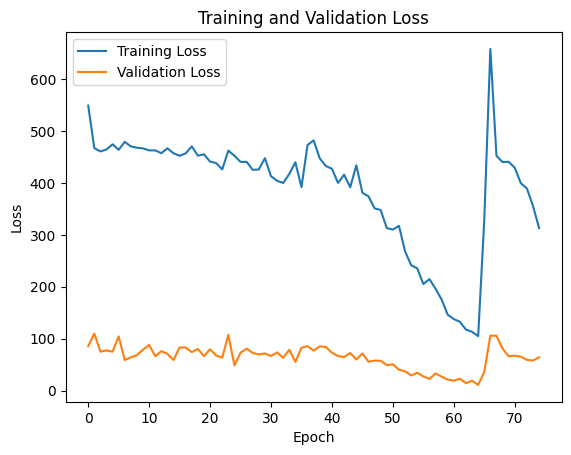

Fold 2 Results:
   Accuracy: 0.3868
   Average Sensitivity (Recall): 1.0000
   Average Specificity: 0.0000

Fold 3/3


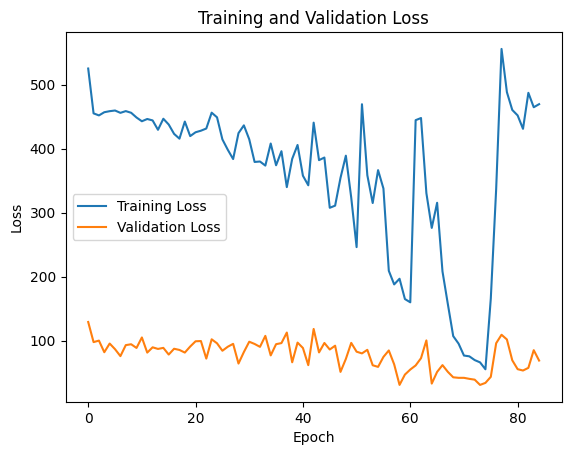

Fold 3 Results:
   Accuracy: 0.4515
   Average Sensitivity (Recall): 0.9888
   Average Specificity: 0.0047

Cross-Validation Results:
accuracy: Mean = 0.4881 ± 0.10
sensitivity: Mean = 0.7394 ± 0.36
specificity: Mean = 0.2982 ± 0.42
epochs: Mean = 112.6667 ± 46.38
training_times: Mean = 280.4732 ± 109.03
testing_times: Mean = 0.2479 ± 0.01
avg_memory_usage: Mean = 3.2093 ± 0.00
avg_gpu_usage: Mean = 0.0267 ± 0.00
max_memory_usage: Mean = 3.2095 ± 0.00
max_gpu_usage: Mean = 0.0268 ± 0.00


In [14]:
set_seed(42)
trainable_gcesn_dnd_4 = TrainableGCESN_4layer(dnd_num_features, 32, dnd_num_classes, leaky_rate=0.9, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_dnd_4.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_dnd_4, dd_dataset,
                lr=0.001, num_epochs=500, step_size=100,  
                save_path='models/trainable_gcesn_4l_dnd.pth',
                binary_classification=True, is_esn=True)

Total number of trainable parameters: 40130


Fold 1/3


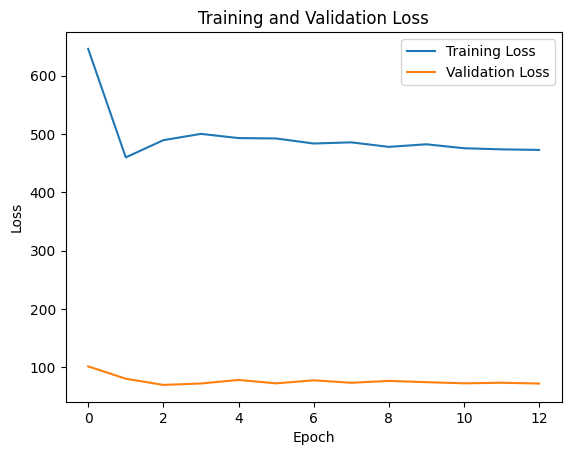

Fold 1 Results:
   Accuracy: 0.6005
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000

Fold 2/3


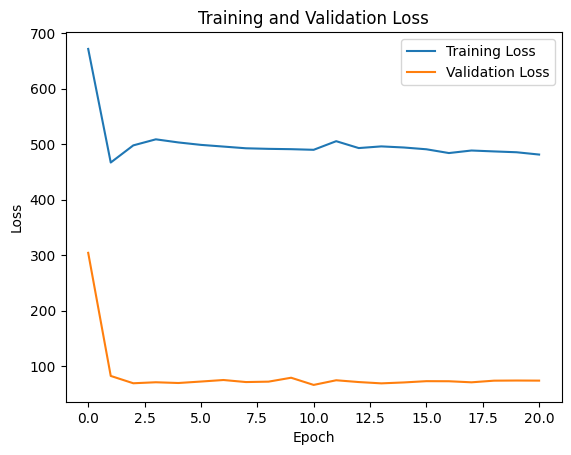

Fold 2 Results:
   Accuracy: 0.6132
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000

Fold 3/3


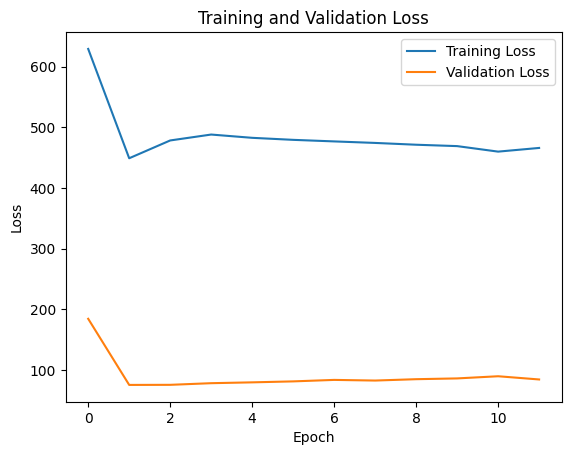

Fold 3 Results:
   Accuracy: 0.5459
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000

Cross-Validation Results:
accuracy: Mean = 0.5866 ± 0.03
sensitivity: Mean = 0.0000 ± 0.00
specificity: Mean = 1.0000 ± 0.00
epochs: Mean = 15.3333 ± 4.03
training_times: Mean = 16.5990 ± 6.34
testing_times: Mean = 0.1605 ± 0.02
avg_memory_usage: Mean = 4.5647 ± 0.00
avg_gpu_usage: Mean = 0.0261 ± 0.00
max_memory_usage: Mean = 4.5647 ± 0.00
max_gpu_usage: Mean = 0.0268 ± 0.00


In [9]:
set_seed(42)
trainable_gcesn_dnd_5 = TrainableGCESN_5layer(dnd_num_features, 32, dnd_num_classes, leaky_rate=0.8, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_dnd_5.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_dnd_5, dd_dataset,
                lr=0.005, num_epochs=500, step_size=100, 
                save_path='models/trainable_gcesn_5l_dnd.pth',
                binary_classification=True, is_esn=True)

# ENZYMES

## GAT

GAT1Layer(
  (gat1): GAT (21 -> 42)
  (bn1): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=42, out_features=6, bias=True)
)
Total number of trainable parameters: 1350


Fold 1/3


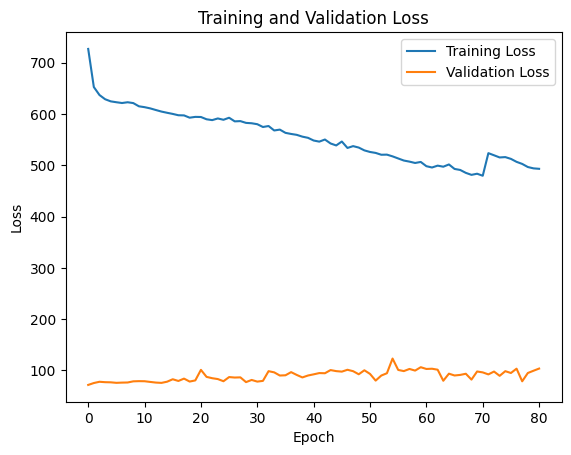

Fold 1 Results:
   Accuracy: 0.2550
   Average Sensitivity (Recall): 0.2354
   Average Specificity: 0.8468

Fold 2/3


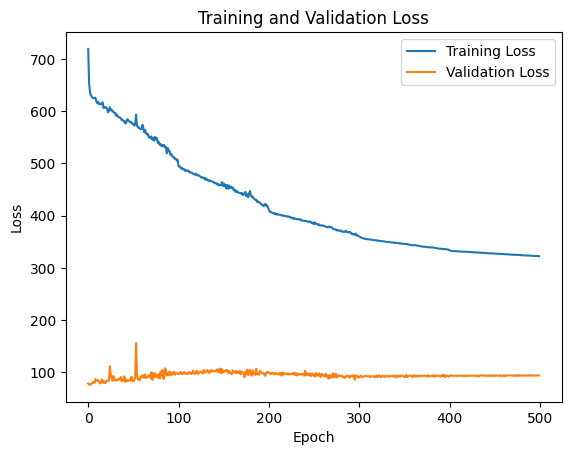

Fold 2 Results:
   Accuracy: 0.3550
   Average Sensitivity (Recall): 0.3327
   Average Specificity: 0.8700

Fold 3/3


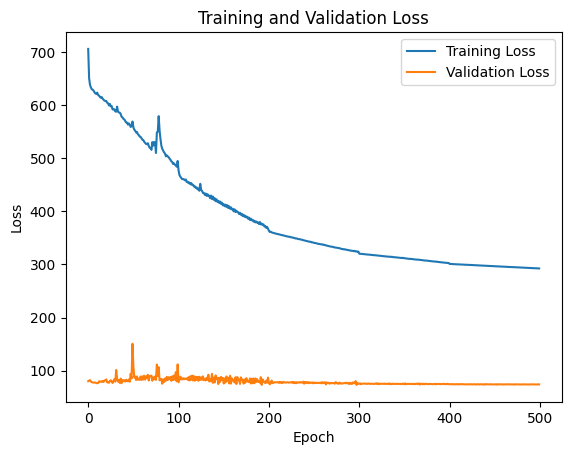

Fold 3 Results:
   Accuracy: 0.2750
   Average Sensitivity (Recall): 0.2817
   Average Specificity: 0.8557

Cross-Validation Results:
accuracy: Mean = 0.2950 ± 0.04
sensitivity: Mean = 0.2833 ± 0.04
specificity: Mean = 0.8575 ± 0.01
epochs: Mean = 360.3333 ± 197.52
training_times: Mean = 44.3239 ± 24.16
testing_times: Mean = 0.0435 ± 0.01
avg_memory_usage: Mean = 4.6164 ± 0.00
avg_gpu_usage: Mean = 1.5029 ± 0.00
max_memory_usage: Mean = 4.6164 ± 0.00
max_gpu_usage: Mean = 1.5029 ± 0.00


In [56]:
set_seed(42)
gat1_enzymes = GAT1Layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes).to(device)
print(gat1_enzymes)
print(f"Total number of trainable parameters: {(gat1_enzymes.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat1_enzymes, enzymes_dataset, 
            lr=0.005, num_epochs=500, step_size=100,  
            save_path='models/gat_1l_enzymes.pth', 
            binary_classification=False)

GAT2Layer(
  (gat1): GAT (21 -> 42)
  (bn1): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GAT (42 -> 84)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=84, out_features=6, bias=True)
)
Total number of trainable parameters: 5550


Fold 1/3


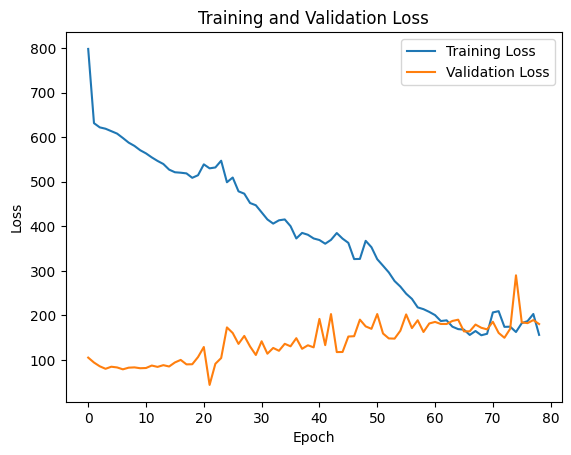

Fold 1 Results:
   Accuracy: 0.3100
   Average Sensitivity (Recall): 0.3026
   Average Specificity: 0.8598

Fold 2/3


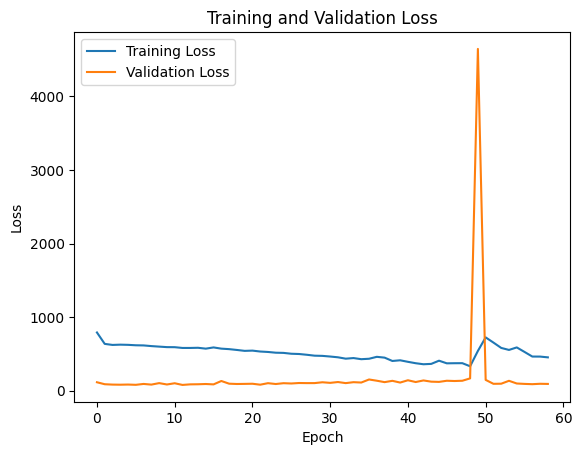

Fold 2 Results:
   Accuracy: 0.2100
   Average Sensitivity (Recall): 0.1679
   Average Specificity: 0.8339

Fold 3/3


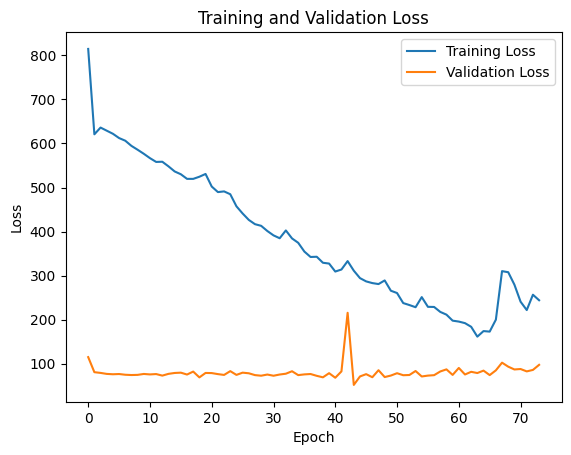

Fold 3 Results:
   Accuracy: 0.2250
   Average Sensitivity (Recall): 0.2248
   Average Specificity: 0.8450

Cross-Validation Results:
accuracy: Mean = 0.2483 ± 0.04
sensitivity: Mean = 0.2318 ± 0.06
specificity: Mean = 0.8463 ± 0.01
epochs: Mean = 70.6667 ± 8.50
training_times: Mean = 19.3481 ± 3.50
testing_times: Mean = 0.0893 ± 0.02
avg_memory_usage: Mean = 4.6164 ± 0.00
avg_gpu_usage: Mean = 1.5029 ± 0.00
max_memory_usage: Mean = 4.6164 ± 0.00
max_gpu_usage: Mean = 1.5029 ± 0.00


In [57]:
set_seed(42)
gat2_enzymes = GAT2Layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes).to(device)
print(gat2_enzymes)
print(f"Total number of trainable parameters: {(gat2_enzymes.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat2_enzymes, enzymes_dataset, 
            lr=0.005, num_epochs=500, step_size=500,  
            save_path='models/gat_2l_enzymes.pth', 
            binary_classification=False)

GAT3Layer(
  (gat1): GAT (21 -> 42)
  (bn1): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GAT (42 -> 84)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat3): GAT (84 -> 42)
  (bn3): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=42, out_features=6, bias=True)
)
Total number of trainable parameters: 9036


Fold 1/3


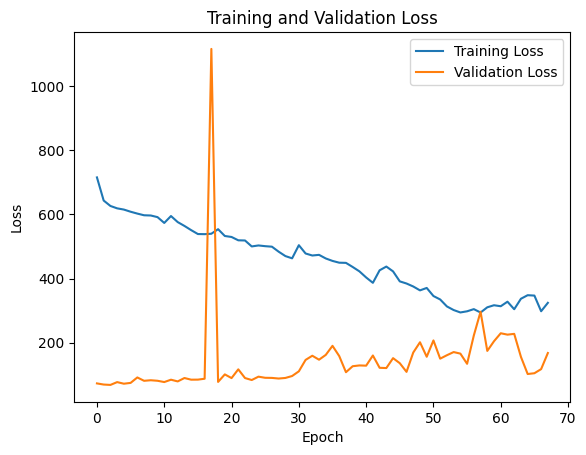

Fold 1 Results:
   Accuracy: 0.2300
   Average Sensitivity (Recall): 0.2139
   Average Specificity: 0.8417

Fold 2/3


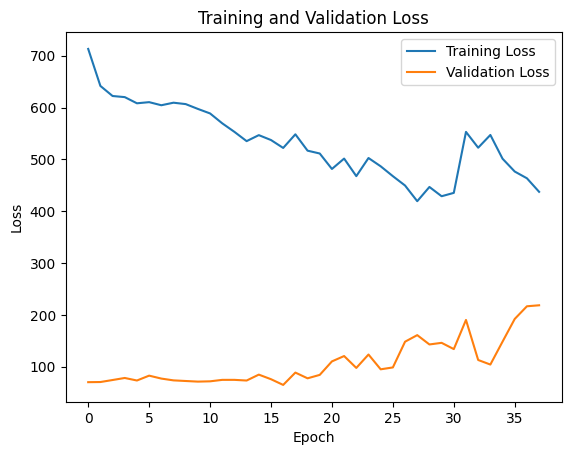

Fold 2 Results:
   Accuracy: 0.2150
   Average Sensitivity (Recall): 0.1957
   Average Specificity: 0.8397

Fold 3/3


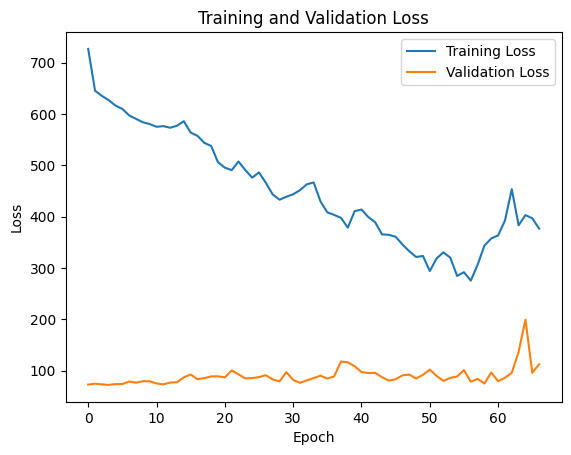

Fold 3 Results:
   Accuracy: 0.1800
   Average Sensitivity (Recall): 0.1874
   Average Specificity: 0.8375

Cross-Validation Results:
accuracy: Mean = 0.2083 ± 0.02
sensitivity: Mean = 0.1990 ± 0.01
specificity: Mean = 0.8396 ± 0.00
epochs: Mean = 57.6667 ± 13.91
training_times: Mean = 21.7045 ± 5.78
testing_times: Mean = 0.1144 ± 0.03
avg_memory_usage: Mean = 4.6348 ± 0.00
avg_gpu_usage: Mean = 1.5032 ± 0.00
max_memory_usage: Mean = 4.6348 ± 0.00
max_gpu_usage: Mean = 1.5032 ± 0.00


In [60]:
set_seed(42)
gat3_enzymes = GAT3Layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes).to(device)
print(gat3_enzymes)
print(f"Total number of trainable parameters: {(gat3_enzymes.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat3_enzymes, enzymes_dataset, 
            lr=0.005, num_epochs=500, step_size=100,  
            save_path='models/gat_3l_enzymes.pth', 
            binary_classification=False)

GAT4Layer(
  (gat1): GAT (21 -> 42)
  (bn1): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GAT (42 -> 84)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat3): GAT (84 -> 126)
  (bn3): BatchNorm1d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat4): GAT (126 -> 84)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=84, out_features=6, bias=True)
)
Total number of trainable parameters: 27768


Fold 1/3


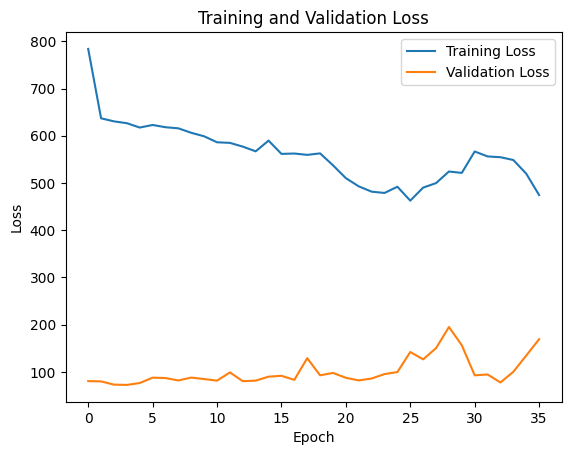

Fold 1 Results:
   Accuracy: 0.2300
   Average Sensitivity (Recall): 0.2196
   Average Specificity: 0.8431

Fold 2/3


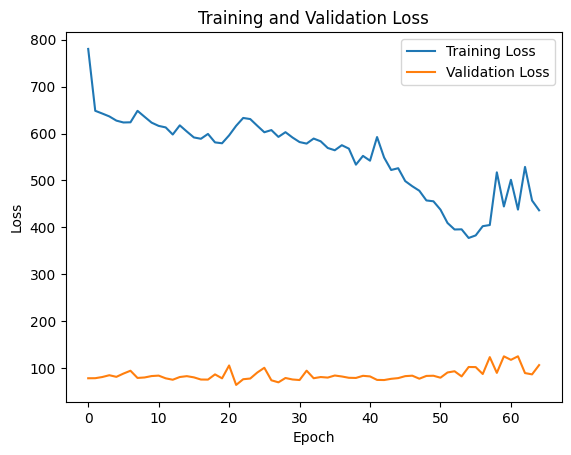

Fold 2 Results:
   Accuracy: 0.2200
   Average Sensitivity (Recall): 0.2102
   Average Specificity: 0.8428

Fold 3/3


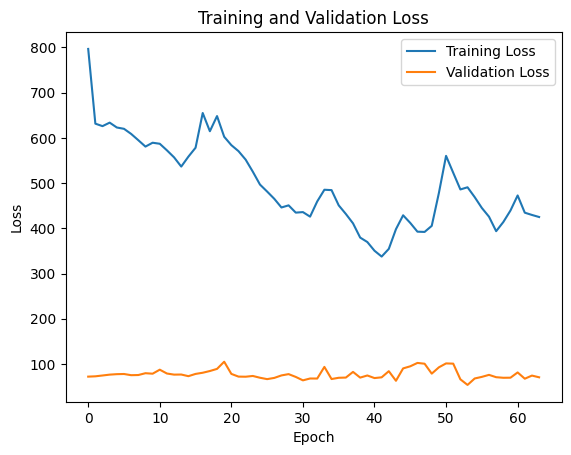

Fold 3 Results:
   Accuracy: 0.2250
   Average Sensitivity (Recall): 0.2344
   Average Specificity: 0.8458

Cross-Validation Results:
accuracy: Mean = 0.2250 ± 0.00
sensitivity: Mean = 0.2214 ± 0.01
specificity: Mean = 0.8439 ± 0.00
epochs: Mean = 55.0000 ± 13.44
training_times: Mean = 33.3488 ± 8.05
testing_times: Mean = 0.1886 ± 0.05
avg_memory_usage: Mean = 4.6344 ± 0.01
avg_gpu_usage: Mean = 1.5036 ± 0.00
max_memory_usage: Mean = 4.6354 ± 0.01
max_gpu_usage: Mean = 1.5036 ± 0.00


In [62]:
set_seed(42)
gat4_enzymes = GAT4Layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes).to(device)
print(gat4_enzymes)
print(f"Total number of trainable parameters: {(gat4_enzymes.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat4_enzymes, enzymes_dataset, 
            lr=0.005, num_epochs=500, step_size=500,  
            save_path='models/gat_4l_enzymes.pth',
            binary_classification=False)

GAT5Layer(
  (gat1): GAT (21 -> 42)
  (bn1): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GAT (42 -> 84)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat3): GAT (84 -> 126)
  (bn3): BatchNorm1d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat4): GAT (126 -> 84)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat5): GAT (84 -> 42)
  (bn5): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=42, out_features=6, bias=True)
)
Total number of trainable parameters: 31254


Fold 1/3


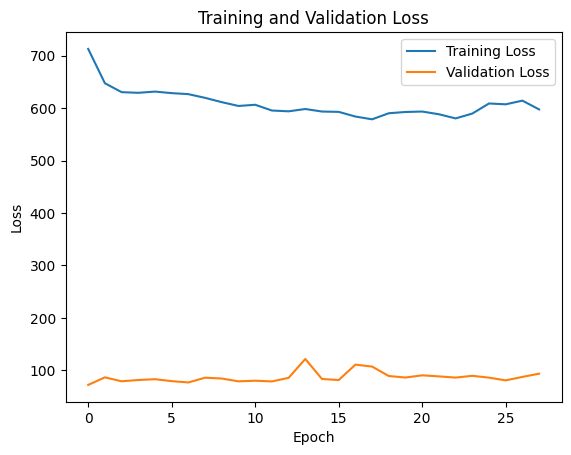

Fold 1 Results:
   Accuracy: 0.2450
   Average Sensitivity (Recall): 0.2644
   Average Specificity: 0.8503

Fold 2/3


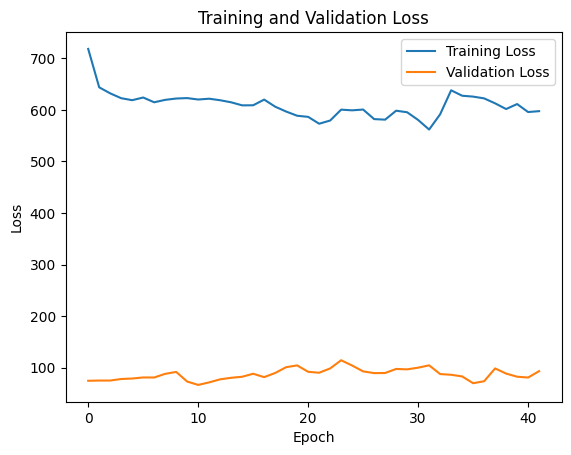

Fold 2 Results:
   Accuracy: 0.3050
   Average Sensitivity (Recall): 0.2939
   Average Specificity: 0.8617

Fold 3/3


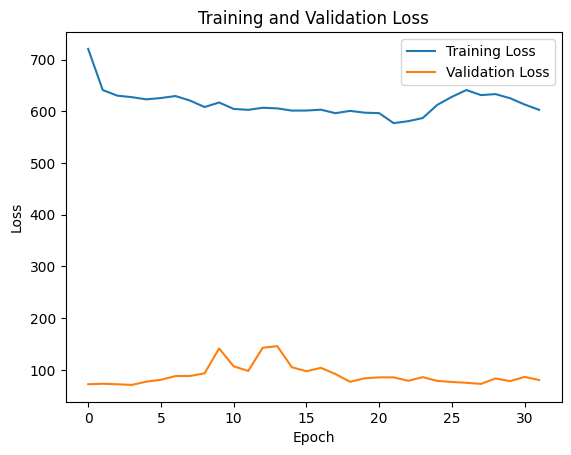

Fold 3 Results:
   Accuracy: 0.2300
   Average Sensitivity (Recall): 0.2258
   Average Specificity: 0.8441

Cross-Validation Results:
accuracy: Mean = 0.2600 ± 0.03
sensitivity: Mean = 0.2614 ± 0.03
specificity: Mean = 0.8520 ± 0.01
epochs: Mean = 34.0000 ± 5.89
training_times: Mean = 23.5632 ± 3.62
testing_times: Mean = 0.1913 ± 0.02
avg_memory_usage: Mean = 4.6434 ± 0.01
avg_gpu_usage: Mean = 1.5036 ± 0.00
max_memory_usage: Mean = 4.6460 ± 0.01
max_gpu_usage: Mean = 1.5036 ± 0.00


In [61]:
set_seed(42)
gat5_enzymes = GAT5Layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes).to(device)
print(gat5_enzymes)
print(f"Total number of trainable parameters: {(gat5_enzymes.count_parameters())}\n")
avg_metrics = single_train_test_cv(gat5_enzymes, enzymes_dataset, 
            lr=0.005, num_epochs=500, step_size=500,  
            save_path='models/gat_5l_enzymes.pth', 
            binary_classification=False)

## GCN

GCN1Layer(
  (gcn1): GCN (21 -> 42)
  (bn1): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=42, out_features=6, bias=True)
)
Total number of trainable parameters: 1266


Fold 1/3


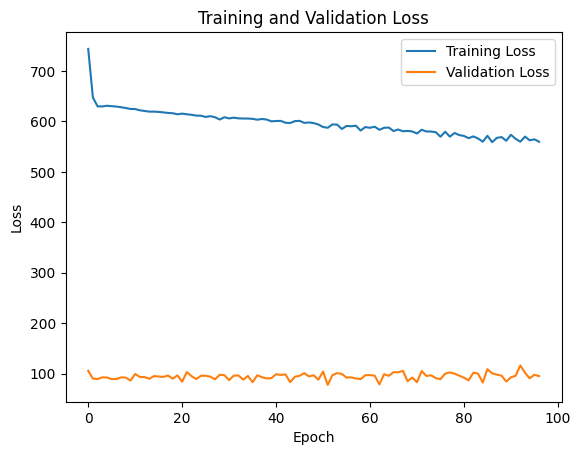

Fold 1 Results:
   Accuracy: 0.2200
   Average Sensitivity (Recall): 0.2362
   Average Specificity: 0.8457

Fold 2/3


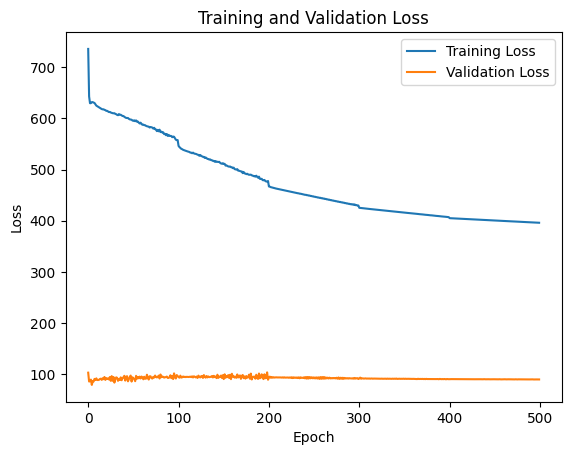

Fold 2 Results:
   Accuracy: 0.3350
   Average Sensitivity (Recall): 0.3258
   Average Specificity: 0.8671

Fold 3/3


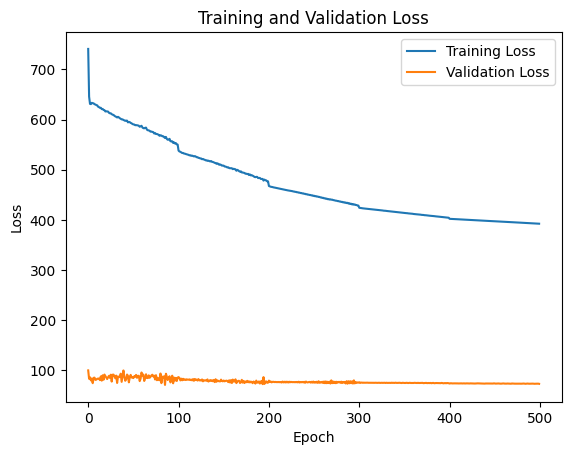

Fold 3 Results:
   Accuracy: 0.4050
   Average Sensitivity (Recall): 0.4083
   Average Specificity: 0.8811

Cross-Validation Results:
accuracy: Mean = 0.3200 ± 0.08
sensitivity: Mean = 0.3234 ± 0.07
specificity: Mean = 0.8646 ± 0.01
epochs: Mean = 365.6667 ± 189.98
training_times: Mean = 14.7378 ± 7.65
testing_times: Mean = 0.0219 ± 0.01
avg_memory_usage: Mean = 4.5654 ± 0.00
avg_gpu_usage: Mean = 0.0164 ± 0.00
max_memory_usage: Mean = 4.5654 ± 0.00
max_gpu_usage: Mean = 0.0164 ± 0.00


In [11]:
set_seed(42)
gcn1_enzymes = GCN1Layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes)
print(gcn1_enzymes)
print(f"Total number of trainable parameters: {(gcn1_enzymes.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn1_enzymes, enzymes_dataset, lr=0.005, 
            num_epochs=500, step_size=100, save_path='models/gcn_1l_enzymes.pth', 
            binary_classification=False)

GCN2Layer(
  (gcn1): GCN (21 -> 42)
  (bn1): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (42 -> 84)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=84, out_features=6, bias=True)
)
Total number of trainable parameters: 5298


Fold 1/3


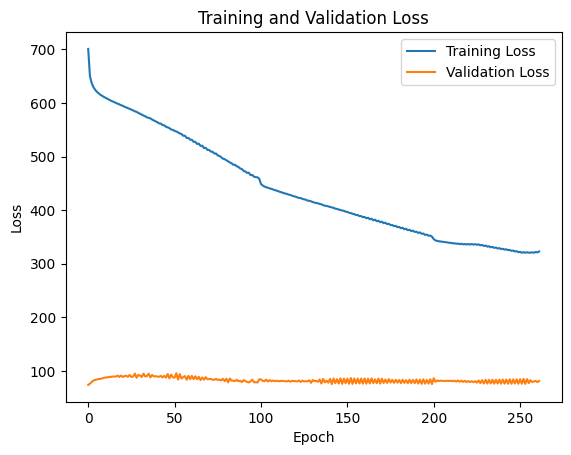

Fold 1 Results:
   Accuracy: 0.2350
   Average Sensitivity (Recall): 0.2468
   Average Specificity: 0.8487

Fold 2/3


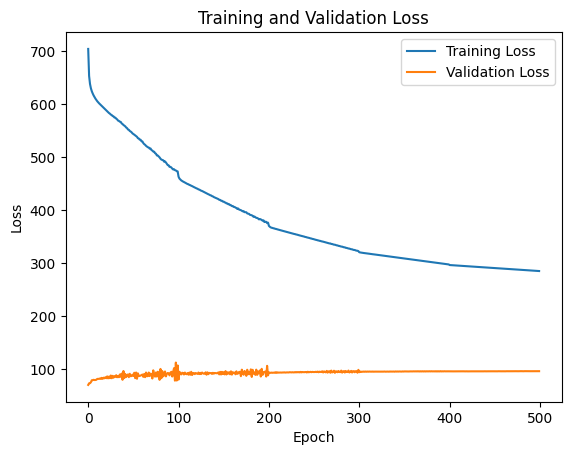

Fold 2 Results:
   Accuracy: 0.3900
   Average Sensitivity (Recall): 0.3771
   Average Specificity: 0.8780

Fold 3/3


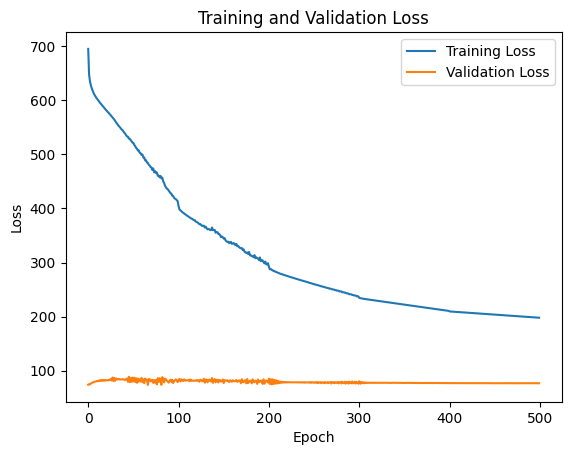

Fold 3 Results:
   Accuracy: 0.2150
   Average Sensitivity (Recall): 0.2159
   Average Specificity: 0.8436

Cross-Validation Results:
accuracy: Mean = 0.2800 ± 0.08
sensitivity: Mean = 0.2799 ± 0.07
specificity: Mean = 0.8568 ± 0.02
epochs: Mean = 420.6667 ± 112.19
training_times: Mean = 18.7951 ± 5.28
testing_times: Mean = 0.0172 ± 0.00
avg_memory_usage: Mean = 4.5774 ± 0.00
avg_gpu_usage: Mean = 0.0189 ± 0.00
max_memory_usage: Mean = 4.5774 ± 0.00
max_gpu_usage: Mean = 0.0189 ± 0.00


In [14]:
set_seed(42)
gcn2_enzymes = GCN2Layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes)
print(gcn2_enzymes)
print(f"Total number of trainable parameters: {(gcn2_enzymes.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn2_enzymes, enzymes_dataset, lr=0.001, 
            num_epochs=500, step_size=100, save_path='models/gcn_2l_enzymes.pth', 
            binary_classification=False)

GCN3Layer(
  (gcn1): GCN (21 -> 42)
  (bn1): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (42 -> 84)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (84 -> 42)
  (bn3): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=42, out_features=6, bias=True)
)
Total number of trainable parameters: 8700


Fold 1/3


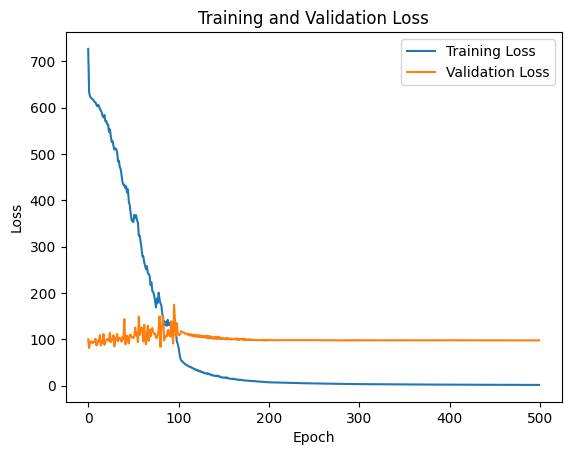

Fold 1 Results:
   Accuracy: 0.2100
   Average Sensitivity (Recall): 0.2318
   Average Specificity: 0.8451

Fold 2/3


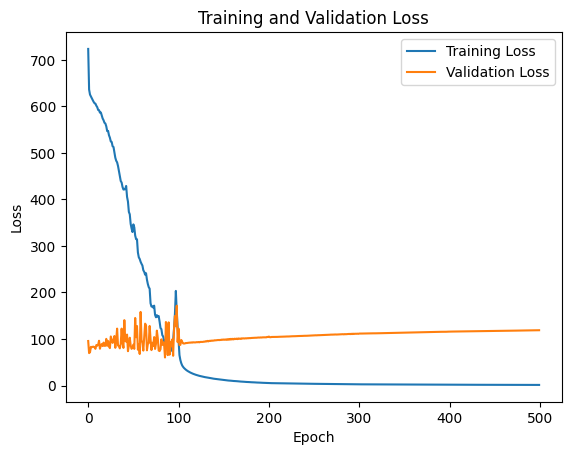

Fold 2 Results:
   Accuracy: 0.3200
   Average Sensitivity (Recall): 0.3124
   Average Specificity: 0.8643

Fold 3/3


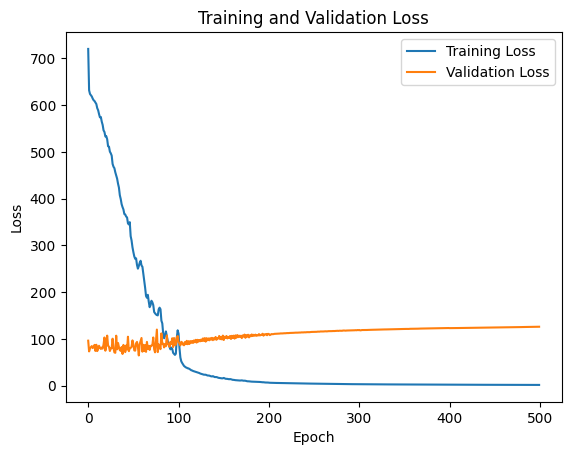

Fold 3 Results:
   Accuracy: 0.1900
   Average Sensitivity (Recall): 0.1883
   Average Specificity: 0.8377

Cross-Validation Results:
accuracy: Mean = 0.2400 ± 0.06
sensitivity: Mean = 0.2442 ± 0.05
specificity: Mean = 0.8490 ± 0.01
epochs: Mean = 500.0000 ± 0.00
training_times: Mean = 24.6805 ± 0.10
testing_times: Mean = 0.0187 ± 0.00
avg_memory_usage: Mean = 4.5776 ± 0.00
avg_gpu_usage: Mean = 0.0190 ± 0.00
max_memory_usage: Mean = 4.5776 ± 0.00
max_gpu_usage: Mean = 0.0190 ± 0.00


In [15]:
set_seed(42)
gcn3_enzymes = GCN3Layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes)
print(gcn3_enzymes)
print(f"Total number of trainable parameters: {(gcn3_enzymes.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn3_enzymes, enzymes_dataset, lr=0.005, 
            num_epochs=500, step_size=100, save_path='models/gcn_3l_enzymes.pth', 
            binary_classification=False)

GCN4Layer(
  (gcn1): GCN (21 -> 42)
  (bn1): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (42 -> 84)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (84 -> 126)
  (bn3): BatchNorm1d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (126 -> 84)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=84, out_features=6, bias=True)
)
Total number of trainable parameters: 27096


Fold 1/3


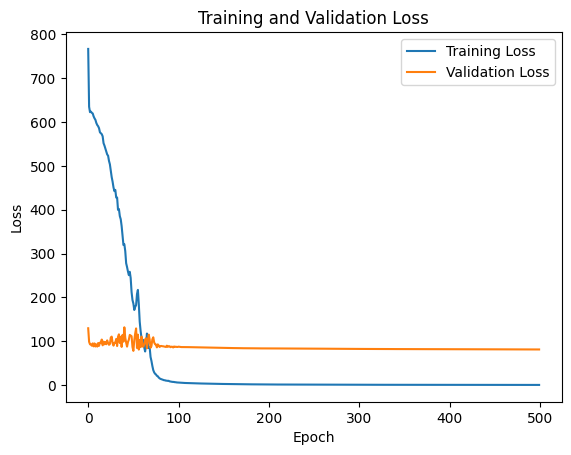

Fold 1 Results:
   Accuracy: 0.2200
   Average Sensitivity (Recall): 0.2443
   Average Specificity: 0.8475

Fold 2/3


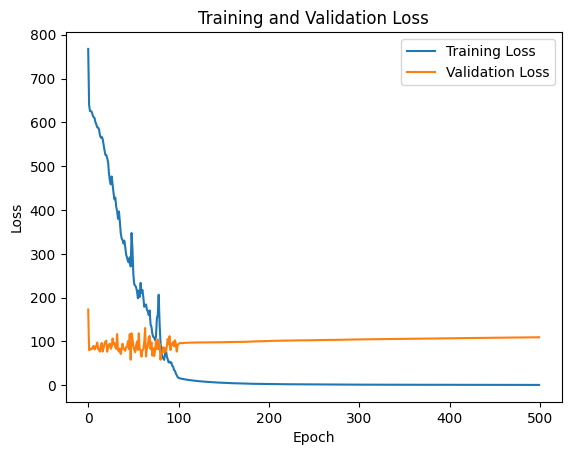

Fold 2 Results:
   Accuracy: 0.3250
   Average Sensitivity (Recall): 0.3167
   Average Specificity: 0.8664

Fold 3/3


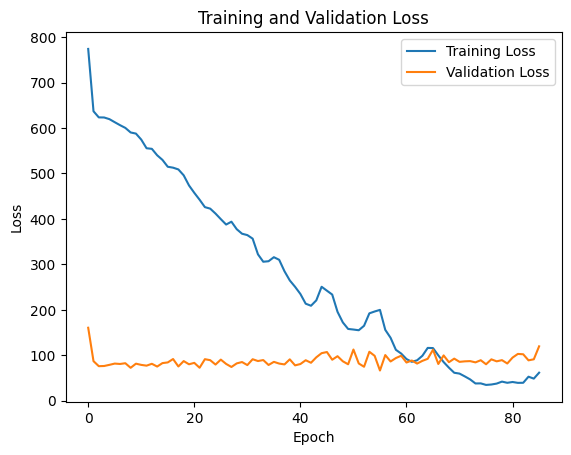

Fold 3 Results:
   Accuracy: 0.2400
   Average Sensitivity (Recall): 0.2422
   Average Specificity: 0.8479

Cross-Validation Results:
accuracy: Mean = 0.2617 ± 0.05
sensitivity: Mean = 0.2677 ± 0.03
specificity: Mean = 0.8539 ± 0.01
epochs: Mean = 362.0000 ± 195.16
training_times: Mean = 19.5659 ± 10.47
testing_times: Mean = 0.0187 ± 0.00
avg_memory_usage: Mean = 4.5781 ± 0.00
avg_gpu_usage: Mean = 0.0193 ± 0.00
max_memory_usage: Mean = 4.5781 ± 0.00
max_gpu_usage: Mean = 0.0193 ± 0.00


In [16]:
set_seed(42)
gcn4_enzymes = GCN4Layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes)
print(gcn4_enzymes)
print(f"Total number of trainable parameters: {(gcn4_enzymes.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn4_enzymes, enzymes_dataset, lr=0.005, 
            num_epochs=500, step_size=100, save_path='models/gcn_4l_enzymes.pth', 
            binary_classification=False)

GCN5Layer(
  (gcn1): GCN (21 -> 42)
  (bn1): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (42 -> 84)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (84 -> 126)
  (bn3): BatchNorm1d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (126 -> 84)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn5): GCN (84 -> 42)
  (bn5): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=42, out_features=6, bias=True)
)
Total number of trainable parameters: 30498


Fold 1/3


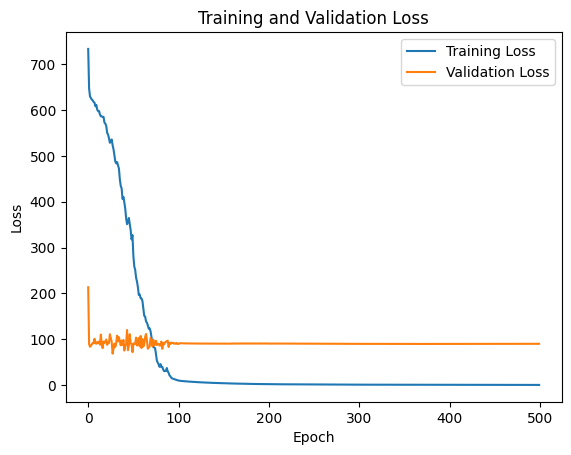

Fold 1 Results:
   Accuracy: 0.2150
   Average Sensitivity (Recall): 0.2322
   Average Specificity: 0.8458

Fold 2/3


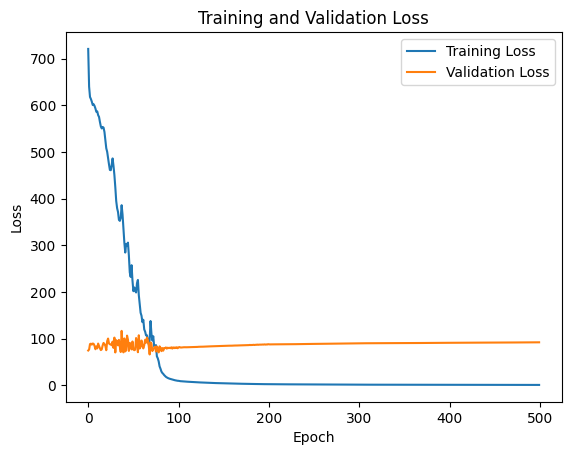

Fold 2 Results:
   Accuracy: 0.2700
   Average Sensitivity (Recall): 0.2511
   Average Specificity: 0.8518

Fold 3/3


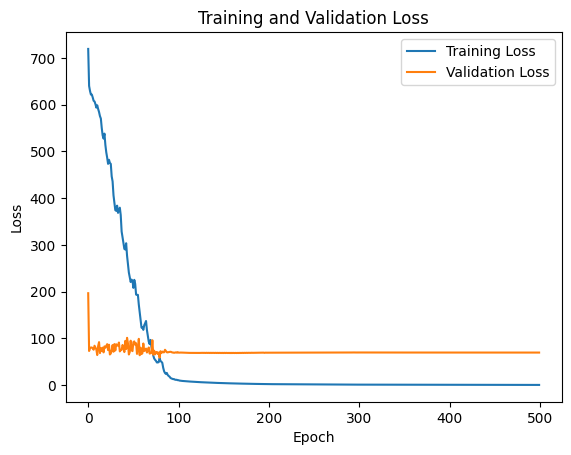

Fold 3 Results:
   Accuracy: 0.2050
   Average Sensitivity (Recall): 0.2148
   Average Specificity: 0.8422

Cross-Validation Results:
accuracy: Mean = 0.2300 ± 0.03
sensitivity: Mean = 0.2327 ± 0.01
specificity: Mean = 0.8466 ± 0.00
epochs: Mean = 500.0000 ± 0.00
training_times: Mean = 28.3666 ± 0.38
testing_times: Mean = 0.0203 ± 0.00
avg_memory_usage: Mean = 4.5826 ± 0.00
avg_gpu_usage: Mean = 0.0204 ± 0.00
max_memory_usage: Mean = 4.5826 ± 0.00
max_gpu_usage: Mean = 0.0204 ± 0.00


In [19]:
set_seed(42)
gcn5_enzymes = GCN5Layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes)
print(gcn5_enzymes)
print(f"Total number of trainable parameters: {(gcn5_enzymes.count_parameters())}\n")
avg_metrics = single_train_test_cv(gcn5_enzymes, enzymes_dataset, lr=0.005, 
            num_epochs=500, step_size=100, save_path='models/gcn_5l_enzymes.pth', 
            binary_classification=False)

## GCESN

In [32]:
gcesn_enzymes = GCESN_1layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, 
            leaky_rate=0.8, num_iterations=2)
print(gcesn_enzymes)
print(f"Total number of trainable parameters: {gcesn_enzymes.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_enzymes, enzymes_dataset,
                lr=0.005, num_epochs=500, step_size=100, 
                num_runs=3, binary_classification=False, 
                best_model_path='models/best_gcesn_1l_enzymes.pth')


GCESN_1layer(
  (fc1): Linear(in_features=42, out_features=42, bias=True)
  (bn): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=42, out_features=6, bias=True)
)
Total number of trainable parameters: 2148


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.2300
   Average Sensitivity (Recall): 0.2443
   Average Specificity: 0.8476
Fold 2/3
Fold 2 Results:
   Accuracy: 0.3200
   Average Sensitivity (Recall): 0.3130
   Average Specificity: 0.8650
Fold 3/3
Fold 3 Results:
   Accuracy: 0.2800
   Average Sensitivity (Recall): 0.2782
   Average Specificity: 0.8544
Run 1 Cross-Validation Results:
accuracy: Mean = 0.2767, Std = 0.0368
sensitivity: Mean = 0.2785, Std = 0.0281
specificity: Mean = 0.8557, Std = 0.0072

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.2250
   Average Sensitivity (Recall): 0.2386
   Average Specificity: 0.8468
Fold 2/3
Fold 2 Results:
   Accuracy: 0.2950
   Average Sensitivity (Recall): 0.2850
   Average Spec

In [35]:
gcesn_enzymes_2 = GCESN_2layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, 
                leaky_rate=0.9, num_iterations=1)
print(gcesn_enzymes_2)
print(f"Total number of trainable parameters: {gcesn_enzymes_2.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_enzymes_2, enzymes_dataset,
                lr=0.005, num_epochs=500, step_size=100,  
                num_runs=3, binary_classification=False, 
                best_model_path='models/best_gcesn_2l_enzymes.pth')


GCESN_2layer(
  (fc1): Linear(in_features=42, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=84, bias=True)
  (bn): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=84, out_features=6, bias=True)
)
Total number of trainable parameters: 11430


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.2200
   Average Sensitivity (Recall): 0.2164
   Average Specificity: 0.8434
Fold 2/3
Fold 2 Results:
   Accuracy: 0.2450
   Average Sensitivity (Recall): 0.2398
   Average Specificity: 0.8496
Fold 3/3
Fold 3 Results:
   Accuracy: 0.2550
   Average Sensitivity (Recall): 0.2508
   Average Specificity: 0.8485
Run 1 Cross-Validation Results:
accuracy: Mean = 0.2400, Std = 0.0147
sensitivity: Mean = 0.2356, Std = 0.0143
specificity: Mean = 0.8472, Std = 0.0027

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.2000
   Average Sensitivity (Recall): 0.2115
   Average Specificity: 0.8409
Fold 2/3
Fold 2 Results:
   Accuracy: 0

In [34]:
gcesn_enzymes_3 = GCESN_3layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, 
            leaky_rate=1, num_iterations=1)
print(gcesn_enzymes_3)
print(f"Total number of trainable parameters: {gcesn_enzymes_3.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_enzymes_3, enzymes_dataset,
                lr=0.005, num_epochs=500, step_size=100, 
                num_runs=3, binary_classification=False, 
                best_model_path='models/best_gcesn_3l_enzymes.pth')


GCESN_3layer(
  (fc1): Linear(in_features=42, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=42, bias=True)
  (fc3): Linear(in_features=42, out_features=42, bias=True)
  (bn): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=42, out_features=6, bias=True)
)
Total number of trainable parameters: 9330


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.1950
   Average Sensitivity (Recall): 0.1667
   Average Specificity: 0.8333
Fold 2/3
Fold 2 Results:
   Accuracy: 0.2750
   Average Sensitivity (Recall): 0.2583
   Average Specificity: 0.8546
Fold 3/3
Fold 3 Results:
   Accuracy: 0.2700
   Average Sensitivity (Recall): 0.2643
   Average Specificity: 0.8520
Run 1 Cross-Validation Results:
accuracy: Mean = 0.2467, Std = 0.0366
sensitivity: Mean = 0.2297, Std = 0.0447
specificity: Mean = 0.8466, Std = 0.0095

Run 2/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.2000
   Average Sensitivity (Recall): 0.1726
   Average 

In [29]:
gcesn_enzymes_4 = GCESN_4layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, 
                leaky_rate=0.7, num_iterations=1)
print(gcesn_enzymes_4)
print(f"Total number of trainable parameters: {gcesn_enzymes_4.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_enzymes_4, enzymes_dataset,
                lr=0.005, num_epochs=500, step_size=100,
                num_runs=3, binary_classification=False, 
                best_model_path='models/best_gcesn_4l_enzymes.pth')


GCESN_4layer(
  (fc1): Linear(in_features=42, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=126, bias=True)
  (fc3): Linear(in_features=126, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=84, bias=True)
  (bn): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=84, out_features=6, bias=True)
)
Total number of trainable parameters: 32808


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.2200
   Average Sensitivity (Recall): 0.2360
   Average Specificity: 0.8455
Fold 2/3
Fold 2 Results:
   Accuracy: 0.2000
   Average Sensitivity (Recall): 0.1970
   Average Specificity: 0.8418
Fold 3/3
Fold 3 Results:
   Accuracy: 0.1600
   Average Sensitivity (Recall): 0.1566
   Average Specificity: 0.8289
Run 1 Cross-Validation Results:
accuracy: Mean = 0.1933, Std = 0.0249
sensitivity: Mean = 0.1965, Std = 0.0324
specificity: Mean = 0.8387, Std = 0.0071

Run 2/3
Fold 1/3
Fold 1 Results:
   Accur

In [17]:
gcesn_enzymes_5 = GCESN_5layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, 
                leaky_rate=0.8, num_iterations=1)
print(gcesn_enzymes_5)
print(f"Total number of trainable parameters: {gcesn_enzymes_5.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_enzymes_5, enzymes_dataset,
                lr=0.001, num_epochs=500, step_size=100, 
                num_runs=3, binary_classification=False, 
                best_model_path='models/best_gcesn_5l_enzymes.pth')


GCESN_5layer(
  (fc1): Linear(in_features=42, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=126, bias=True)
  (fc3): Linear(in_features=126, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=42, bias=True)
  (fc5): Linear(in_features=42, out_features=42, bias=True)
  (bn): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=42, out_features=6, bias=True)
)
Total number of trainable parameters: 30708


Run 1/3
Fold 1/3
Fold 1 Results:
   Accuracy: 0.2050
   Average Sensitivity (Recall): 0.2229
   Average Specificity: 0.8442
Fold 2/3
Fold 2 Results:
   Accuracy: 0.2350
   Average Sensitivity (Recall): 0.2323
   Average Specificity: 0.8484
Fold 3/3
Fold 3 Results:
   Accuracy: 0.2350
   Average Sensitivity (Recall): 0.2348
   Average Specificity: 0.8459
Run 1 Cross-Validation Results:
accuracy: Mean = 0.2250, Std = 0.0141
sensitivity: Mean = 0.2300, Std = 0.0051
specificity: Mean = 0.8

## GCESN

Total number of trainable parameters: 4794


Fold 1/3


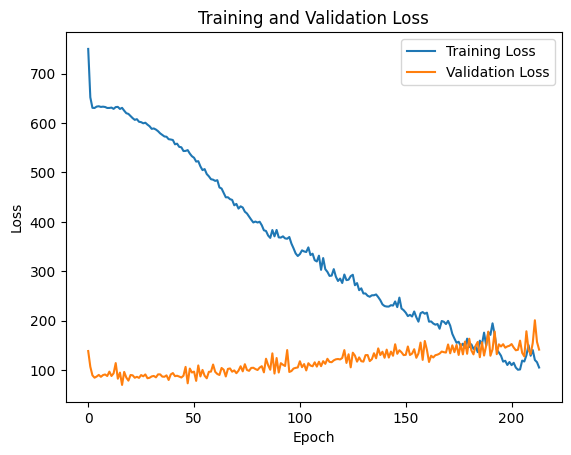

Fold 1 Results:
   Accuracy: 0.2300
   Average Sensitivity (Recall): 0.2087
   Average Specificity: 0.8425

Fold 2/3


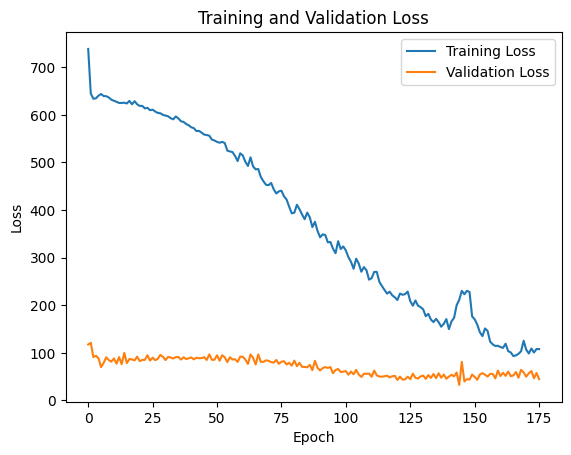

Fold 2 Results:
   Accuracy: 0.2450
   Average Sensitivity (Recall): 0.2088
   Average Specificity: 0.8429

Fold 3/3


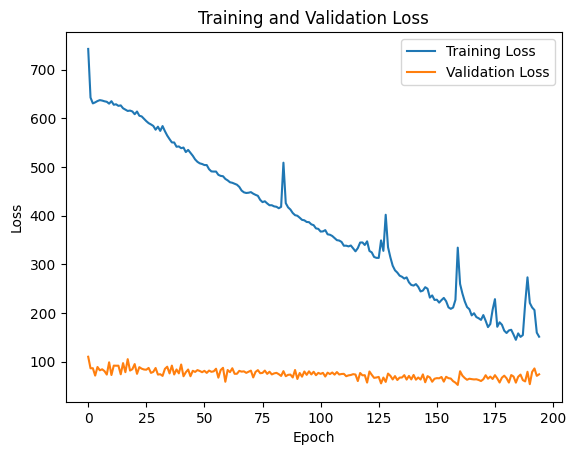

Fold 3 Results:
   Accuracy: 0.2400
   Average Sensitivity (Recall): 0.2330
   Average Specificity: 0.8452

Cross-Validation Results:
accuracy: Mean = 0.2383 ± 0.01
sensitivity: Mean = 0.2169 ± 0.01
specificity: Mean = 0.8435 ± 0.00
epochs: Mean = 195.0000 ± 15.51
training_times: Mean = 24.4825 ± 4.76
testing_times: Mean = 0.0193 ± 0.00
avg_memory_usage: Mean = 4.5483 ± 0.00
avg_gpu_usage: Mean = 0.0165 ± 0.00
max_memory_usage: Mean = 4.5483 ± 0.00
max_gpu_usage: Mean = 0.0165 ± 0.00


In [9]:
set_seed(42)
trainable_gcesn_enzymes = TrainableGCESN_1layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, 
                leaky_rate=0.8, num_iterations=2)
print(f"Total number of trainable parameters: {trainable_gcesn_enzymes.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_enzymes, enzymes_dataset,
                lr=0.005, num_epochs=500, step_size=500, 
                save_path='models/trainable_gcesn_1l_enzymes.pth',
                binary_classification=False, is_esn=True)

Total number of trainable parameters: 17226


Fold 1/3


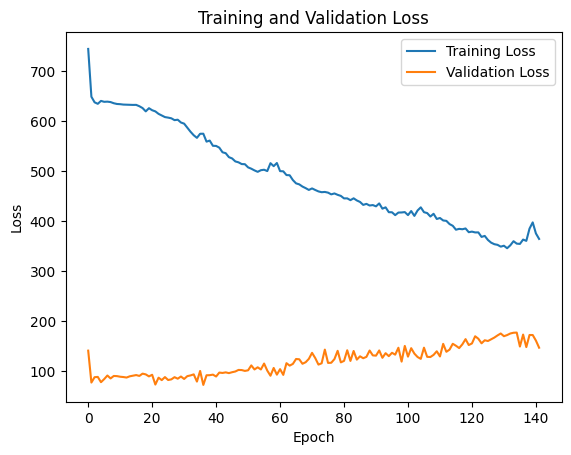

Fold 1 Results:
   Accuracy: 0.1950
   Average Sensitivity (Recall): 0.1667
   Average Specificity: 0.8333

Fold 2/3


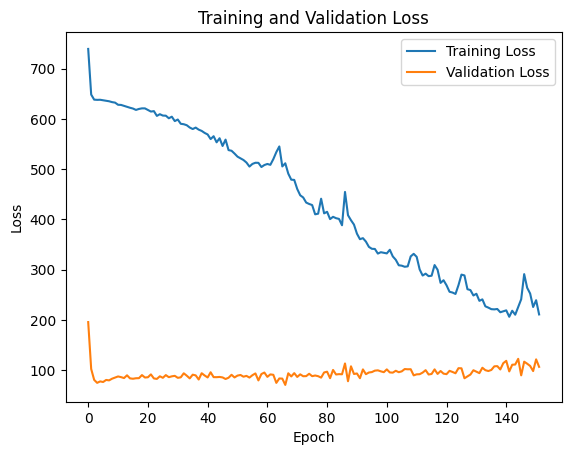

Fold 2 Results:
   Accuracy: 0.2200
   Average Sensitivity (Recall): 0.1778
   Average Specificity: 0.8359

Fold 3/3


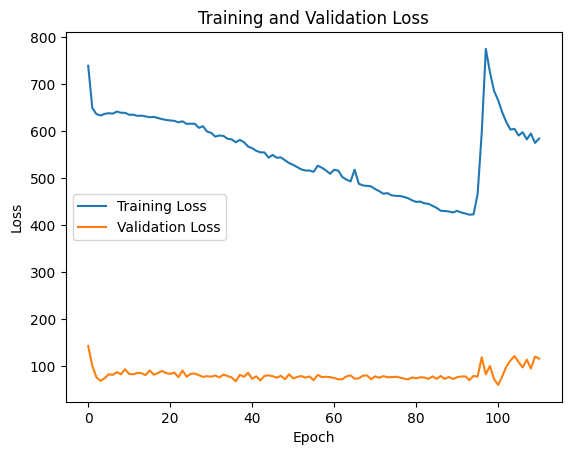

Fold 3 Results:
   Accuracy: 0.2800
   Average Sensitivity (Recall): 0.2915
   Average Specificity: 0.8567

Cross-Validation Results:
accuracy: Mean = 0.2317 ± 0.04
sensitivity: Mean = 0.2120 ± 0.06
specificity: Mean = 0.8420 ± 0.01
epochs: Mean = 135.0000 ± 17.45
training_times: Mean = 21.2456 ± 3.82
testing_times: Mean = 0.0205 ± 0.00
avg_memory_usage: Mean = 4.5483 ± 0.00
avg_gpu_usage: Mean = 0.0166 ± 0.00
max_memory_usage: Mean = 4.5483 ± 0.00
max_gpu_usage: Mean = 0.0166 ± 0.00


In [11]:
set_seed(42)
trainable_gcesn_enzymes_2 = TrainableGCESN_2layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, 
                    leaky_rate=0.9, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_enzymes_2.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_enzymes_2, enzymes_dataset,
                lr=0.005, num_epochs=500, step_size=100, 
                save_path='models/trainable_gcesn_2l_enzymes.pth',
                binary_classification=False, is_esn=True)

Total number of trainable parameters: 20796


Fold 1/3


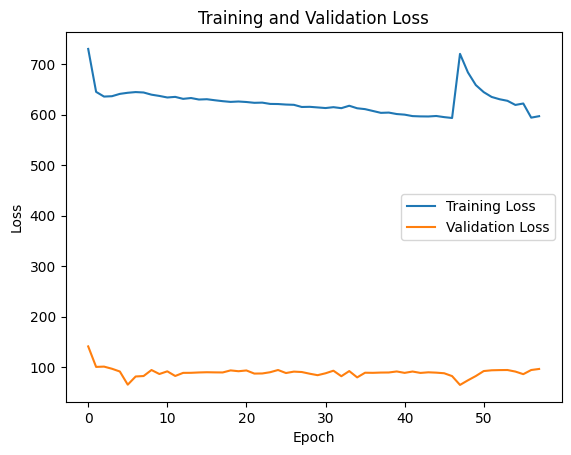

Fold 1 Results:
   Accuracy: 0.1500
   Average Sensitivity (Recall): 0.1724
   Average Specificity: 0.8340

Fold 2/3


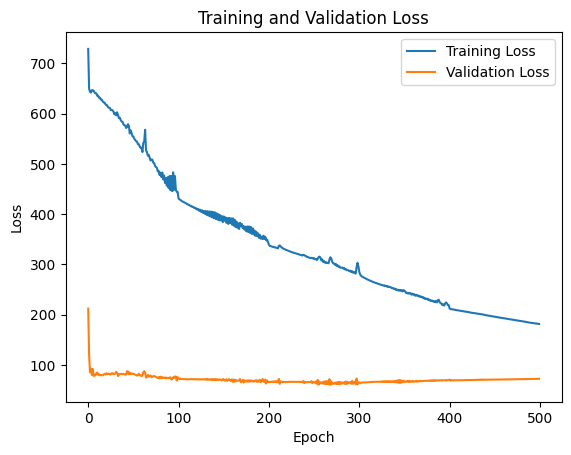

Fold 2 Results:
   Accuracy: 0.2700
   Average Sensitivity (Recall): 0.2628
   Average Specificity: 0.8545

Fold 3/3


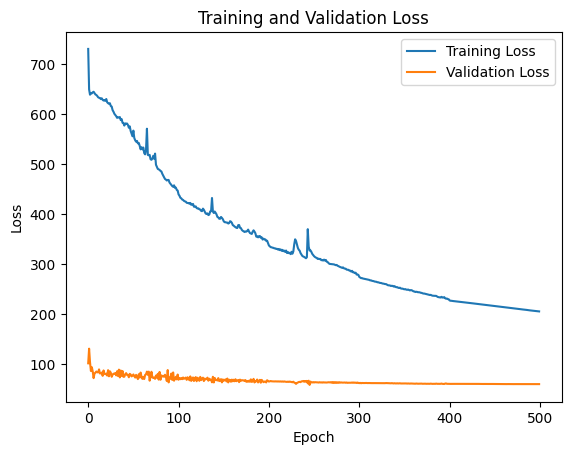

Fold 3 Results:
   Accuracy: 0.2650
   Average Sensitivity (Recall): 0.2598
   Average Specificity: 0.8506

Cross-Validation Results:
accuracy: Mean = 0.2283 ± 0.06
sensitivity: Mean = 0.2316 ± 0.04
specificity: Mean = 0.8464 ± 0.01
epochs: Mean = 352.6667 ± 208.36
training_times: Mean = 89.6024 ± 53.41
testing_times: Mean = 0.0195 ± 0.00
avg_memory_usage: Mean = 4.5494 ± 0.00
avg_gpu_usage: Mean = 0.0167 ± 0.00
max_memory_usage: Mean = 4.5494 ± 0.00
max_gpu_usage: Mean = 0.0167 ± 0.00


In [12]:
set_seed(42)
trainable_gcesn_enzymes_3 = TrainableGCESN_3layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, 
                        leaky_rate=0.7, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_enzymes_3.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_enzymes_3, enzymes_dataset,
                lr=0.005, num_epochs=500, step_size=100,  
                save_path='models/trainable_gcesn_3l_enzymes.pth',
                binary_classification=False, is_esn=True)

Total number of trainable parameters: 65442


Fold 1/3


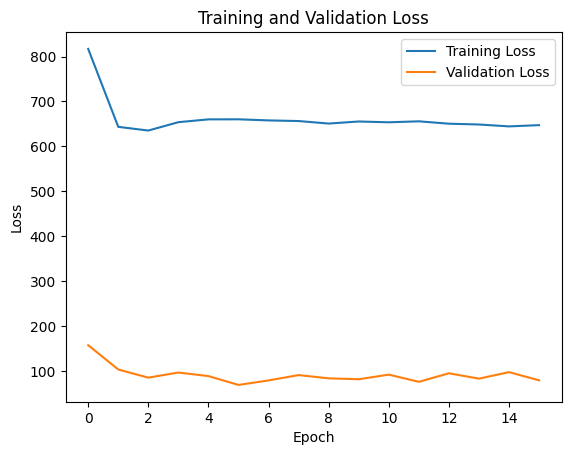

Fold 1 Results:
   Accuracy: 0.2100
   Average Sensitivity (Recall): 0.2096
   Average Specificity: 0.8425

Fold 2/3


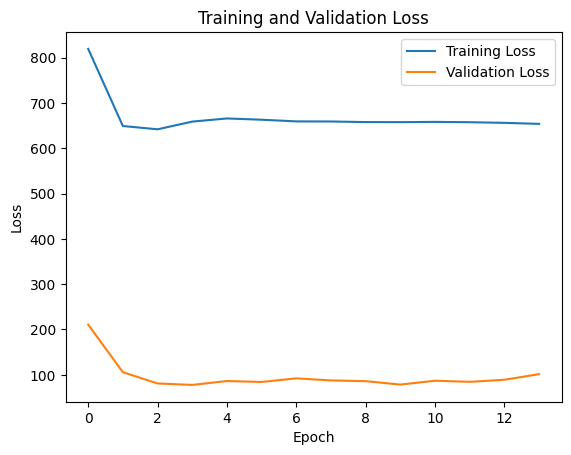

Fold 2 Results:
   Accuracy: 0.1800
   Average Sensitivity (Recall): 0.1957
   Average Specificity: 0.8389

Fold 3/3


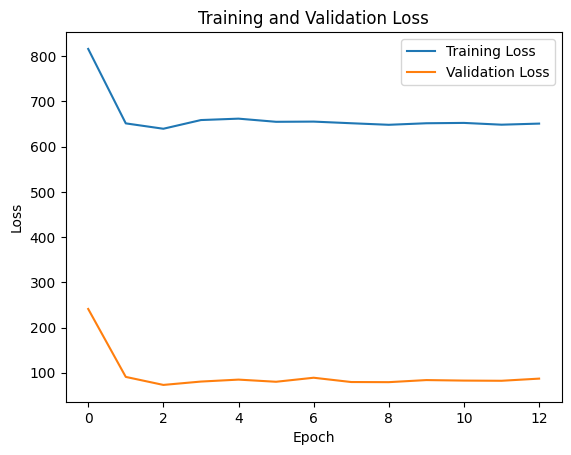

Fold 3 Results:
   Accuracy: 0.2700
   Average Sensitivity (Recall): 0.2663
   Average Specificity: 0.8524

Cross-Validation Results:
accuracy: Mean = 0.2200 ± 0.04
sensitivity: Mean = 0.2239 ± 0.03
specificity: Mean = 0.8446 ± 0.01
epochs: Mean = 14.3333 ± 1.25
training_times: Mean = 11.0732 ± 3.20
testing_times: Mean = 0.0231 ± 0.00
avg_memory_usage: Mean = 4.5605 ± 0.00
avg_gpu_usage: Mean = 0.0188 ± 0.00
max_memory_usage: Mean = 4.5605 ± 0.00
max_gpu_usage: Mean = 0.0188 ± 0.00


In [23]:
set_seed(42)
trainable_gcesn_enzymes_4 = TrainableGCESN_4layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, 
                    leaky_rate=0.8, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_enzymes_4.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_enzymes_4, enzymes_dataset,
                lr=0.005, num_epochs=500, step_size=100, 
                save_path='models/trainable_gcesn_4l_enzymes.pth',
                binary_classification=False, is_esn=True)

Total number of trainable parameters: 65106


Fold 1/3


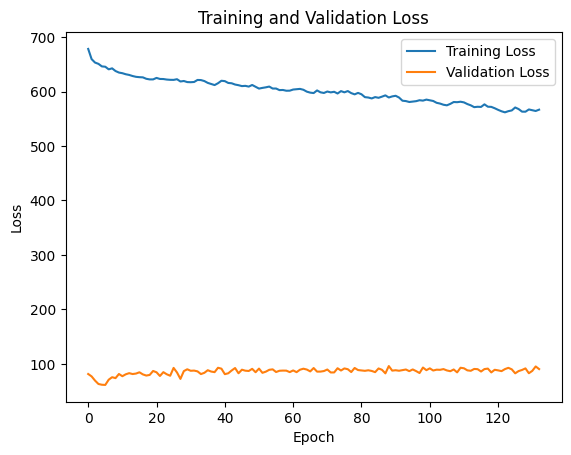

Fold 1 Results:
   Accuracy: 0.2250
   Average Sensitivity (Recall): 0.2397
   Average Specificity: 0.8467

Fold 2/3


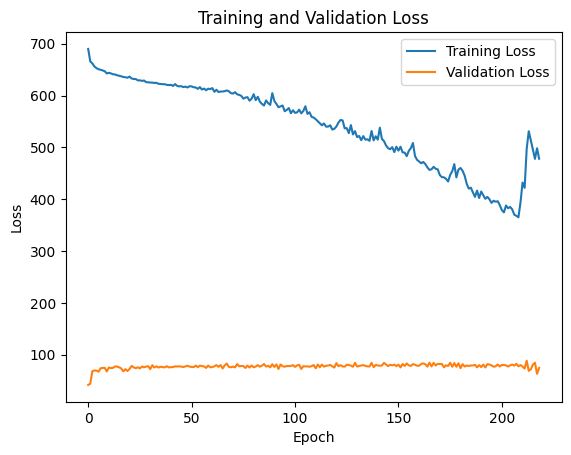

Fold 2 Results:
   Accuracy: 0.2350
   Average Sensitivity (Recall): 0.2122
   Average Specificity: 0.8437

Fold 3/3


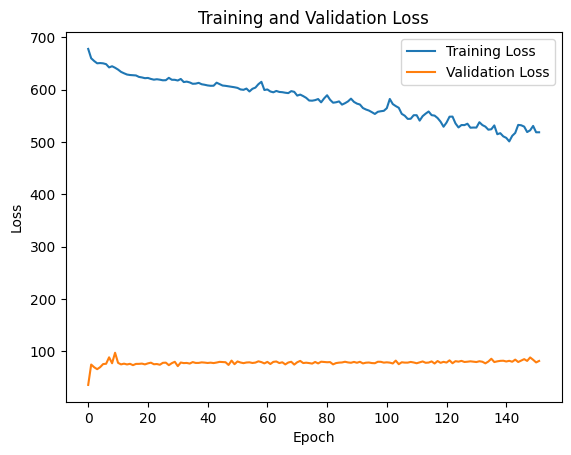

Fold 3 Results:
   Accuracy: 0.1400
   Average Sensitivity (Recall): 0.1539
   Average Specificity: 0.8311

Cross-Validation Results:
accuracy: Mean = 0.2000 ± 0.04
sensitivity: Mean = 0.2019 ± 0.04
specificity: Mean = 0.8405 ± 0.01
epochs: Mean = 168.0000 ± 36.89
training_times: Mean = 100.1729 ± 16.90
testing_times: Mean = 0.0232 ± 0.00
avg_memory_usage: Mean = 4.5692 ± 0.00
avg_gpu_usage: Mean = 0.0188 ± 0.00
max_memory_usage: Mean = 4.5692 ± 0.00
max_gpu_usage: Mean = 0.0188 ± 0.00


In [26]:
set_seed(42)
trainable_gcesn_enzymes_5 = TrainableGCESN_5layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, 
                    leaky_rate=0.8, num_iterations=1)
print(f"Total number of trainable parameters: {trainable_gcesn_enzymes_5.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_enzymes_5, enzymes_dataset,
                lr=0.001, num_epochs=500, step_size=500, 
                save_path='models/trainable_gcesn_5l_enzymes.pth',
                binary_classification=False, is_esn=True)